In [1]:
import haversine as hs
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import xarray as xr
import torch
from torch_geometric.data import Data, Dataset
from Trainer_loocv import Trainer
import utils
import wind_utils
from GCN_Regression import GCN_RegressionModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [3]:
df = data.to_dataframe().reset_index()
df = df.dropna(subset=["PM2.5", "WS", "WD"])
df['WD'] = 270-df['WD']

# GNN

In [4]:
def loocv(timestamp):
    dataframe = []
    d = df[df["time"]==timestamp]
    
    G = utils.nearest_neighbors_graph(d, 8)
    node_features, edge_index, y = utils.dataset_generation(G)
    
    wind_G = wind_utils.nearest_neighbors_graph(d, 8)
    w_node_features, edge_index, y = wind_utils.dataset_generation(wind_G)
    
    for super in list(G.nodes()):
#         print(super)
        # Divide train and test masks based on the latitudes
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        test_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for j, node in list(enumerate(G.nodes)):
            if node!=super:
                train_mask[j] = True
            else:
                test_mask[j] = True
        
        #Wind GNN
        w_data = Data(x=torch.tensor(w_node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask = test_mask)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model1 = GCN_RegressionModel(4)
        trainer = Trainer(model = model1, data = w_data, device = device, epochs=2500)
        trainer.train(lr=0.0005)
        out = model1(w_data.x.to(device), w_data.edge_index.to(device))  # Predicted PM values
        w_pred = out[w_data.test_mask].squeeze().tolist()
        w_rmse = torch.sqrt(torch.mean((out[w_data.test_mask].squeeze() - w_data.y[w_data.test_mask].squeeze())**2))
        
        #No Wind GNN
        data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask = test_mask)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model2 = GCN_RegressionModel(2)
        trainer = Trainer(model = model2, data = data, device = device, epochs=2500)
        trainer.train(lr=0.0005)
        out = model2(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
        nw_pred = out[data.test_mask].squeeze().tolist()
        nw_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
        
        #Actual
        actual = data.y[data.test_mask].squeeze().tolist()

        dataframe.append({
                            "node": G.nodes[super]["station"],
                            "lat": G.nodes[super]["latitude"],
                            "lon": G.nodes[super]["longitude"],
                            "pm": G.nodes[super]["pm"],
                            "WD": wind_G.nodes[super]["wd"],
                            "WS": wind_G.nodes[super]["ws"],
                            "wind rmse": float(w_rmse),
                            "no wind rmse": float(nw_rmse),
                            "actual": actual,
                            "wind pred": w_pred,
                            "no wind pred": nw_pred,
                           })
    return dataframe

Timestamp: 2022-03-01 00:30:00
No Wind RMSE:  27.314653941563197
Wind RMSE:  28.794661385672434


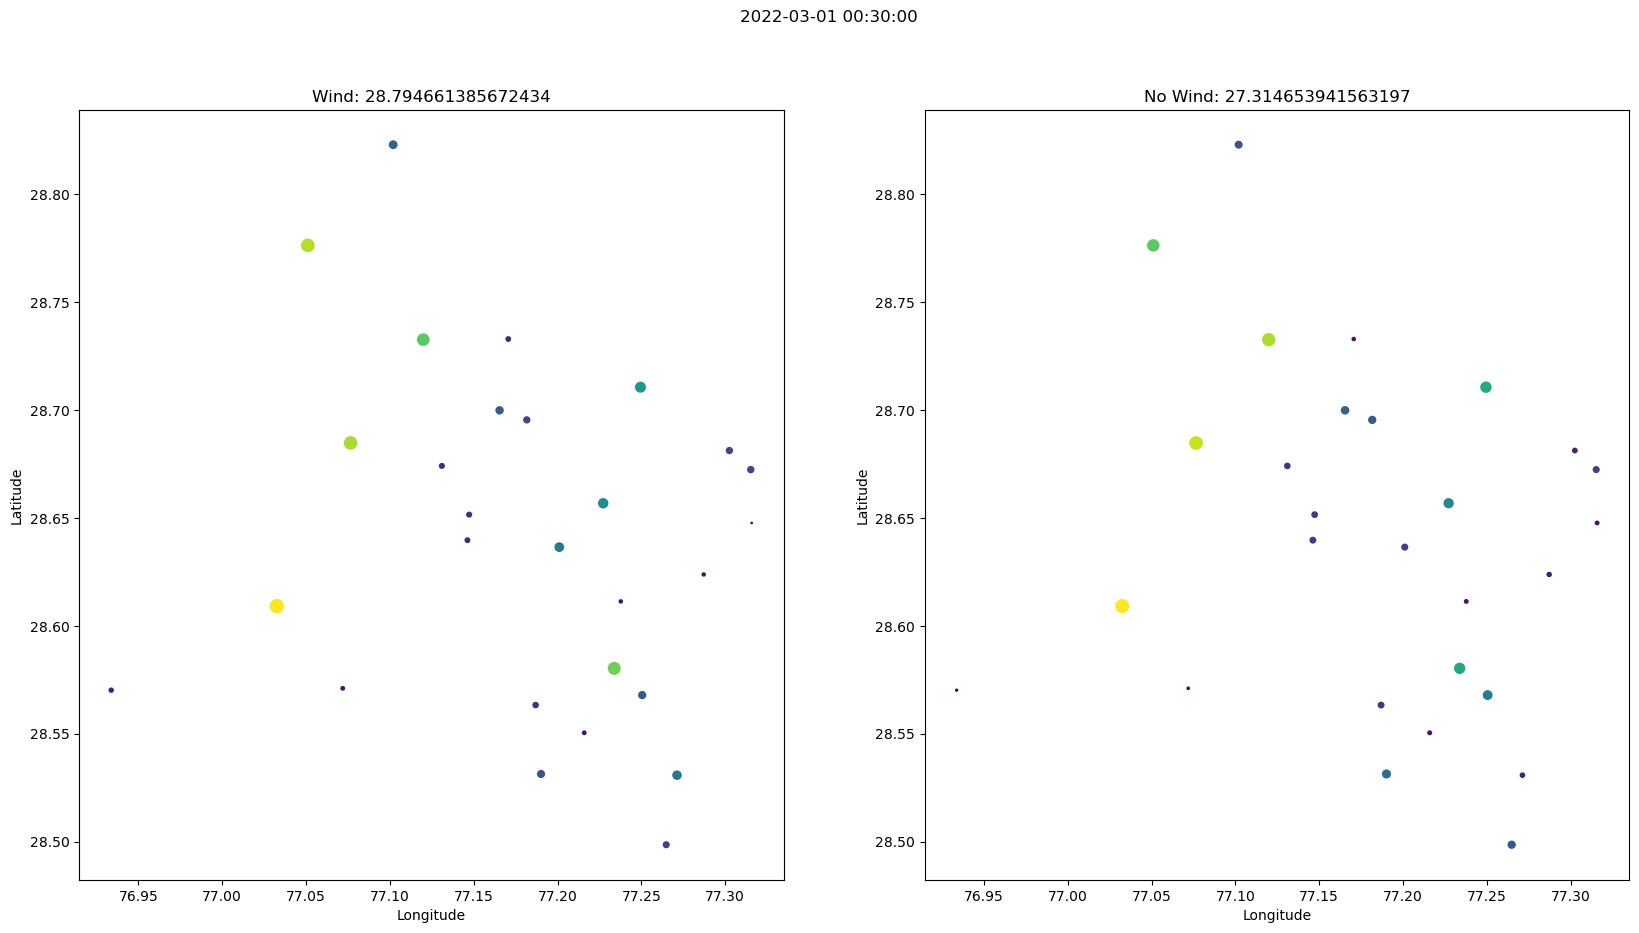

Timestamp: 2022-03-03 00:30:00
No Wind RMSE:  42.99372863769531
Wind RMSE:  47.3948728773329


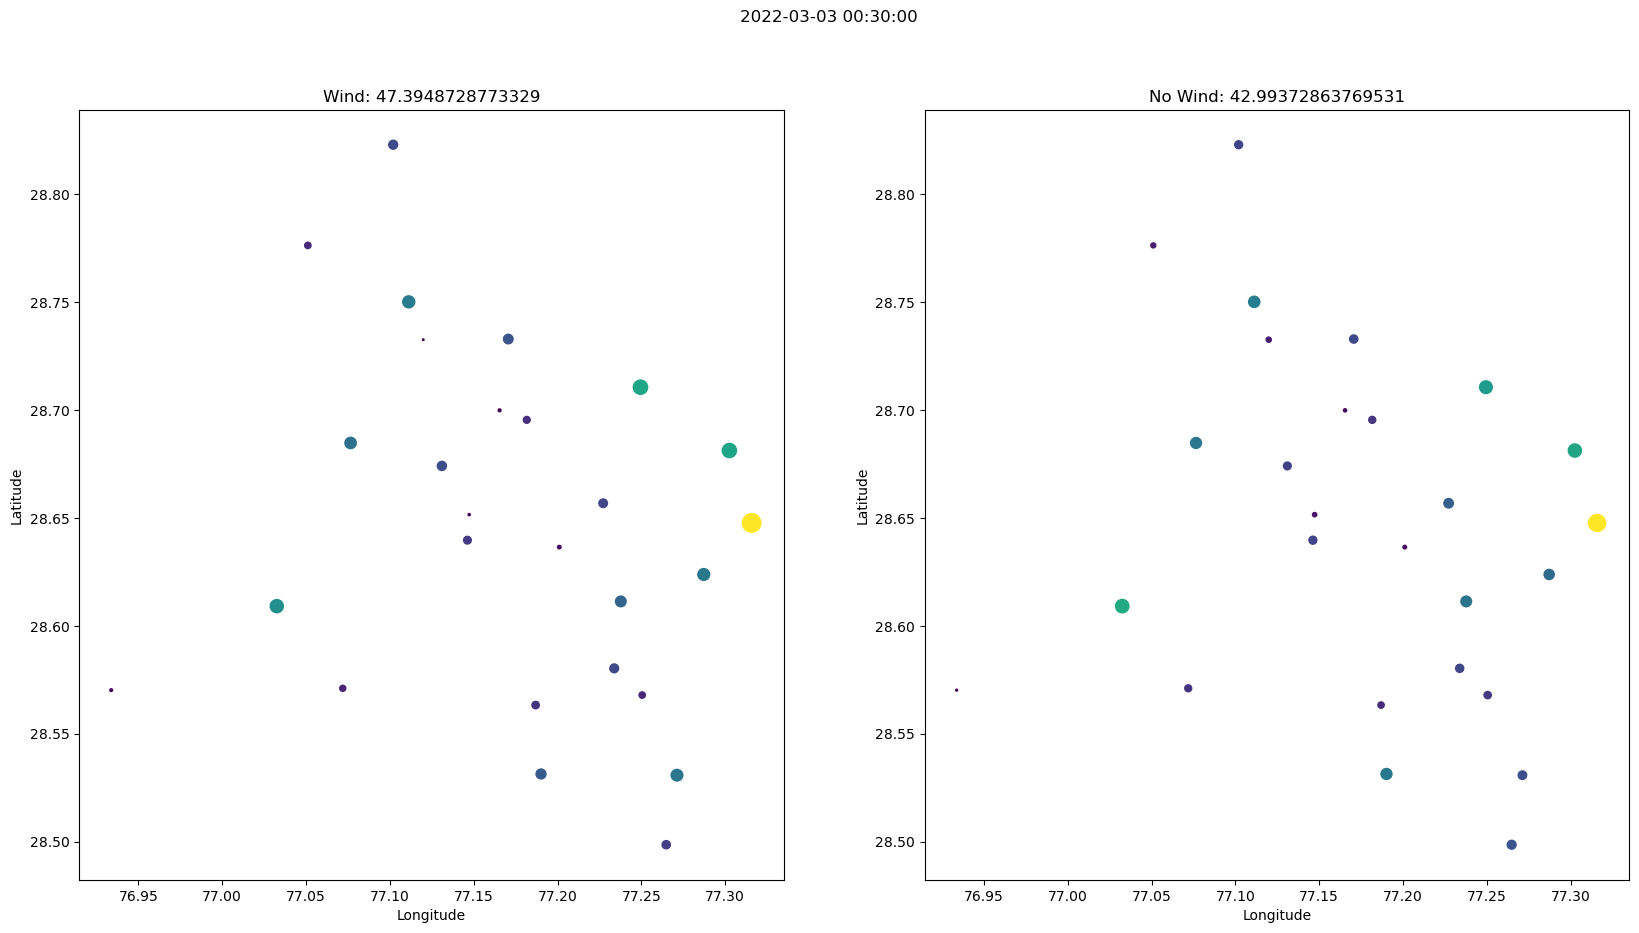

Timestamp: 2022-03-05 00:30:00
No Wind RMSE:  10.503730703283239
Wind RMSE:  10.164037139327437


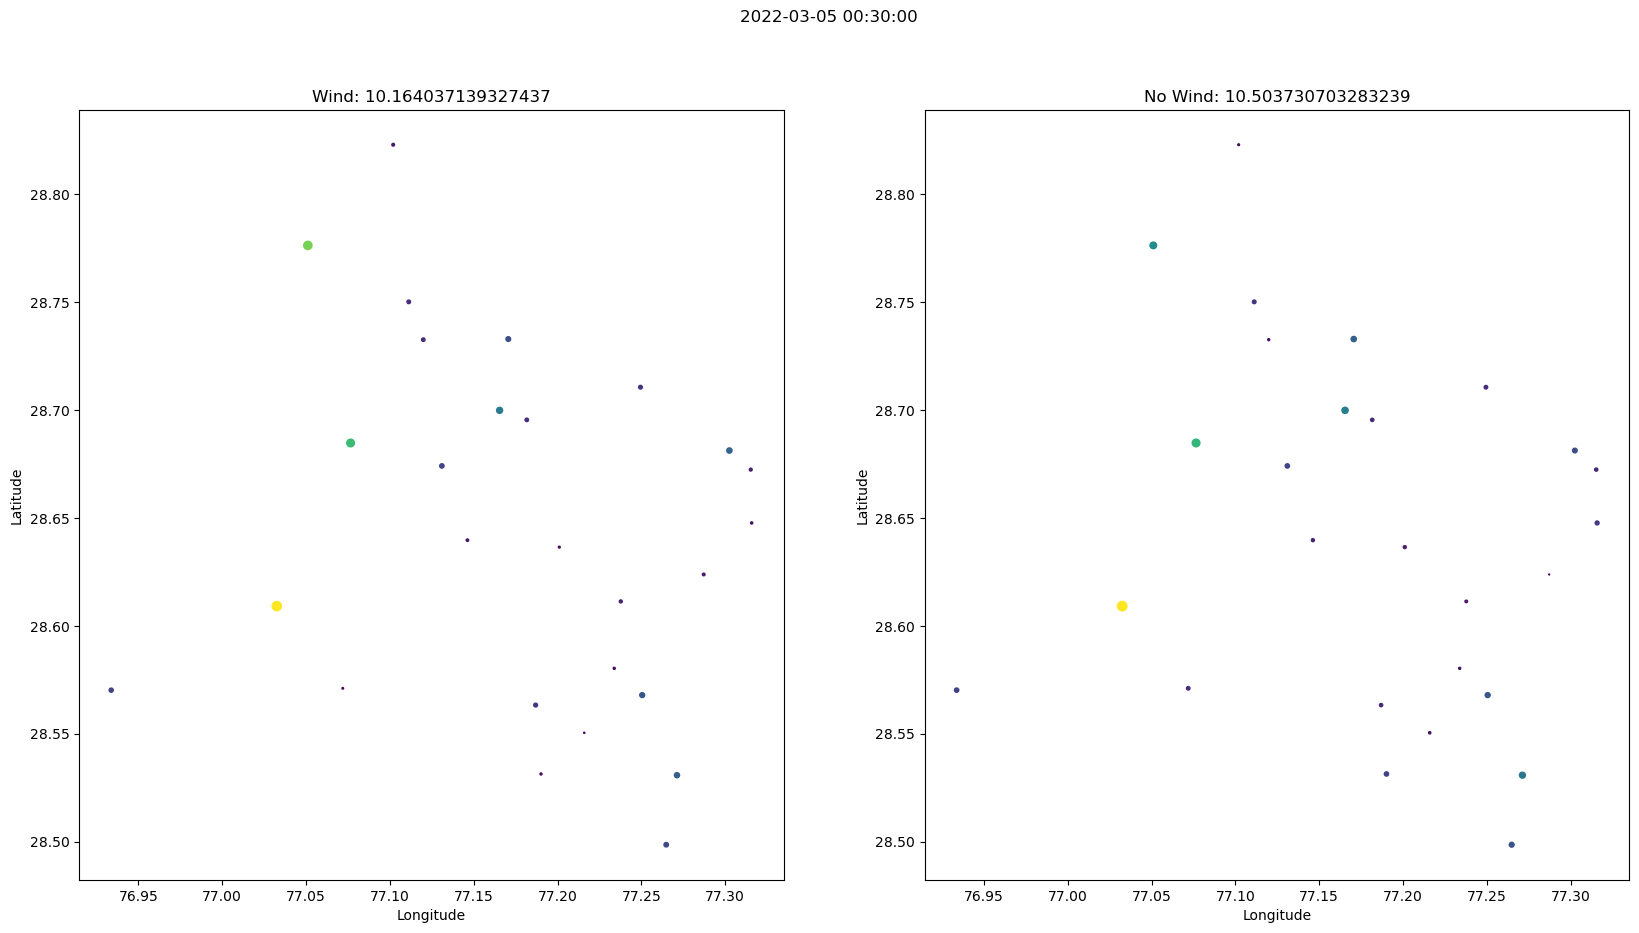

Timestamp: 2022-03-07 00:30:00
No Wind RMSE:  30.876973015921457
Wind RMSE:  30.610827037266322


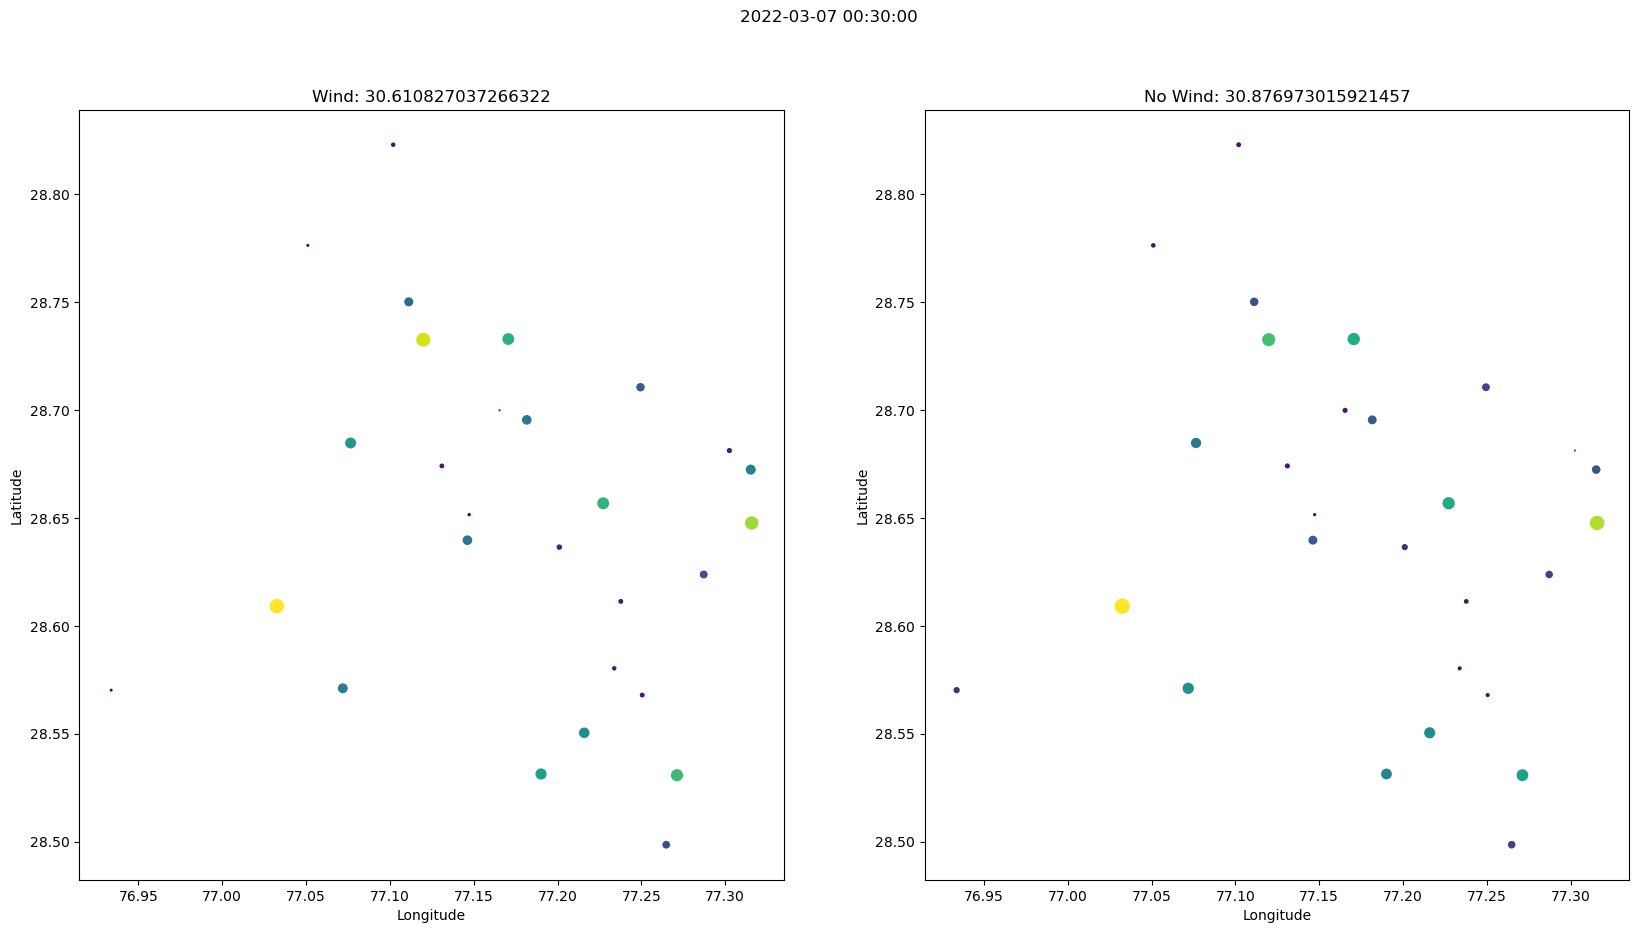

Timestamp: 2022-03-09 00:30:00
No Wind RMSE:  31.099743547110723
Wind RMSE:  28.231488852665343


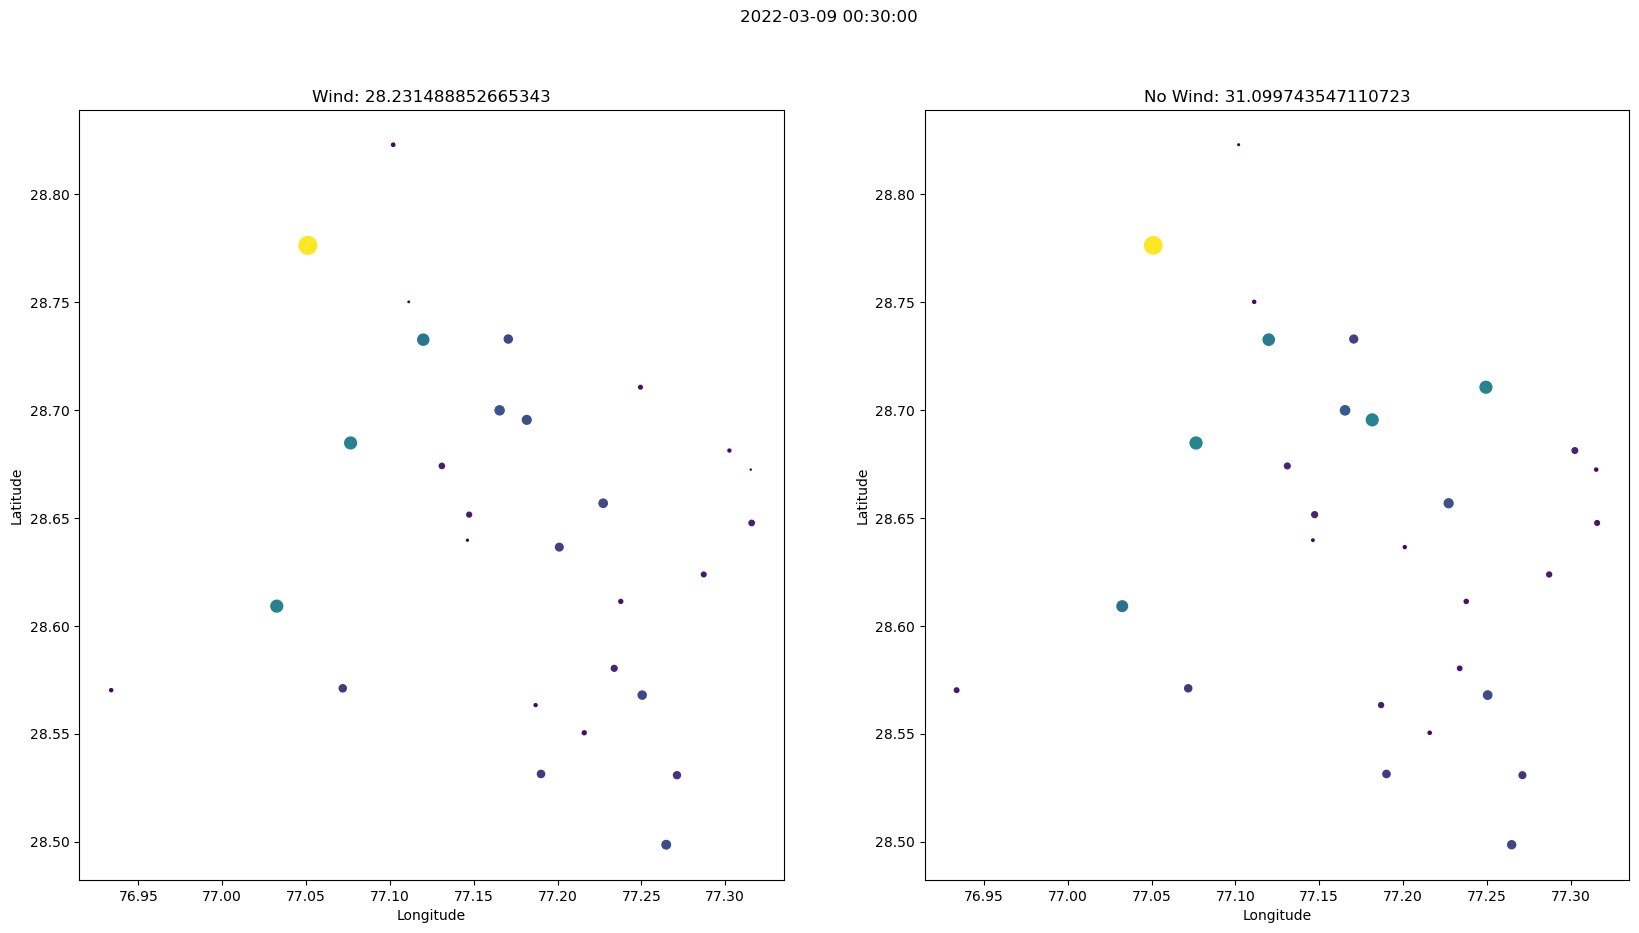

Timestamp: 2022-03-11 00:30:00
No Wind RMSE:  26.615207803660425
Wind RMSE:  20.446411264353785


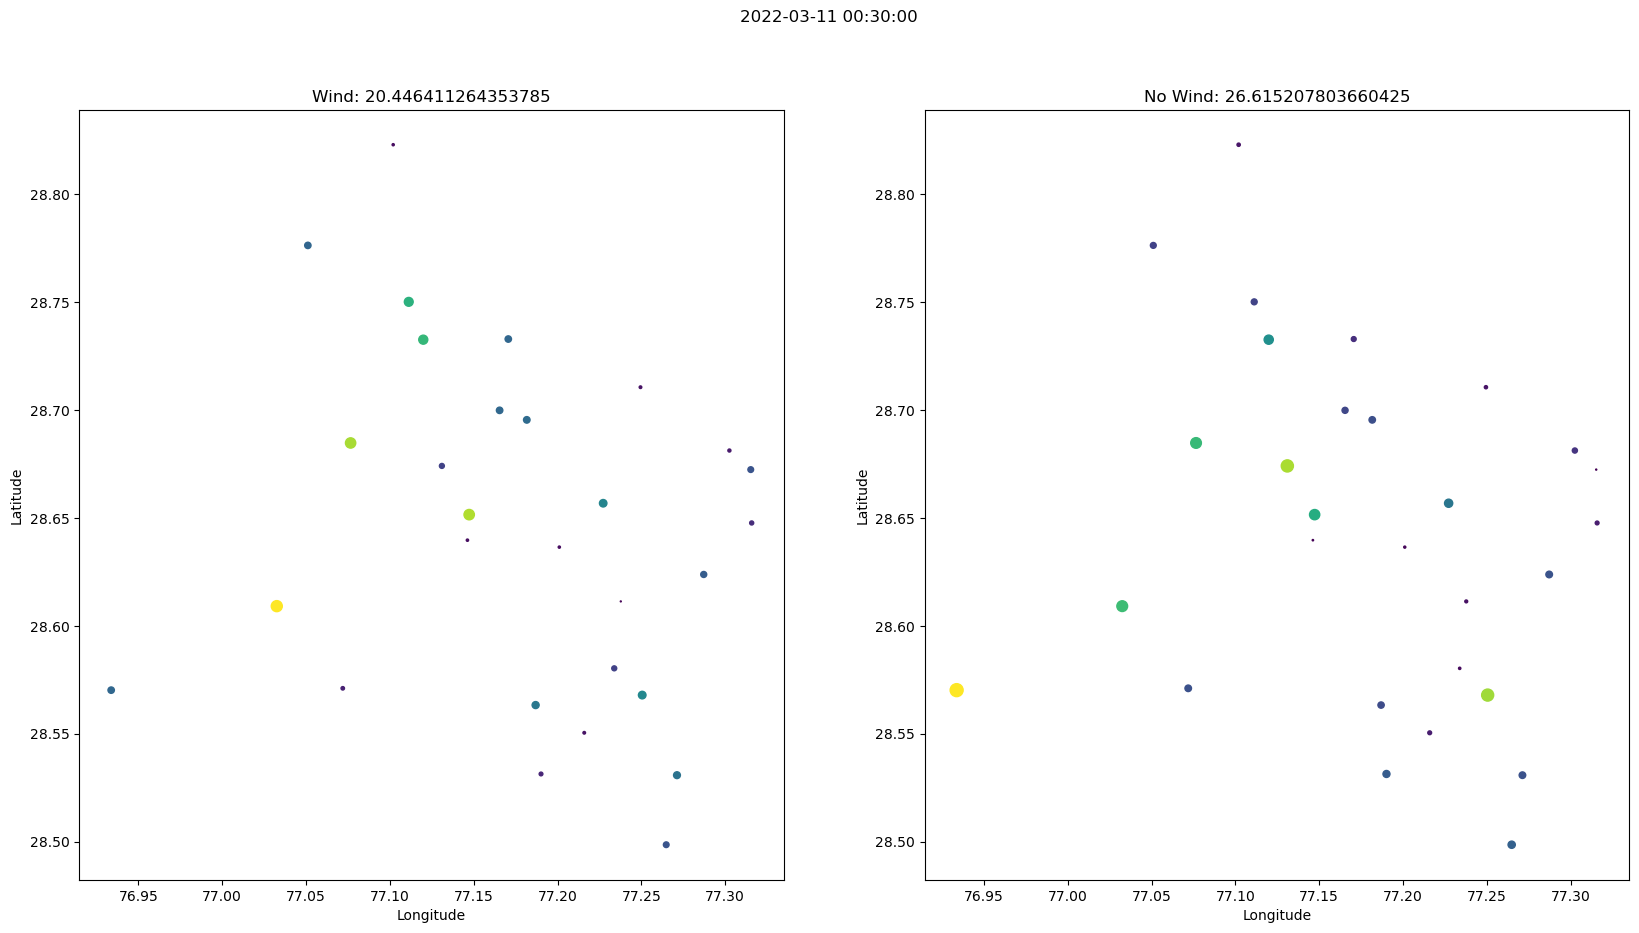

Timestamp: 2022-03-13 00:30:00
No Wind RMSE:  36.05952425356264
Wind RMSE:  33.84344595449942


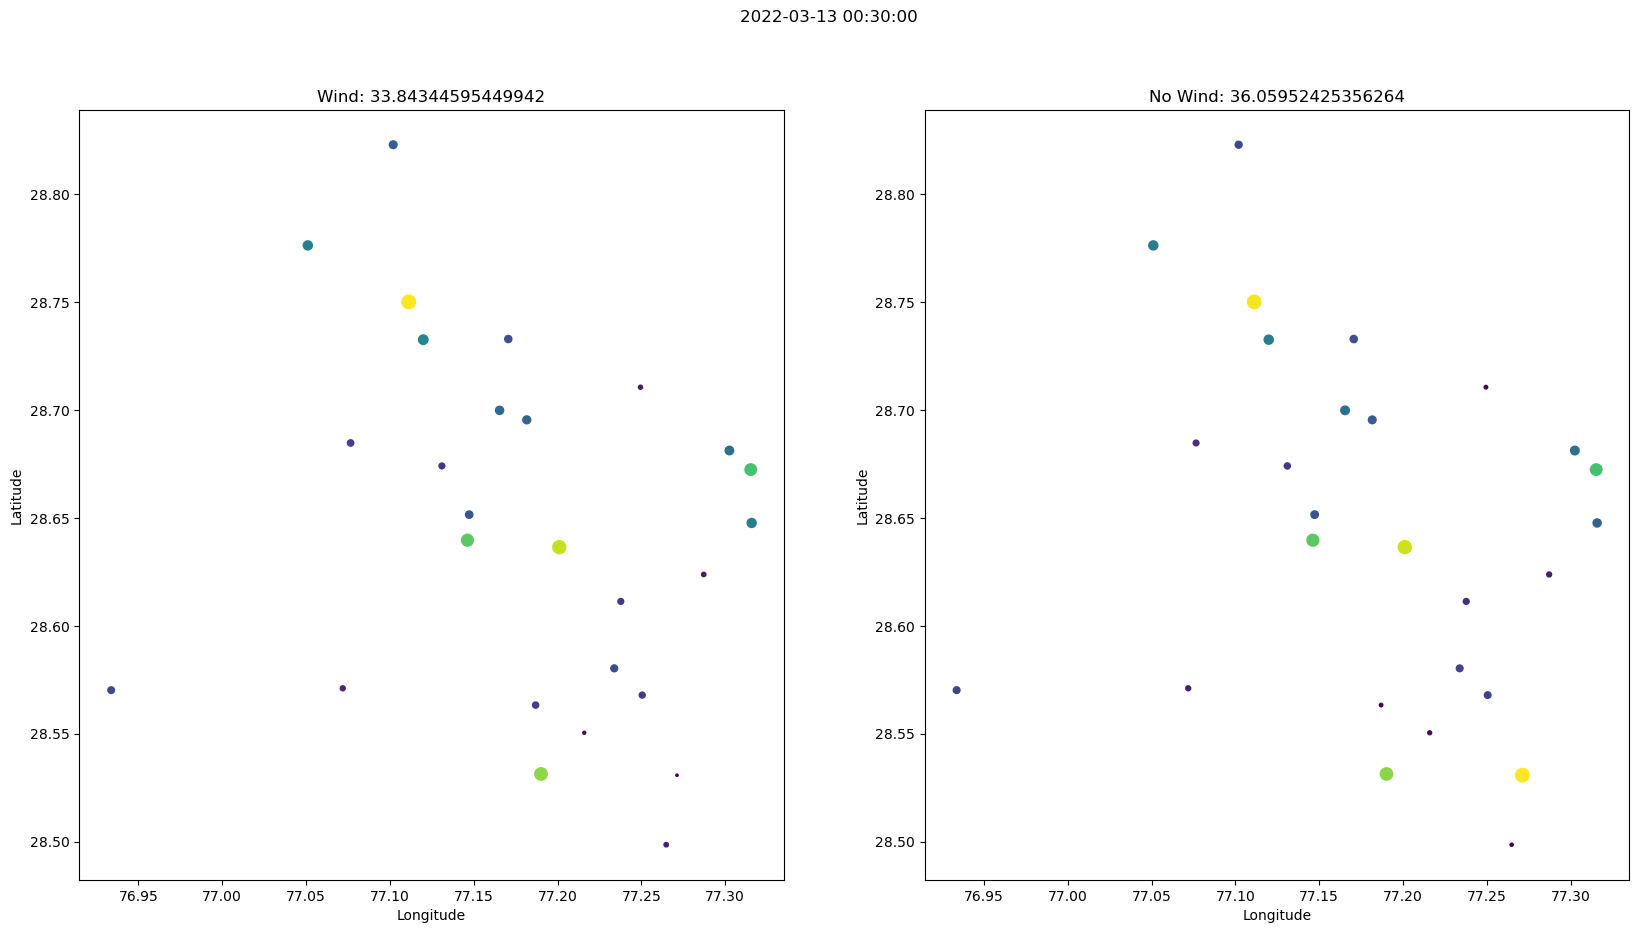

Timestamp: 2022-03-15 00:30:00
No Wind RMSE:  33.92284556797573
Wind RMSE:  33.72812461853027


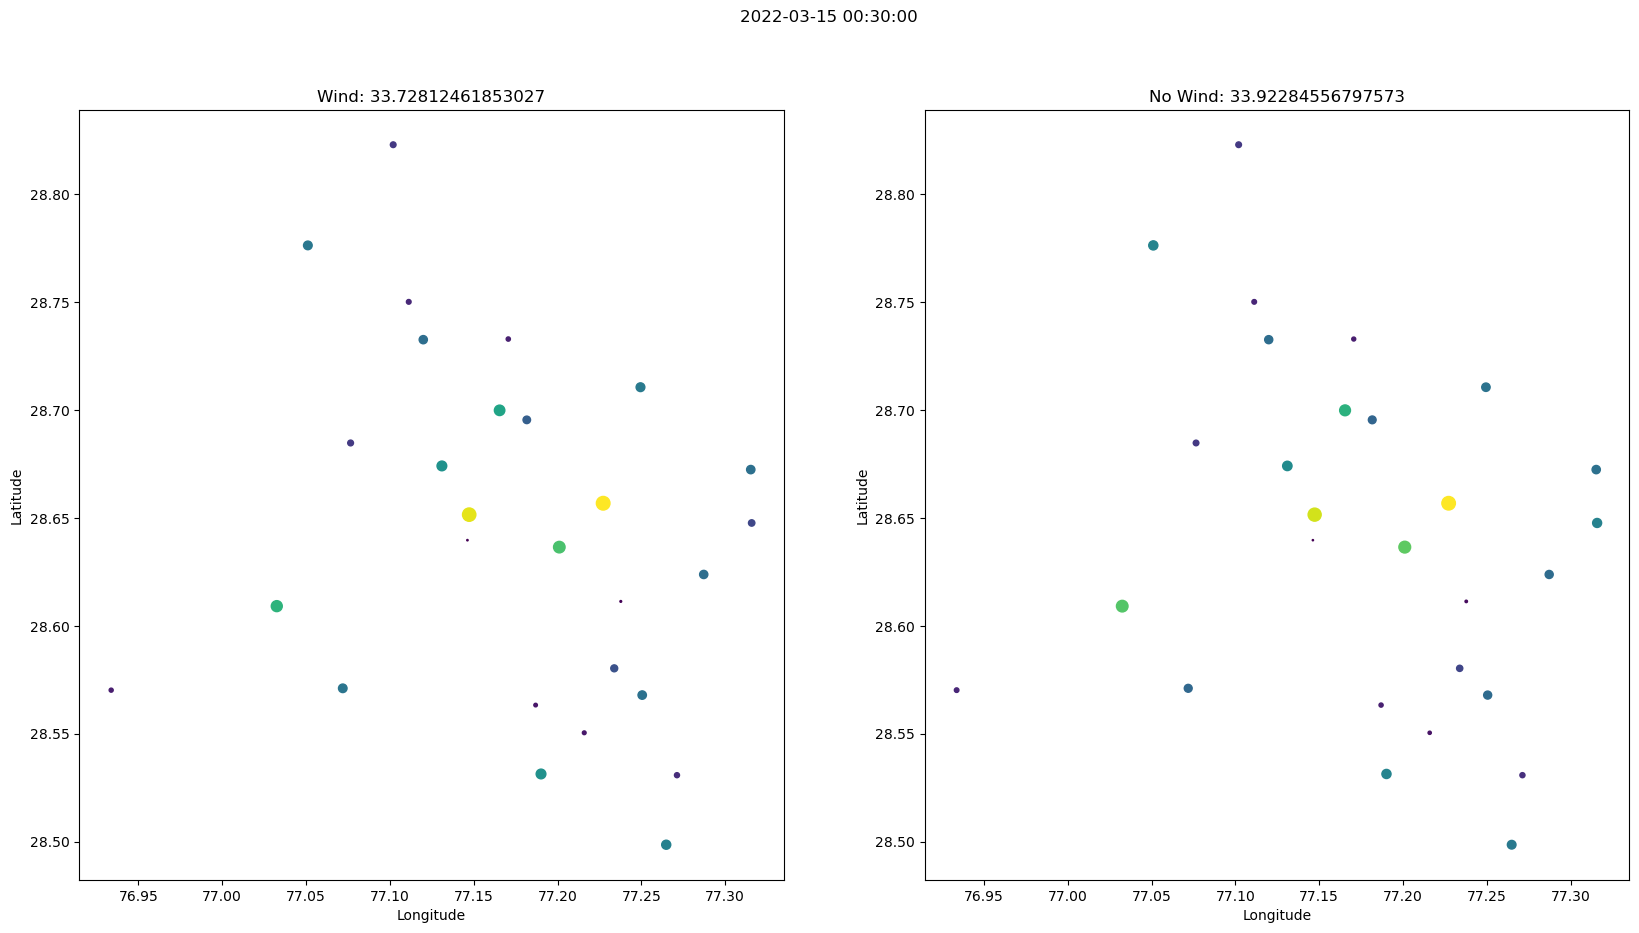

Timestamp: 2022-03-17 00:30:00
No Wind RMSE:  27.641837942189184
Wind RMSE:  32.171213741960194


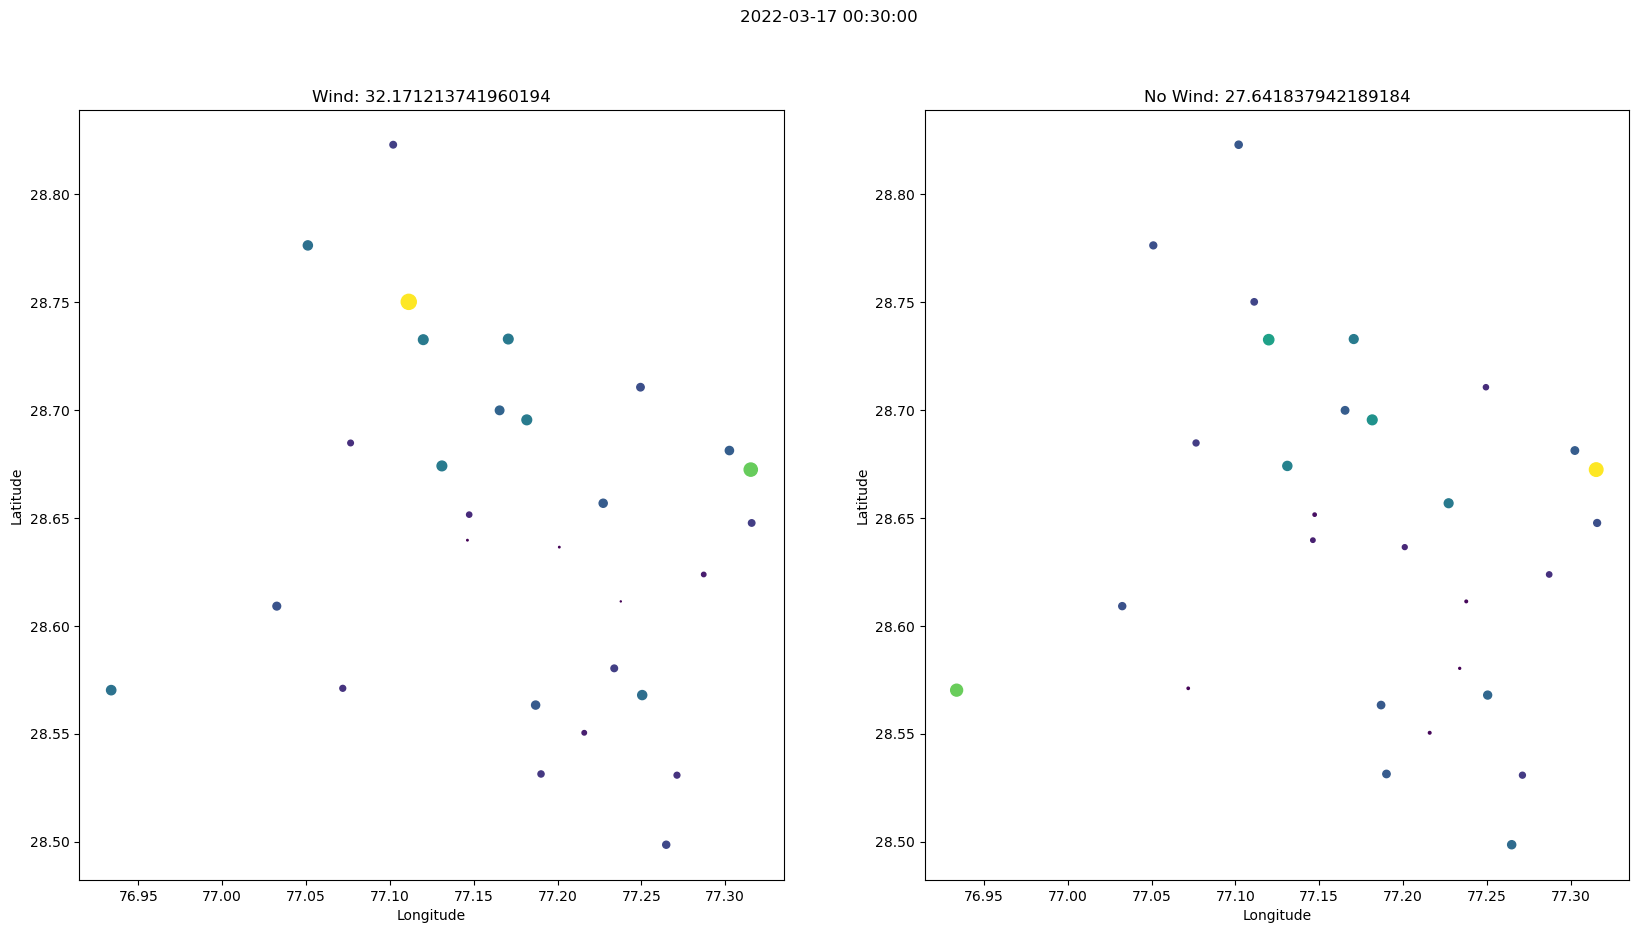

Timestamp: 2022-03-19 00:30:00
No Wind RMSE:  26.98827630502206
Wind RMSE:  30.898898937084056


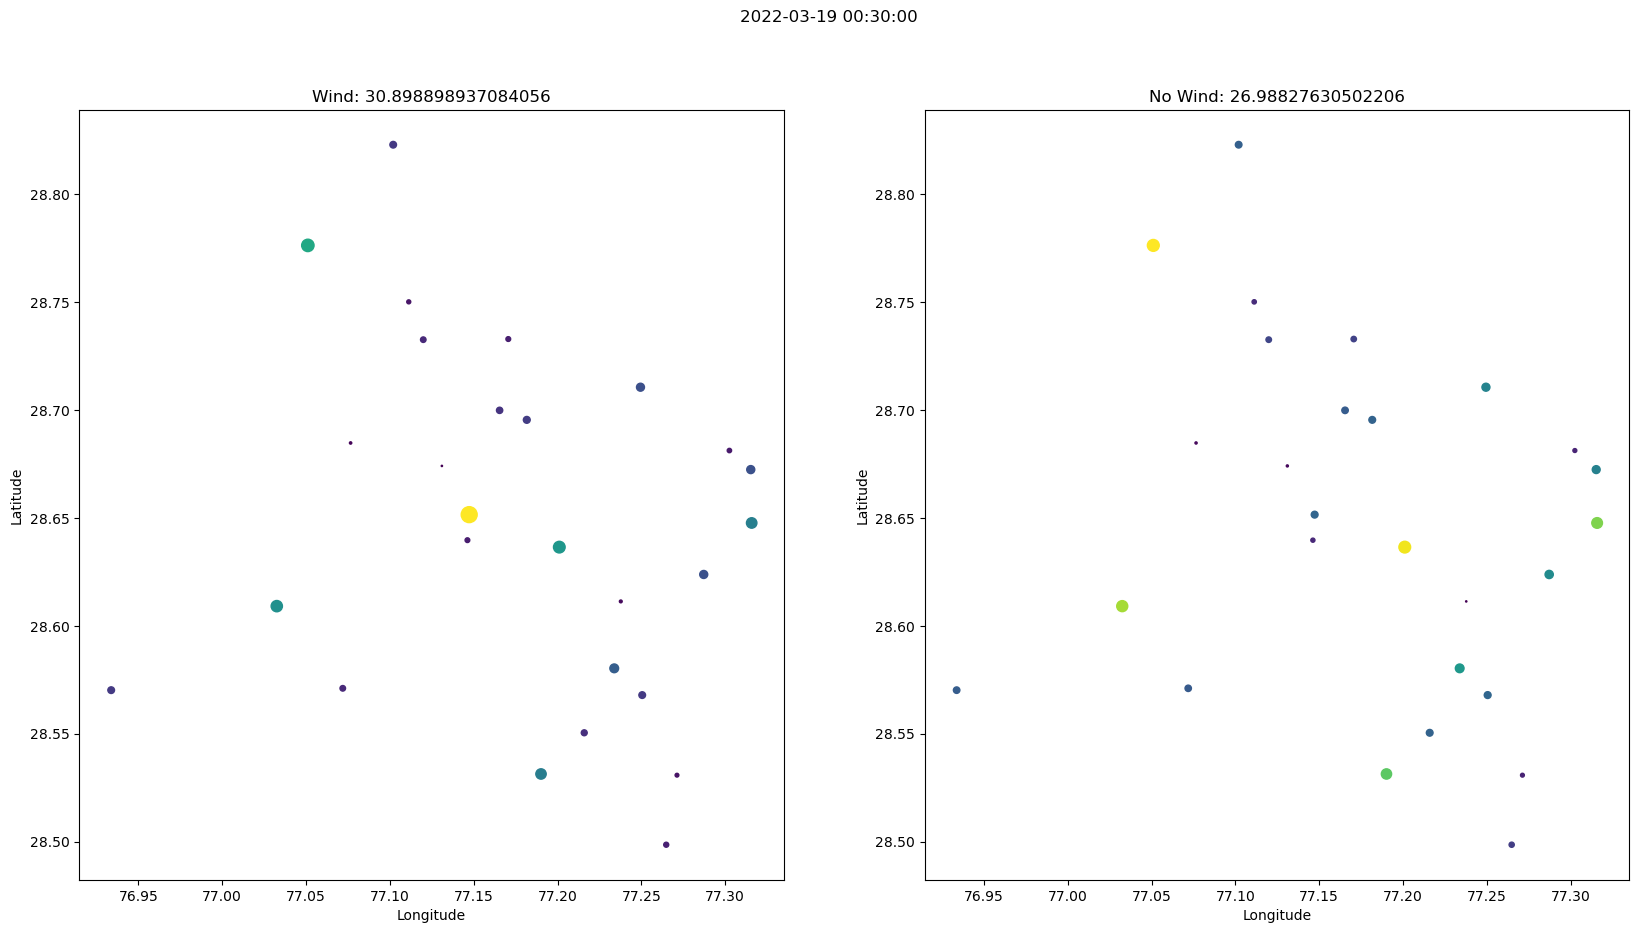

Timestamp: 2022-03-21 00:30:00
No Wind RMSE:  38.143977301461355
Wind RMSE:  45.40597316196987


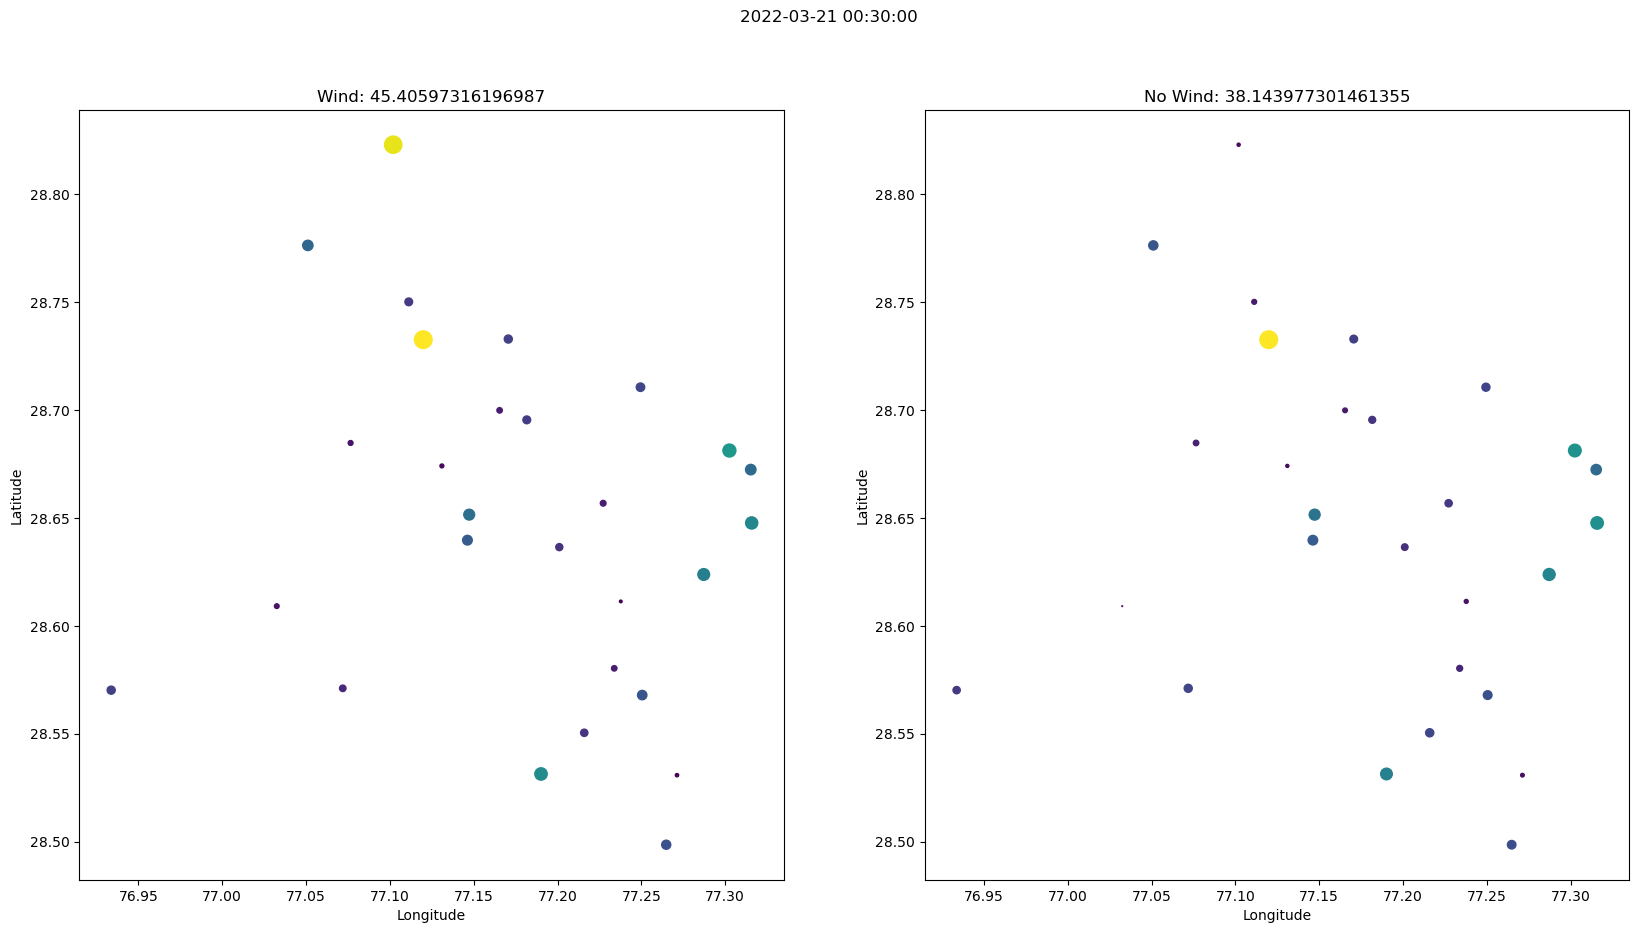

Timestamp: 2022-03-23 00:30:00
No Wind RMSE:  26.445291453394397
Wind RMSE:  29.32006441313645


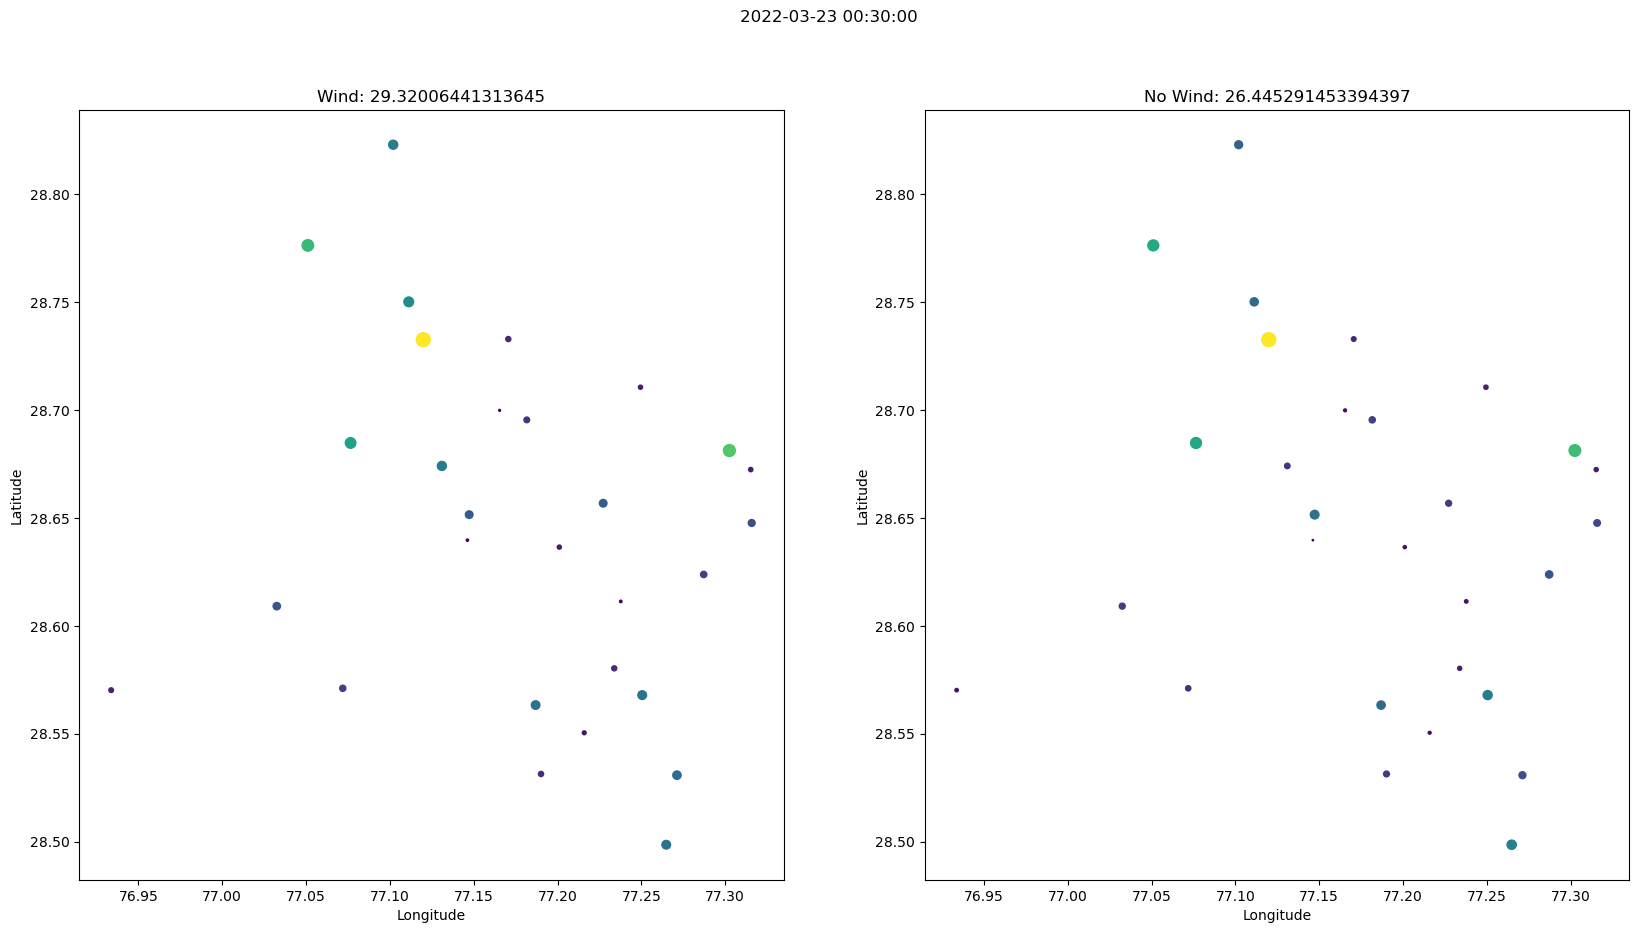

Timestamp: 2022-03-25 00:30:00
No Wind RMSE:  33.36416399920428
Wind RMSE:  39.57633265742549


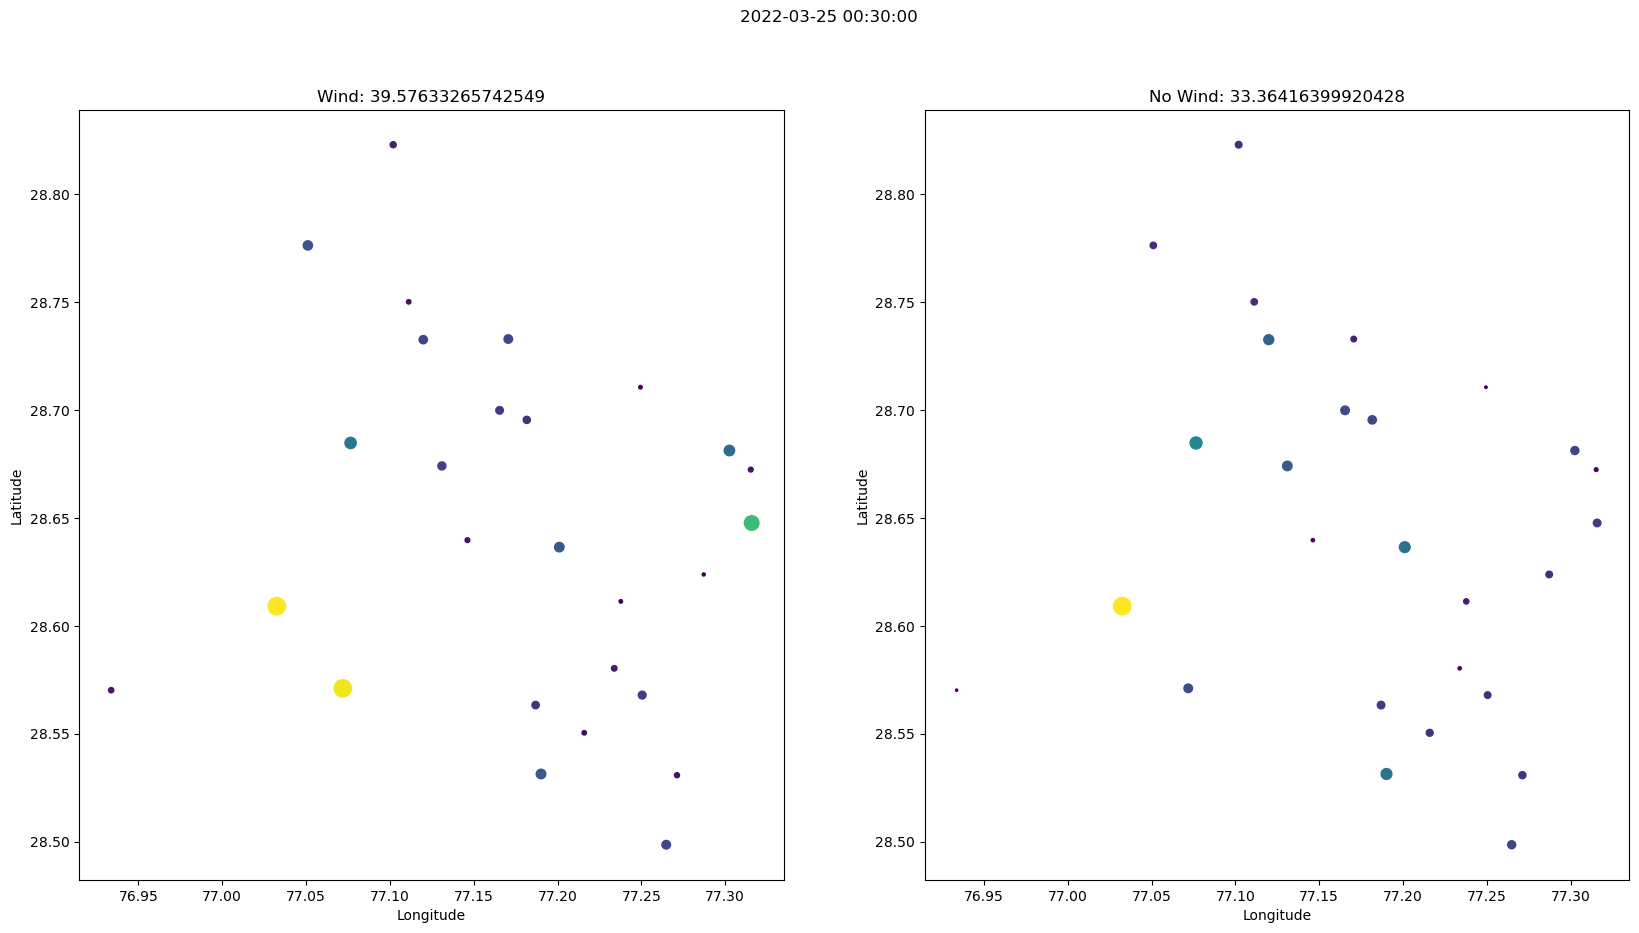

Timestamp: 2022-03-27 00:30:00
No Wind RMSE:  32.915885360152636
Wind RMSE:  34.033617938006365


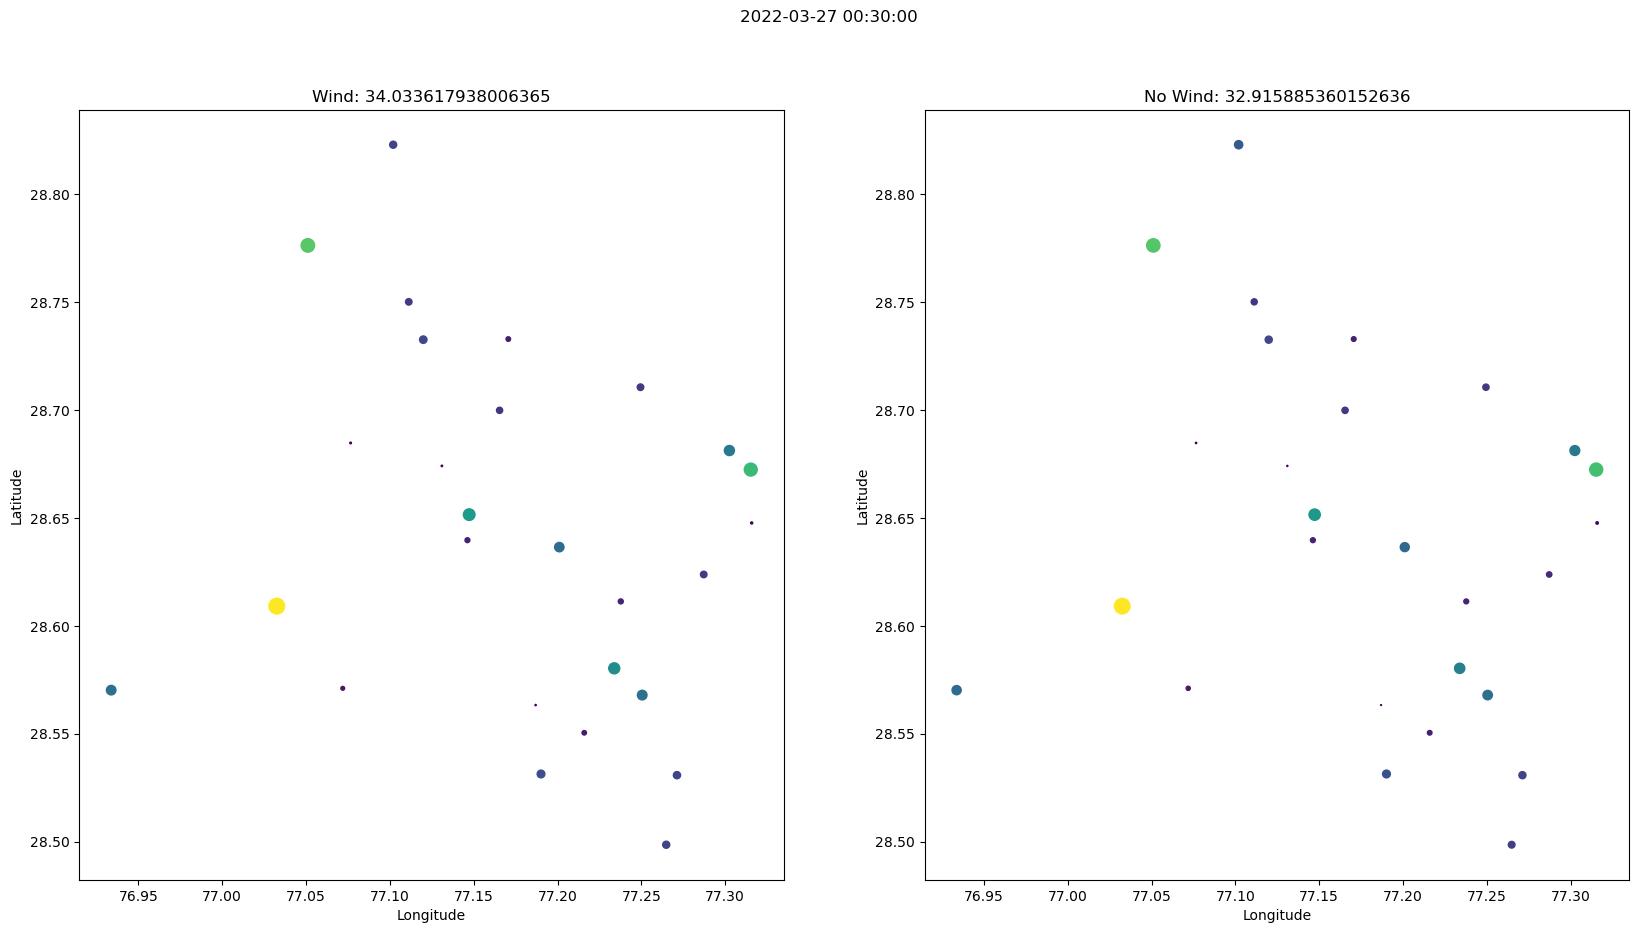

Timestamp: 2022-03-29 00:30:00
No Wind RMSE:  50.18902535274111
Wind RMSE:  51.31105436127761


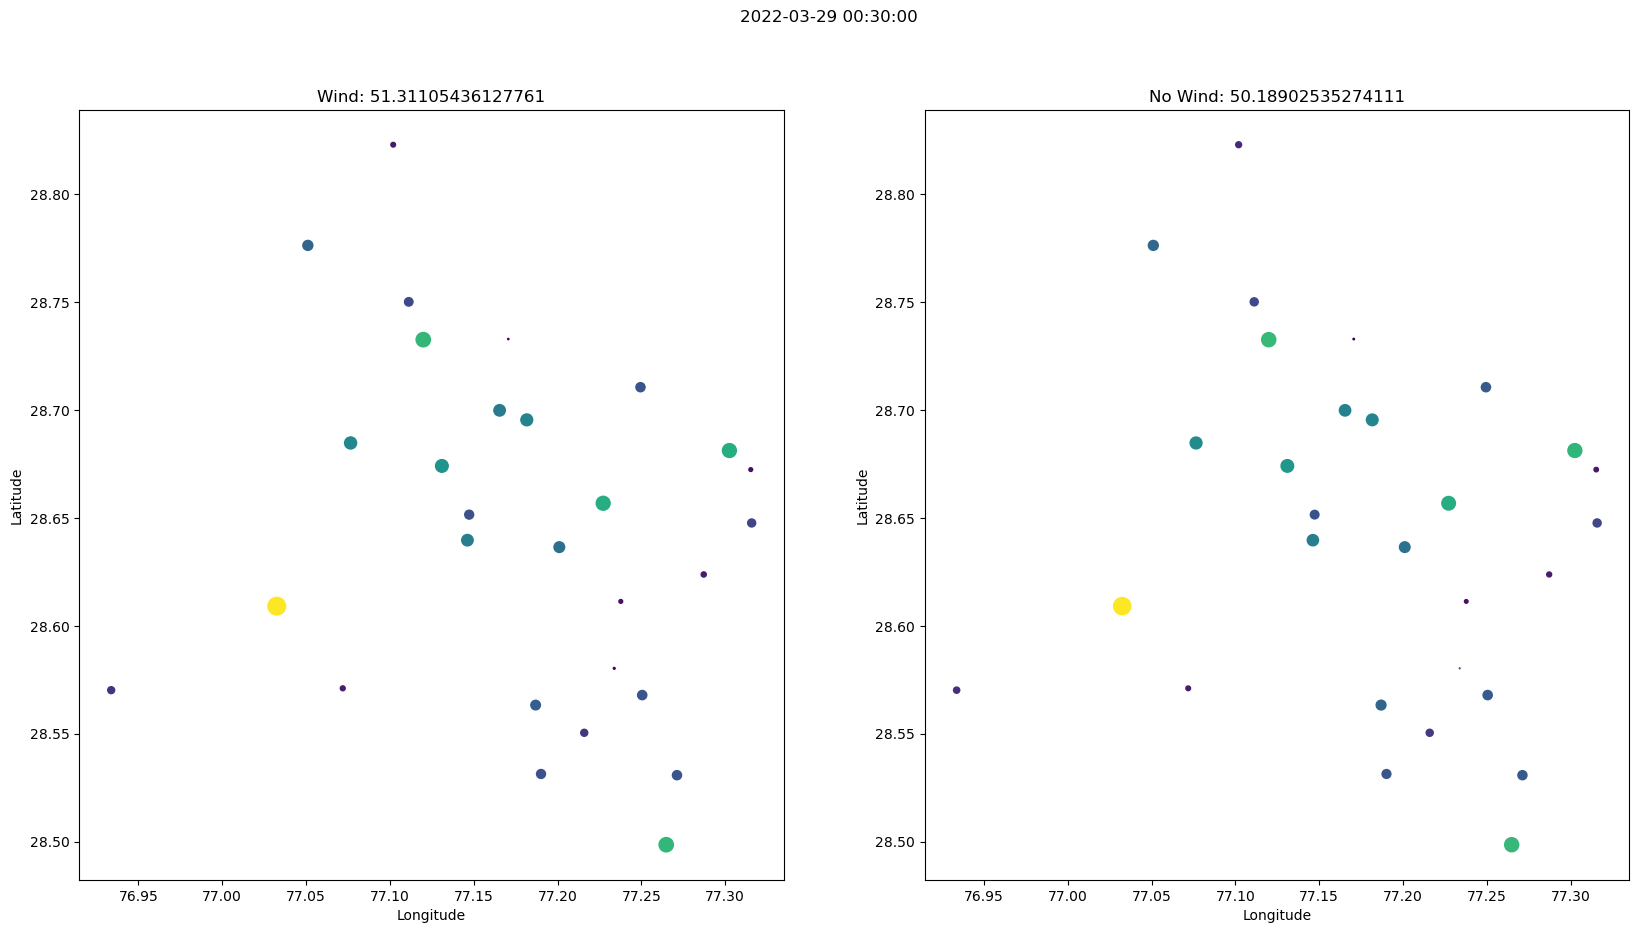

Timestamp: 2022-03-31 00:30:00
No Wind RMSE:  73.80068606596727
Wind RMSE:  79.14652369572566


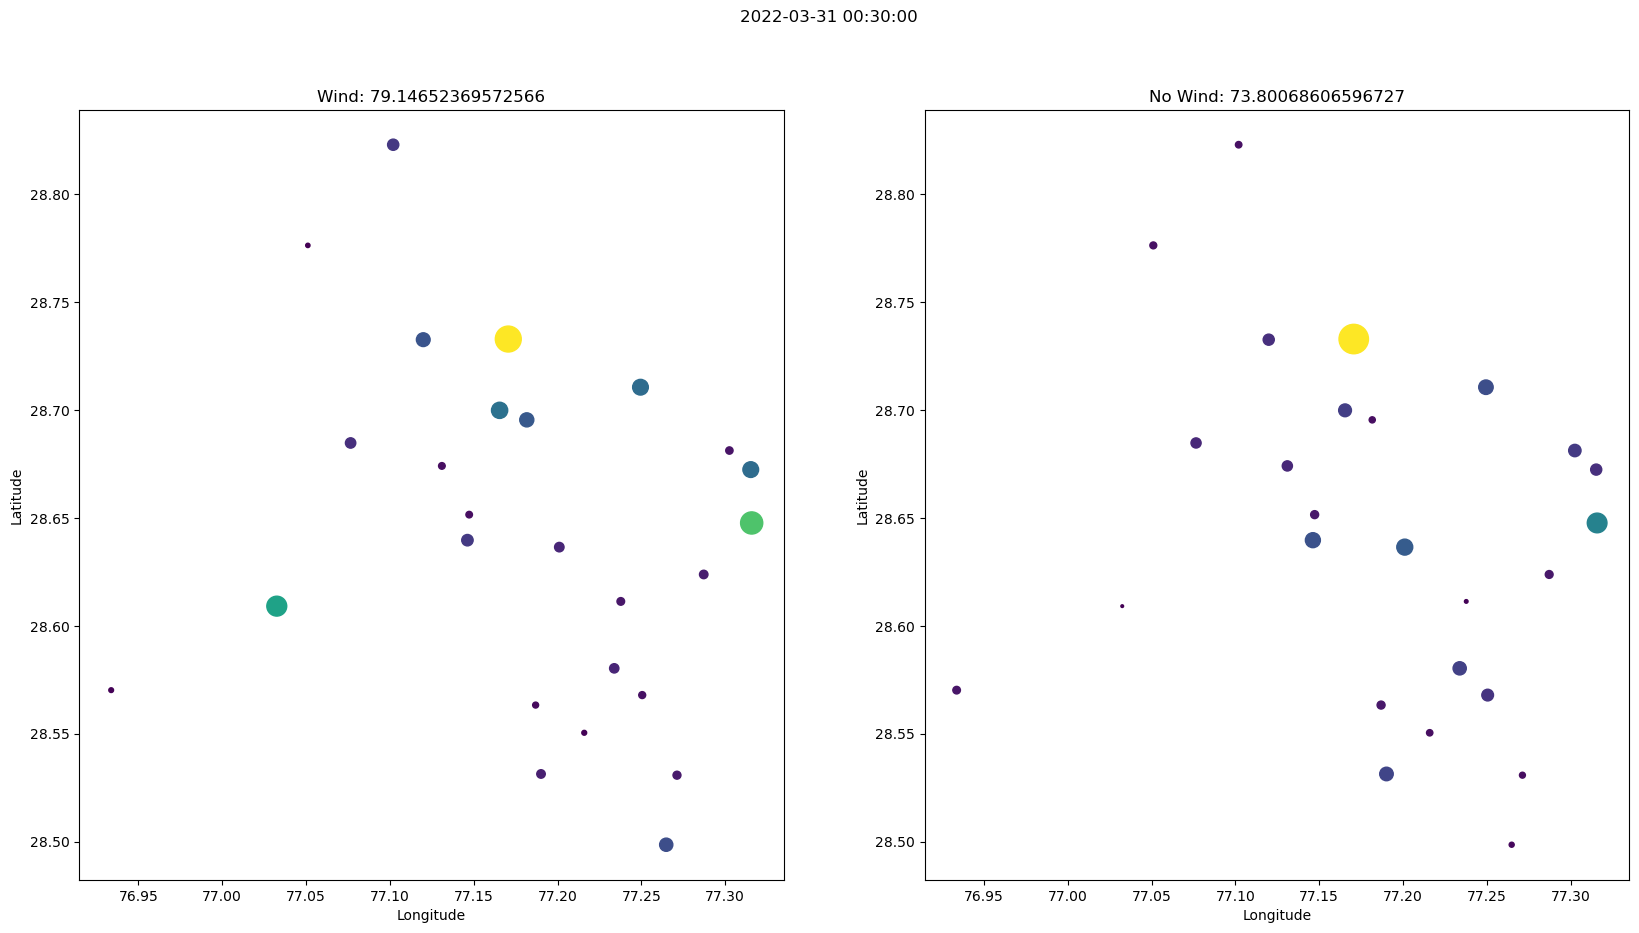

In [5]:
p = pd.date_range(start='2022-03-01 00:30:00', end='2022-04-01 00:30:00', freq = '2D').to_frame(name='dates')

for i in p['dates']:
    d_i = loocv(i)
    d_i = pd.DataFrame(d_i)
    print("Timestamp:", i)
    print('No Wind RMSE: ', np.mean(d_i['no wind rmse']))
    print('Wind RMSE: ', np.mean(d_i['wind rmse']))
    
    plt.figure(figsize = (20,10))
    plt.suptitle(i)
    plt.subplot(1, 2, 1)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['wind rmse'], c = d_i['wind rmse'])
    title = 'Wind: ' + str(np.mean(d_i['wind rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 2, 2)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['no wind rmse'], c = d_i['no wind rmse'])
    title = 'No Wind: ' + str(np.mean(d_i['no wind rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [7]:
def rf_loocv(timestamp):
    dataframe = []
    d = df[df["time"]==timestamp]
    station = d['station'].unique()
    for i in station:
        test = d[d['station'] == i]
        test = test[['latitude', 'longitude', 'WS', 'WD', 'PM2.5']]
        
        train = d[d['station'] != i]
        train = train[['latitude', 'longitude', 'WS', 'WD', 'PM2.5']]
        
        #No Wind
        X_train = train[['latitude', 'longitude']]
        X_test = test[['latitude', 'longitude']]
        y_train = train['PM2.5']
        y_test = test['PM2.5']
        
        rf_model2 = RandomForestRegressor(n_estimators=1000, random_state=42)
        rf_model2.fit(X_train, y_train)
        nw_pred = rf_model2.predict(X_test)
        nw_rmse = np.sqrt((nw_pred - y_test)**2).tolist()[0]
        
        #Wind
        X_train = train[['latitude', 'longitude', 'WS', 'WD']]
        X_test = test[['latitude', 'longitude', 'WS', 'WD']]
        y_train = train['PM2.5']
        y_test = test['PM2.5']

        rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
        rf_model.fit(X_train, y_train)
        wind_pred = rf_model.predict(X_test)
        wind_rmse = np.sqrt((wind_pred - y_test)**2).tolist()[0]
             
        actual = y_test.tolist()[0]
        
        dataframe.append({
                            "node": i,
                            "lat": test.iloc[0]["latitude"],
                            "lon": test.iloc[0]["longitude"],
                            "WD": test.iloc[0]["WD"],
                            "WS": test.iloc[0]["WS"],
                            "wind rmse": wind_rmse,
                            "no wind rmse": nw_rmse,
                            "actual": actual,
                            "wind pred": wind_pred[0],
                            "no wind pred": nw_pred[0],
                           })
    return dataframe

Timestamp: 2022-03-01 00:30:00
No Wind RMSE:  23.369241428571392
Wind RMSE:  20.727251785714262


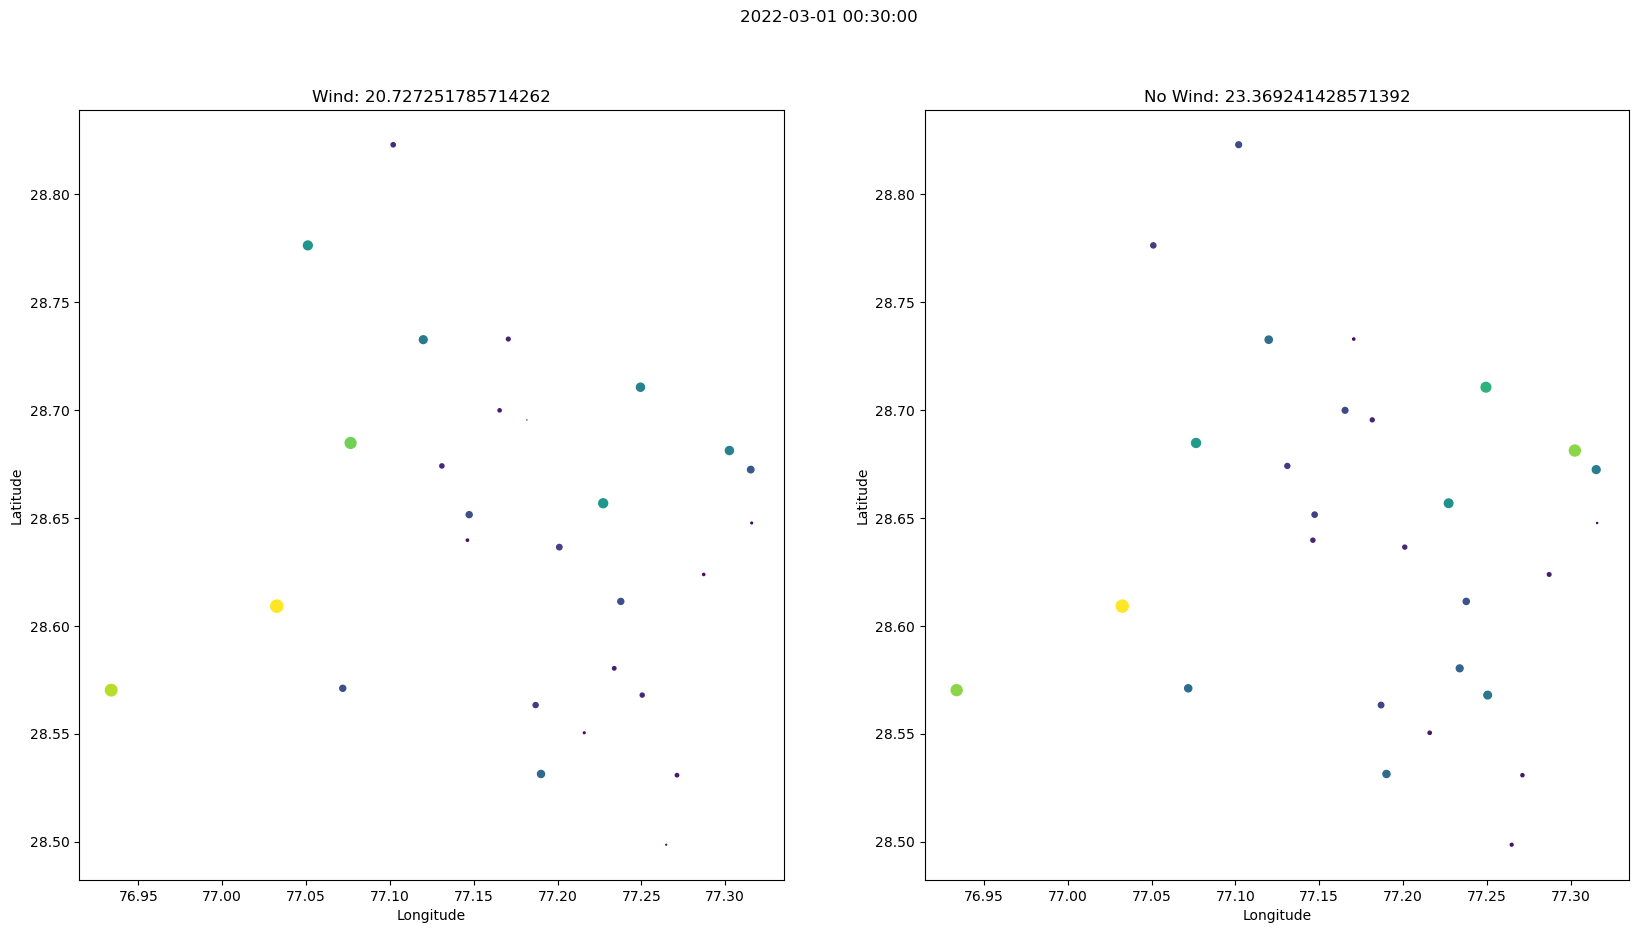

Timestamp: 2022-03-03 00:30:00
No Wind RMSE:  39.4543374074073
Wind RMSE:  43.93478629629639


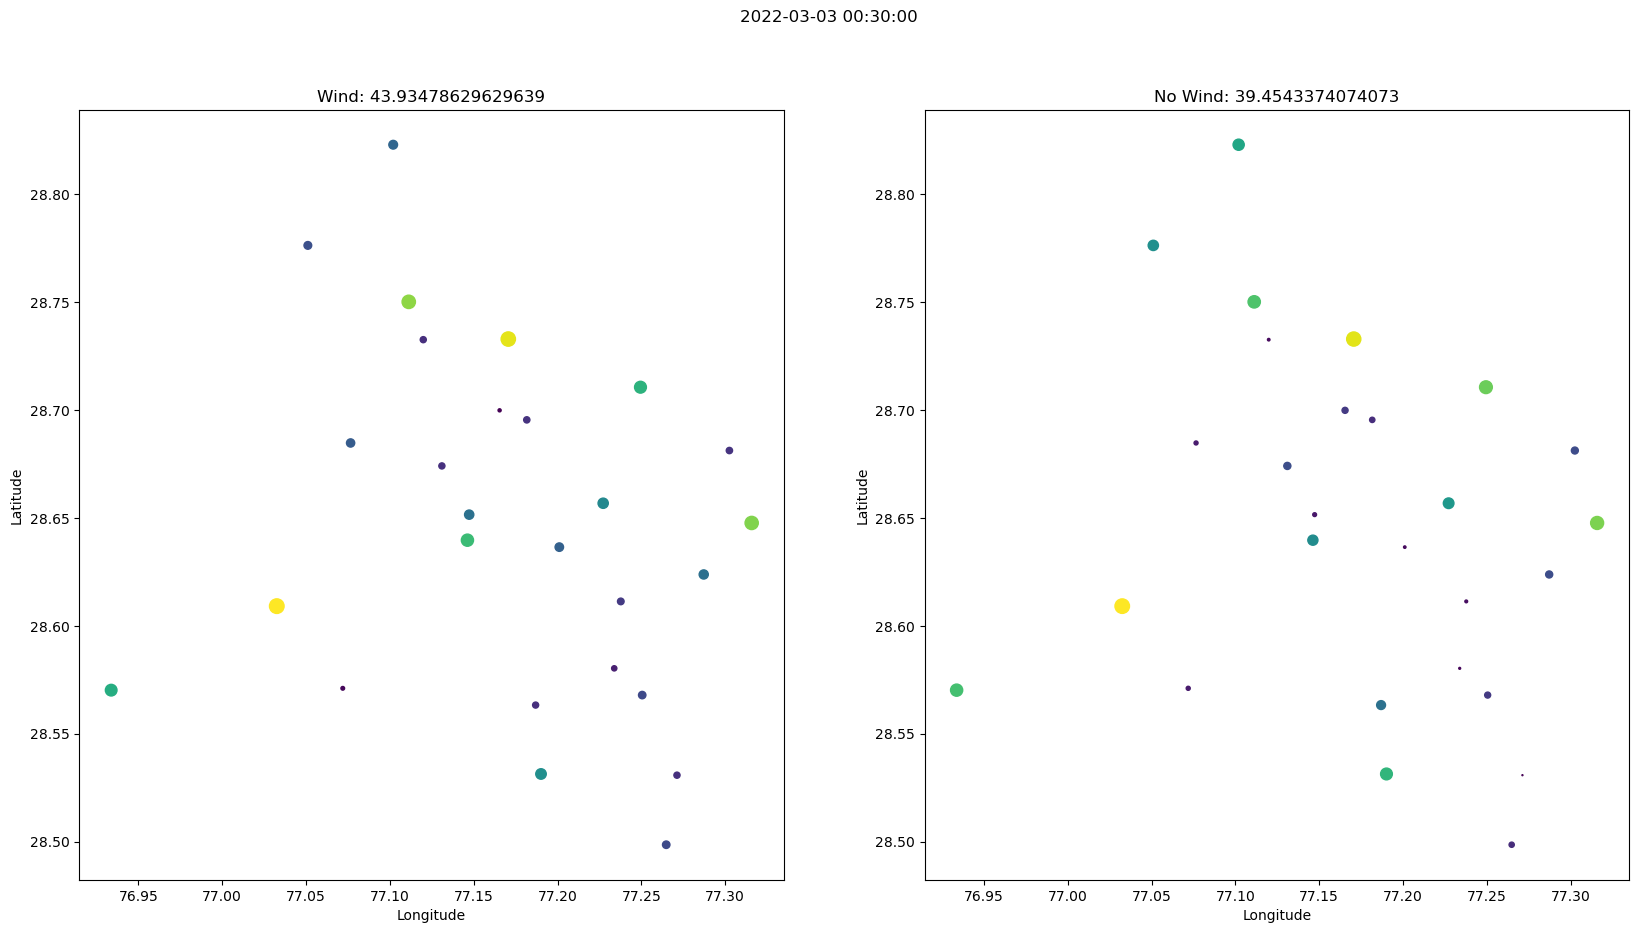

Timestamp: 2022-03-05 00:30:00
No Wind RMSE:  9.87640370370382
Wind RMSE:  9.390529629629718


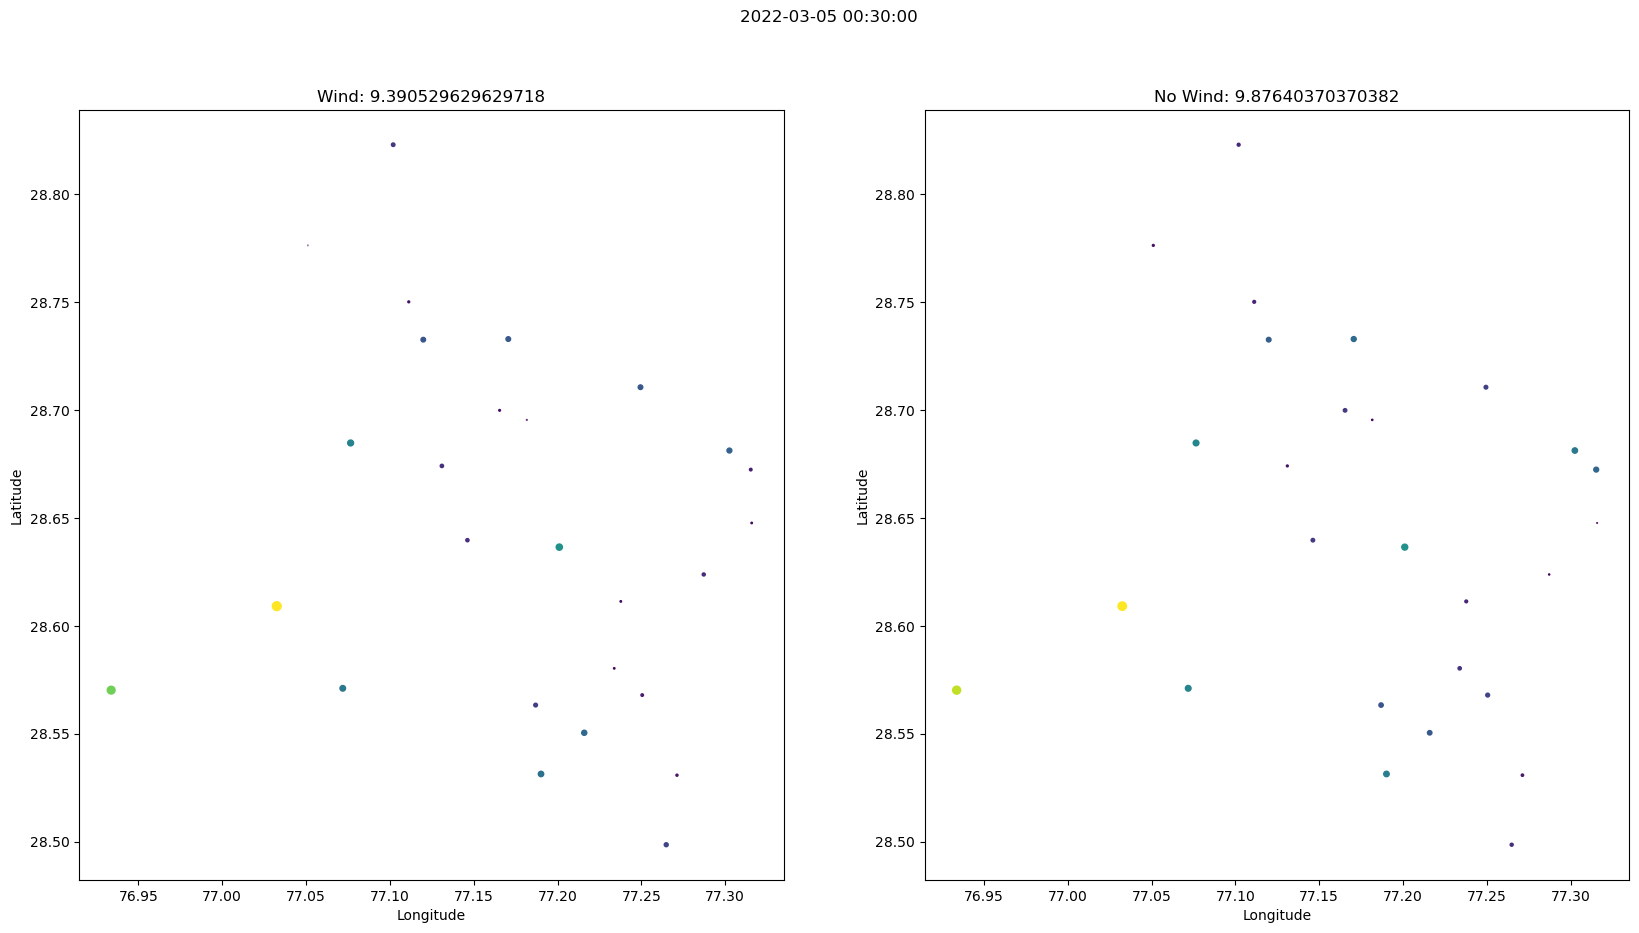

Timestamp: 2022-03-07 00:30:00
No Wind RMSE:  29.51520178571438
Wind RMSE:  29.641019285714357


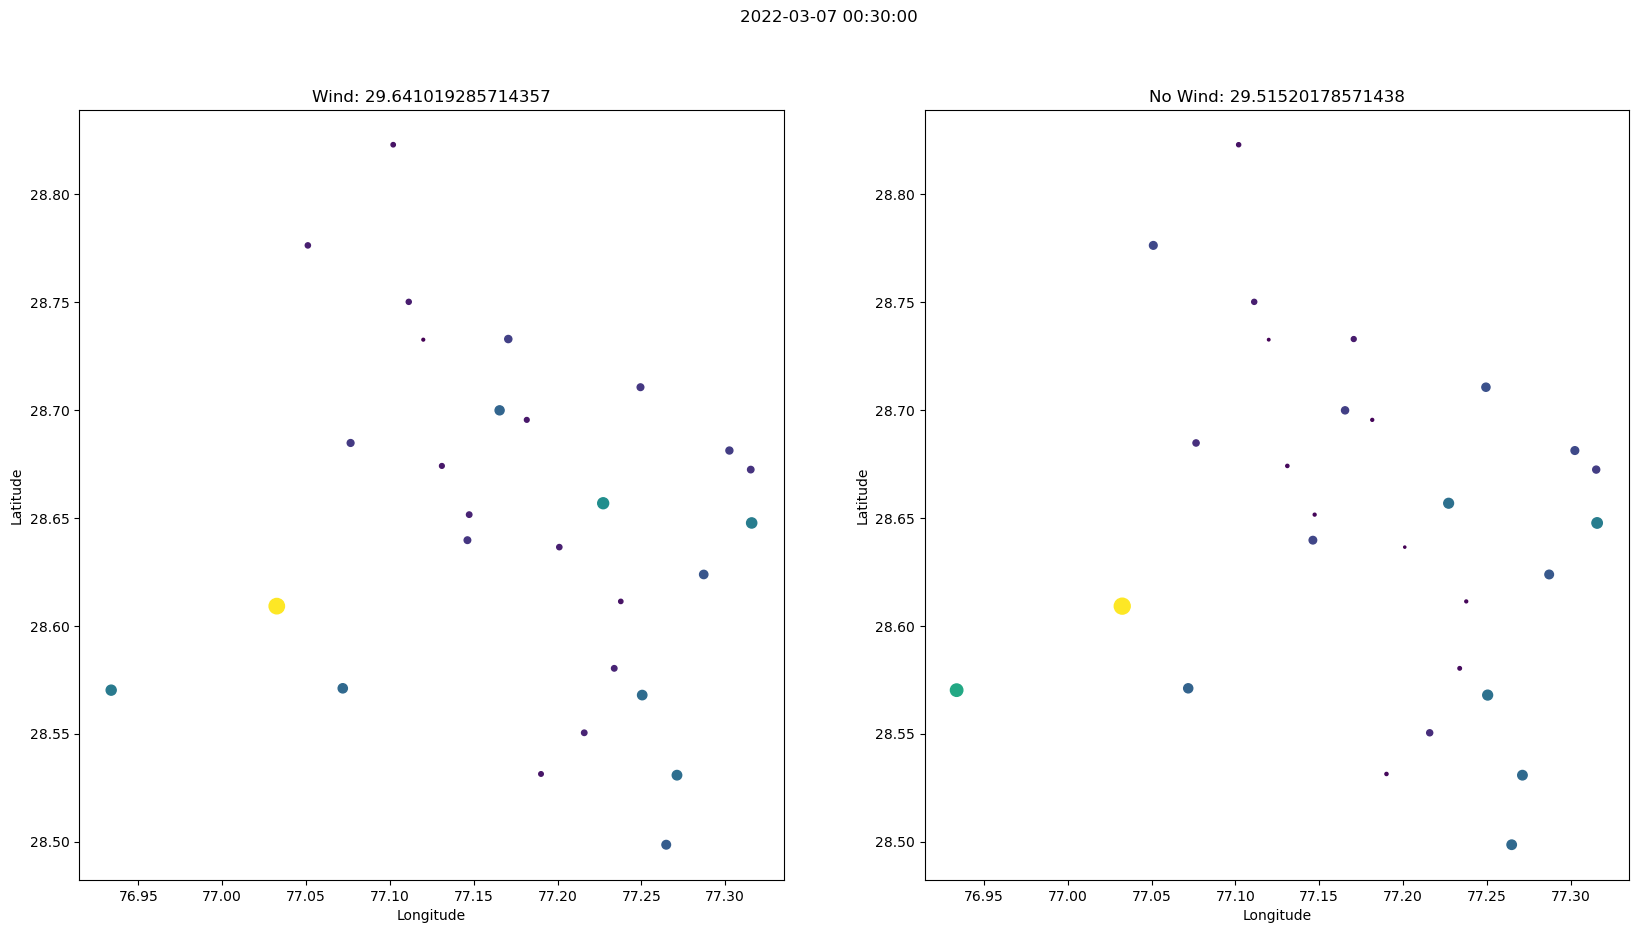

Timestamp: 2022-03-09 00:30:00
No Wind RMSE:  23.428482413793084
Wind RMSE:  25.495749999999994


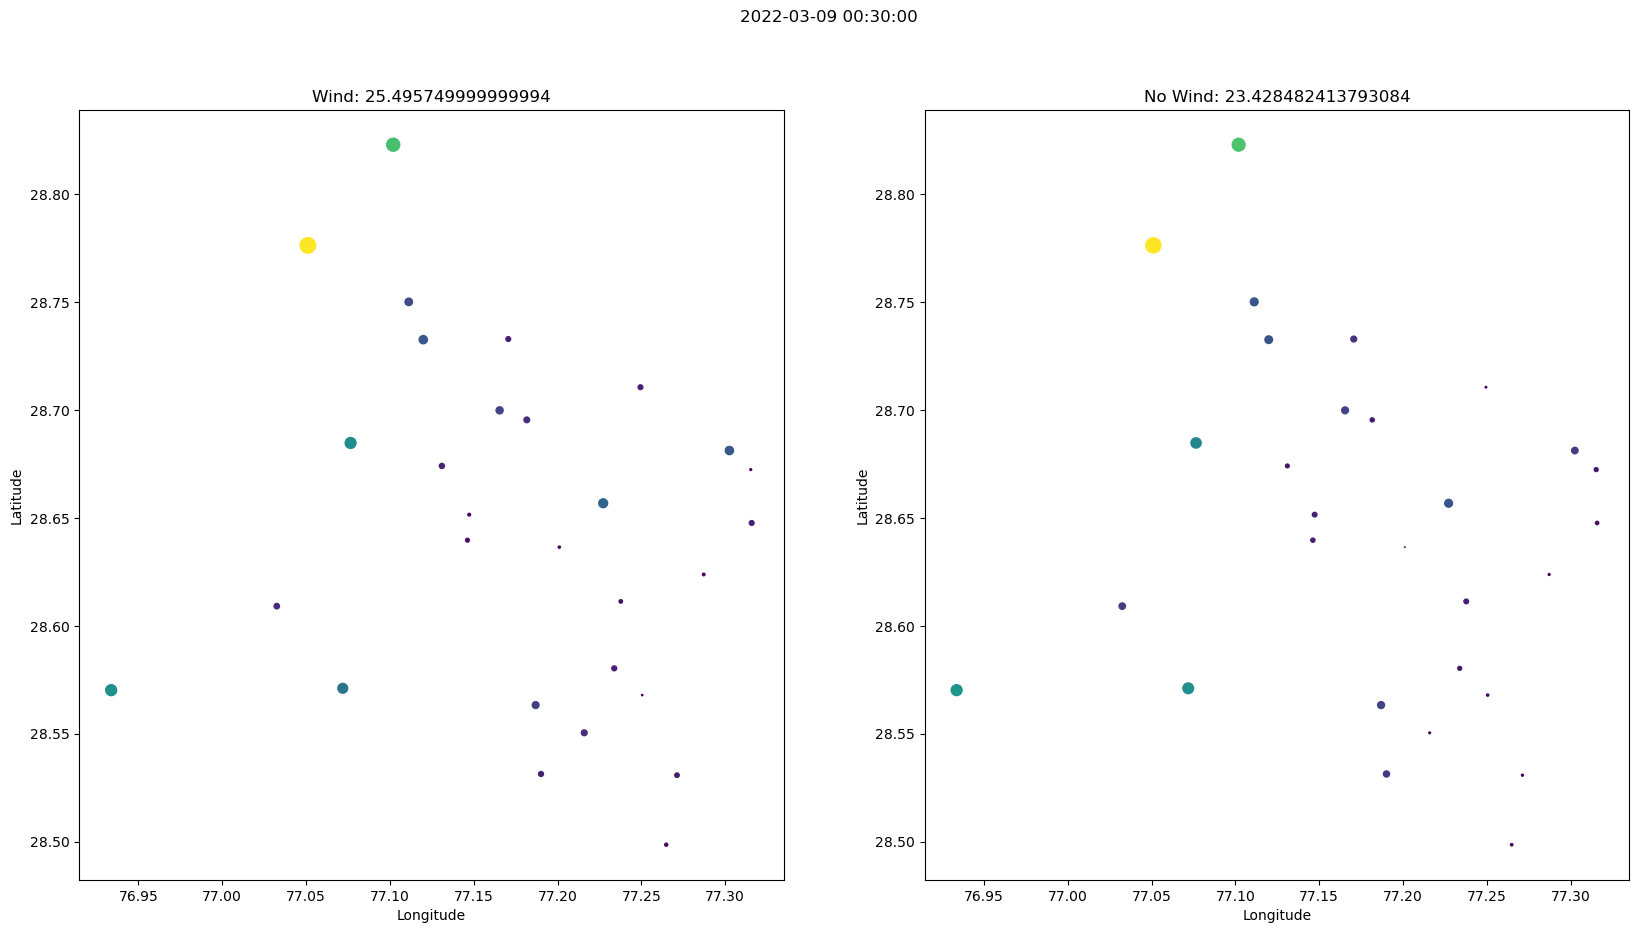

Timestamp: 2022-03-11 00:30:00
No Wind RMSE:  17.69652896551726
Wind RMSE:  15.649441379310376


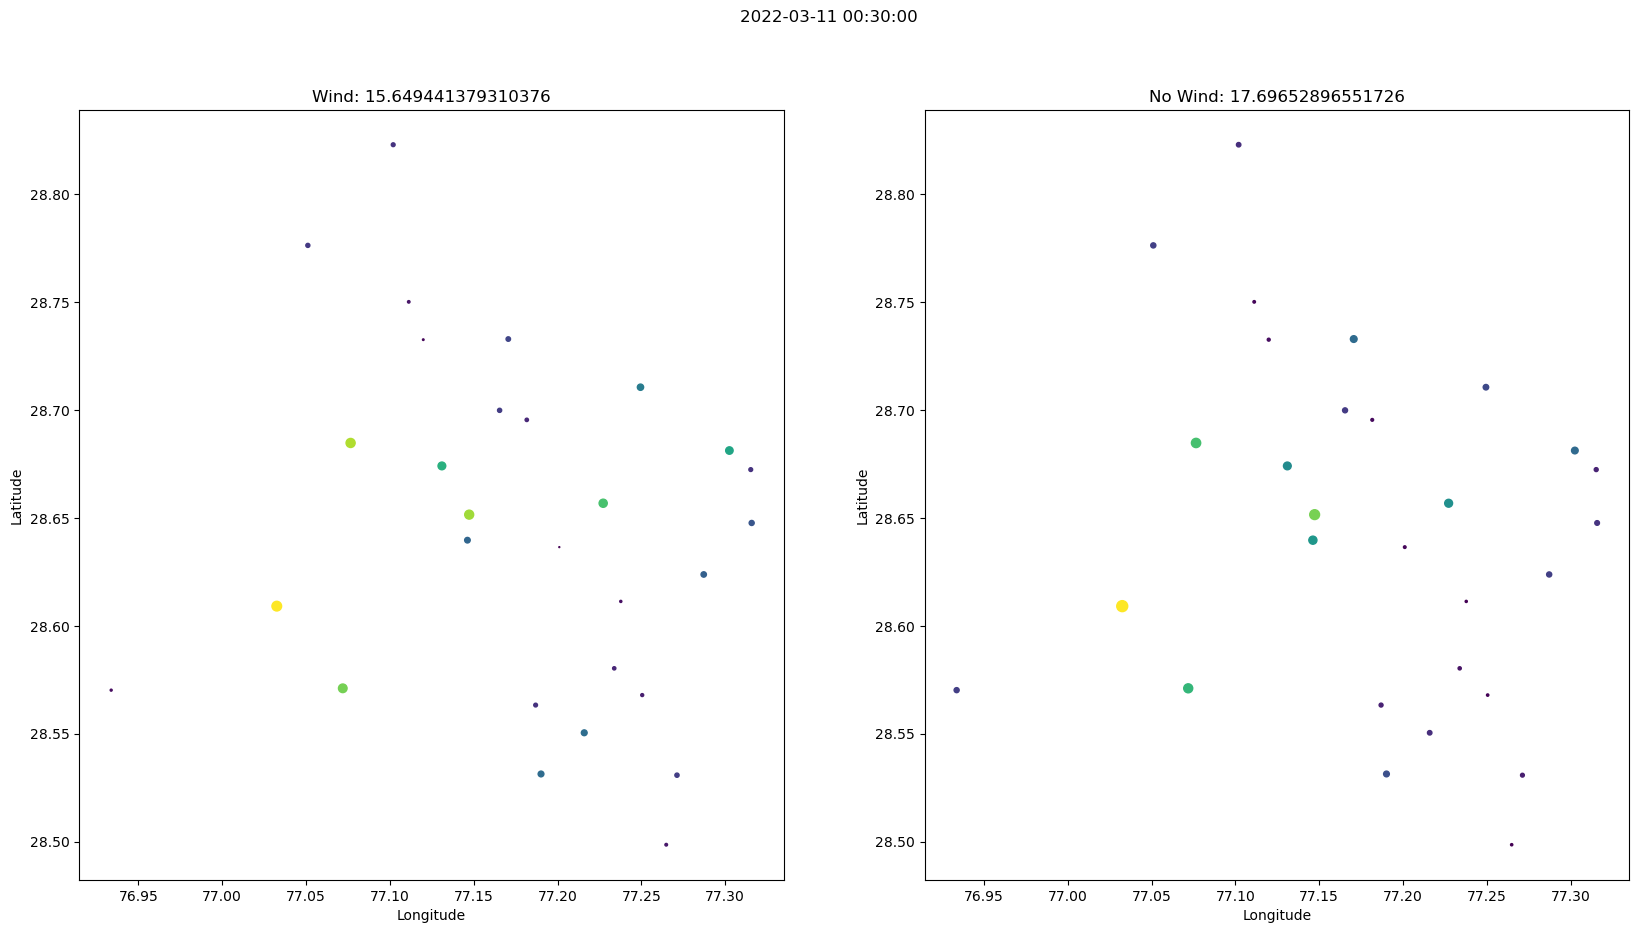

Timestamp: 2022-03-13 00:30:00
No Wind RMSE:  15.62896074074082
Wind RMSE:  17.302356666666753


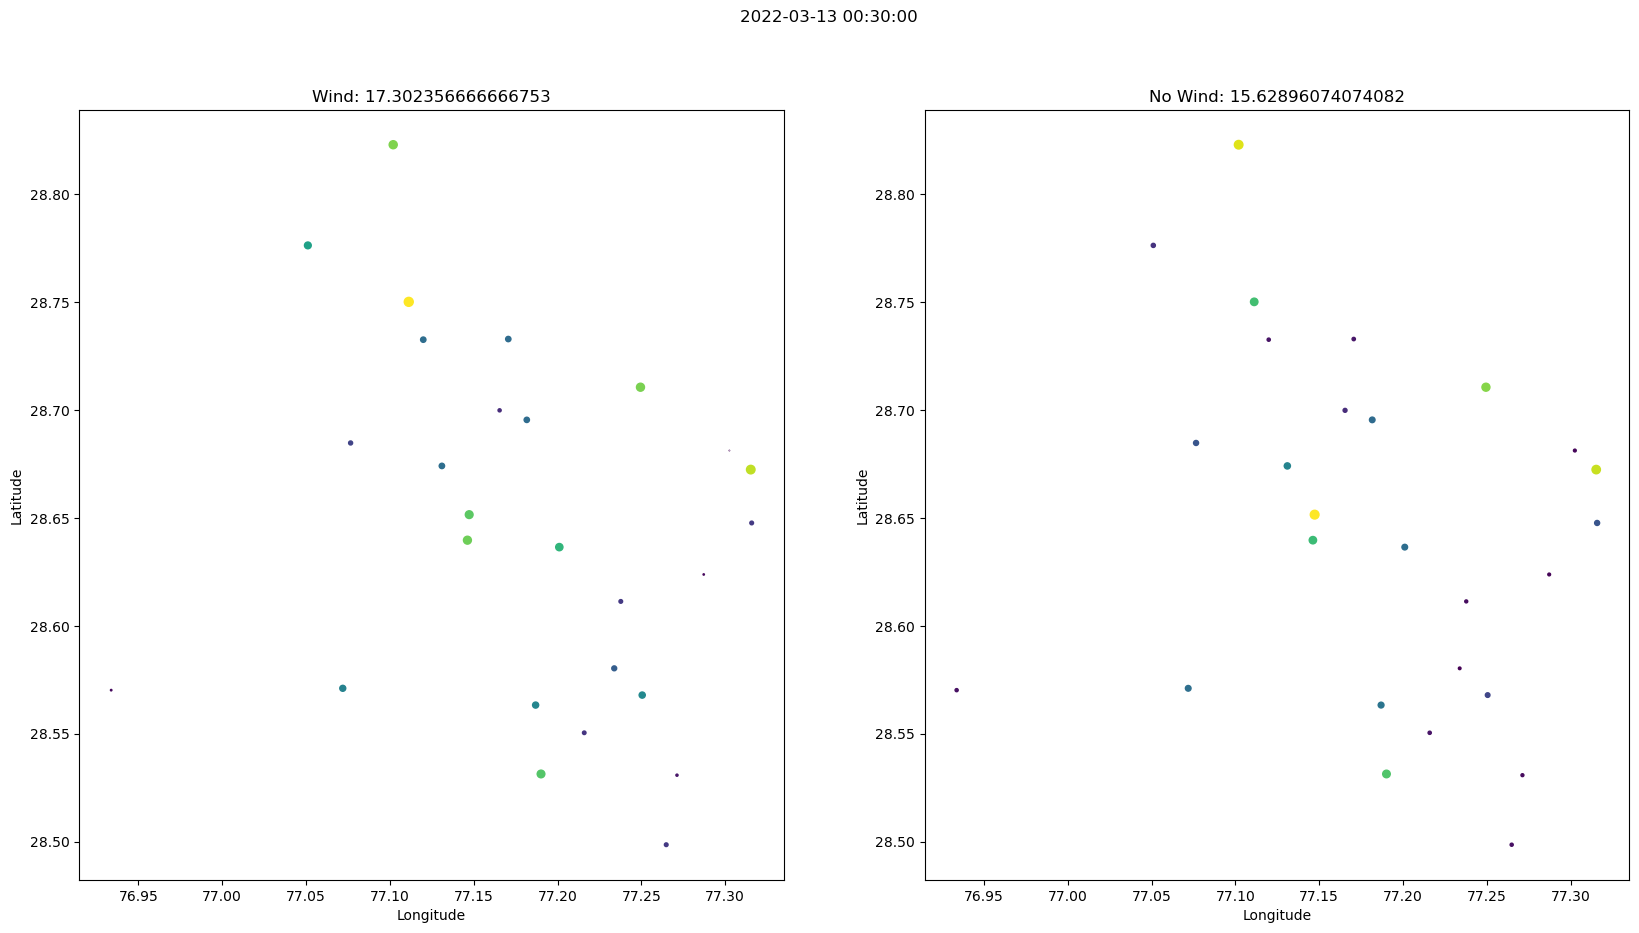

Timestamp: 2022-03-15 00:30:00
No Wind RMSE:  23.144160357142987
Wind RMSE:  25.334880000000172


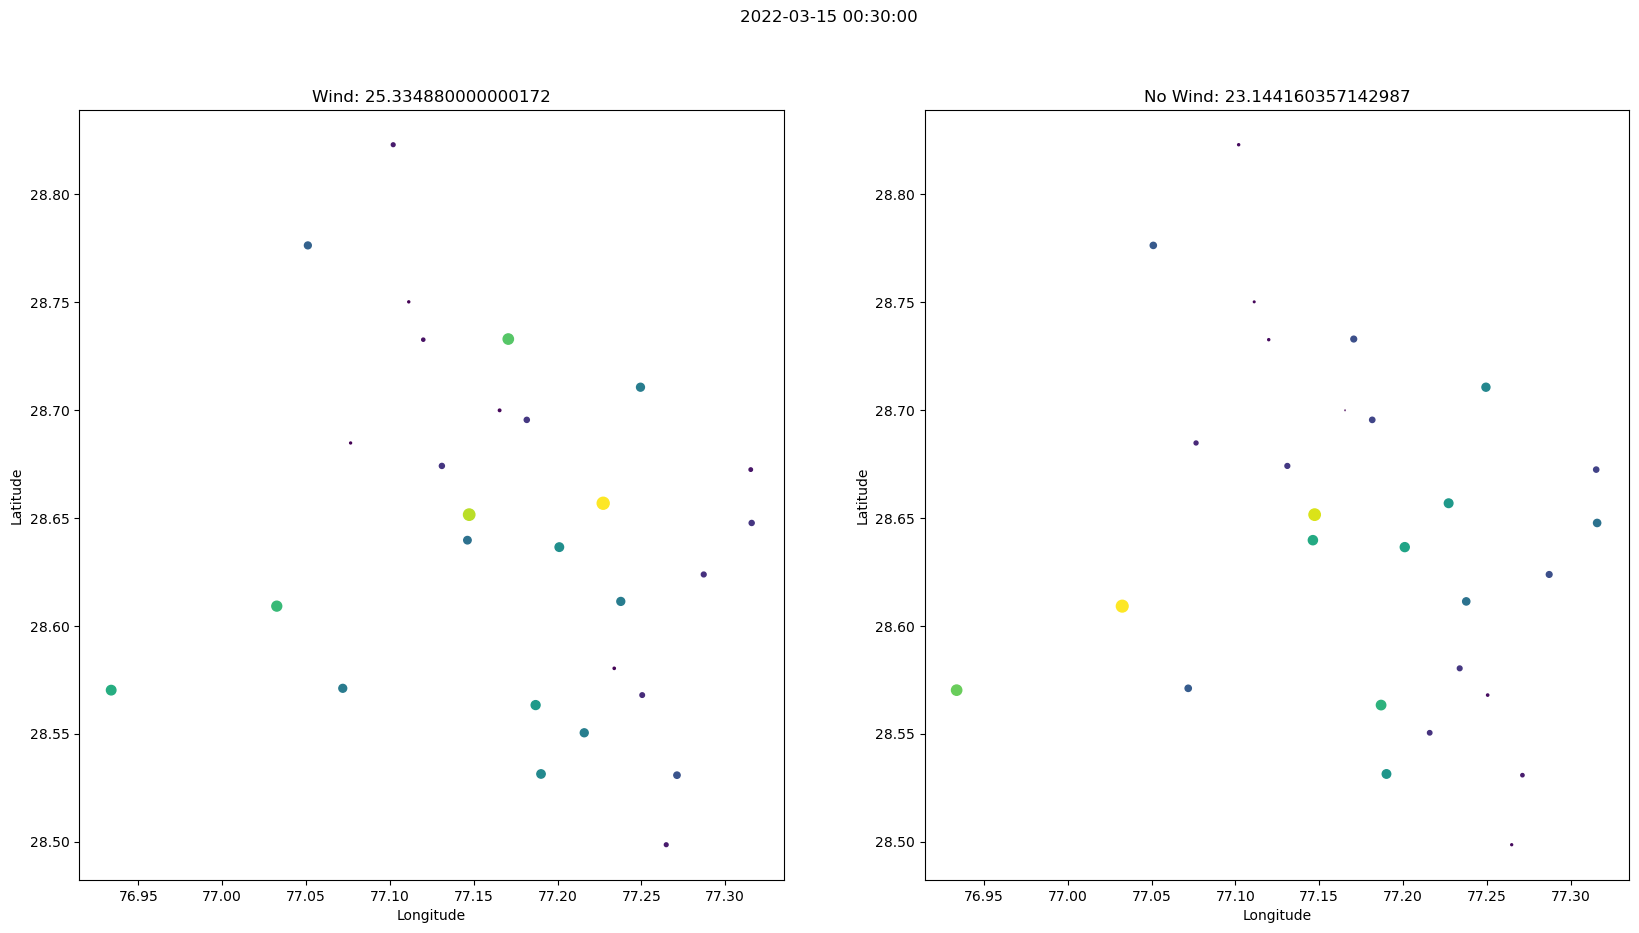

Timestamp: 2022-03-17 00:30:00
No Wind RMSE:  14.244318965517225
Wind RMSE:  15.34145931034487


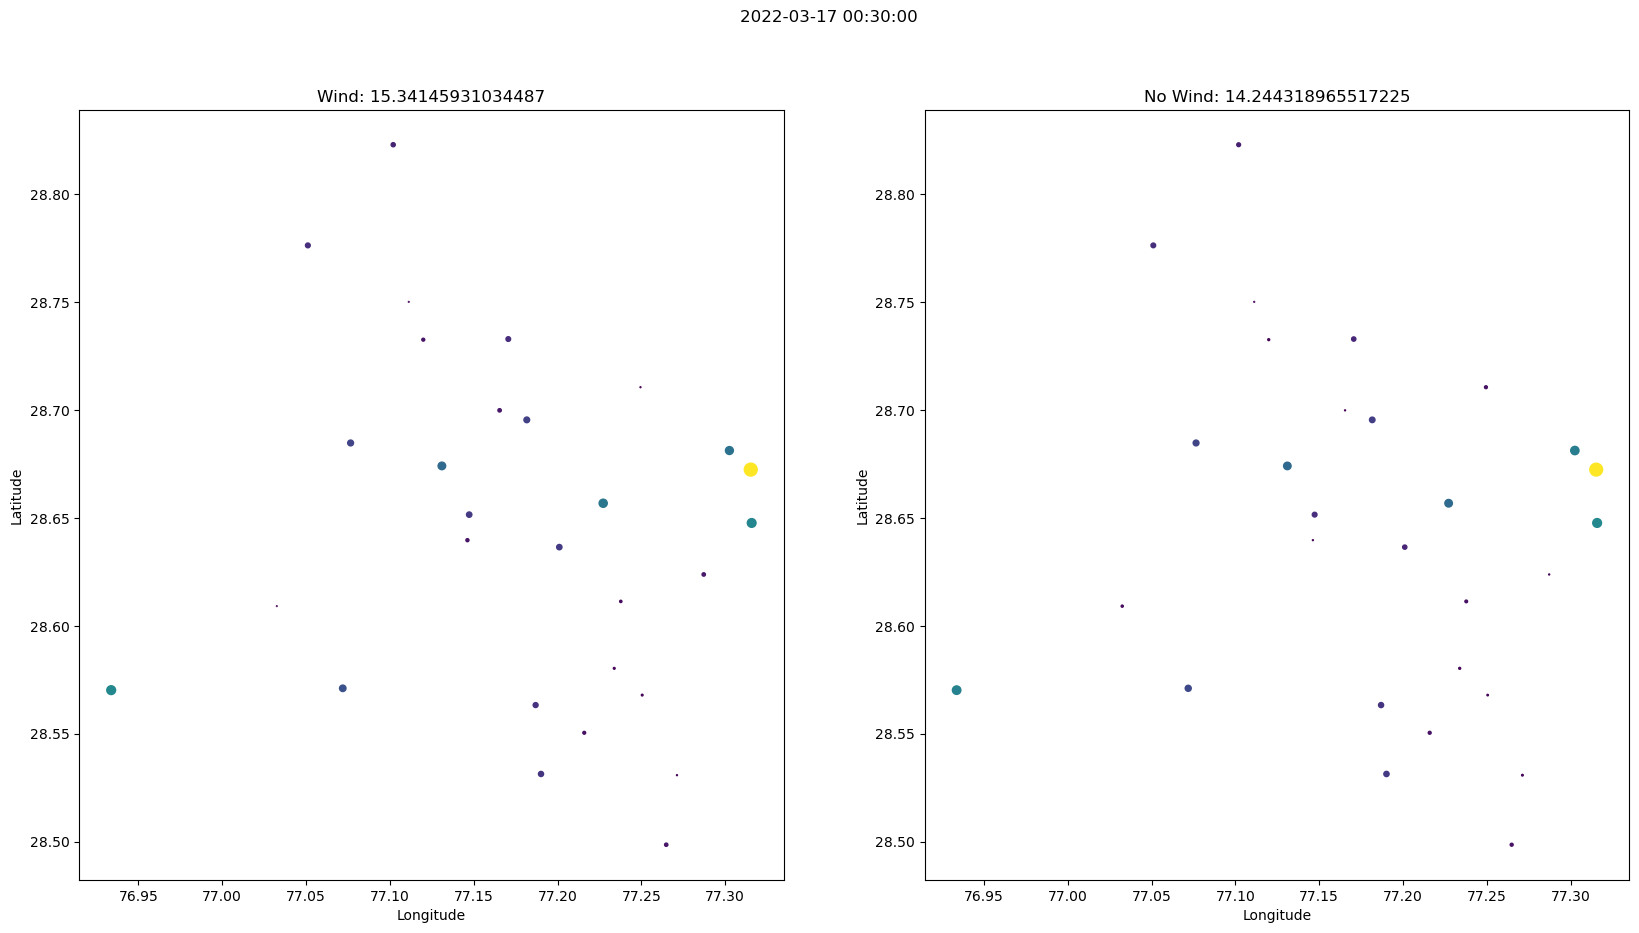

Timestamp: 2022-03-19 00:30:00
No Wind RMSE:  23.158325555555592
Wind RMSE:  25.11796370370367


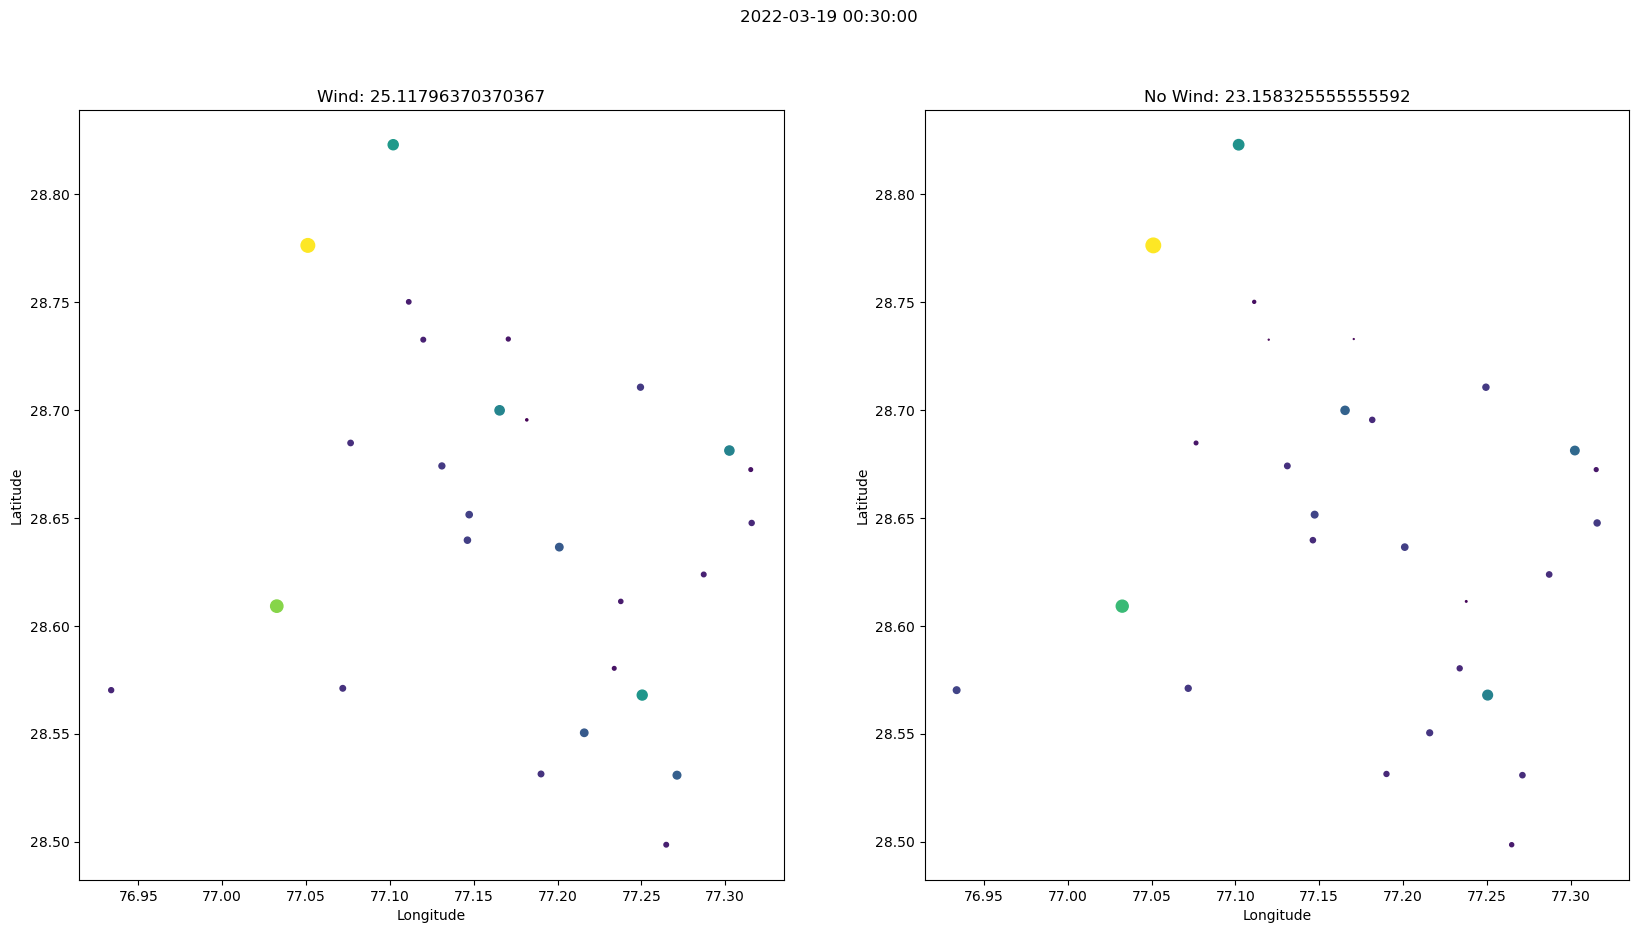

Timestamp: 2022-03-21 00:30:00
No Wind RMSE:  28.305272499999973
Wind RMSE:  30.515439642856997


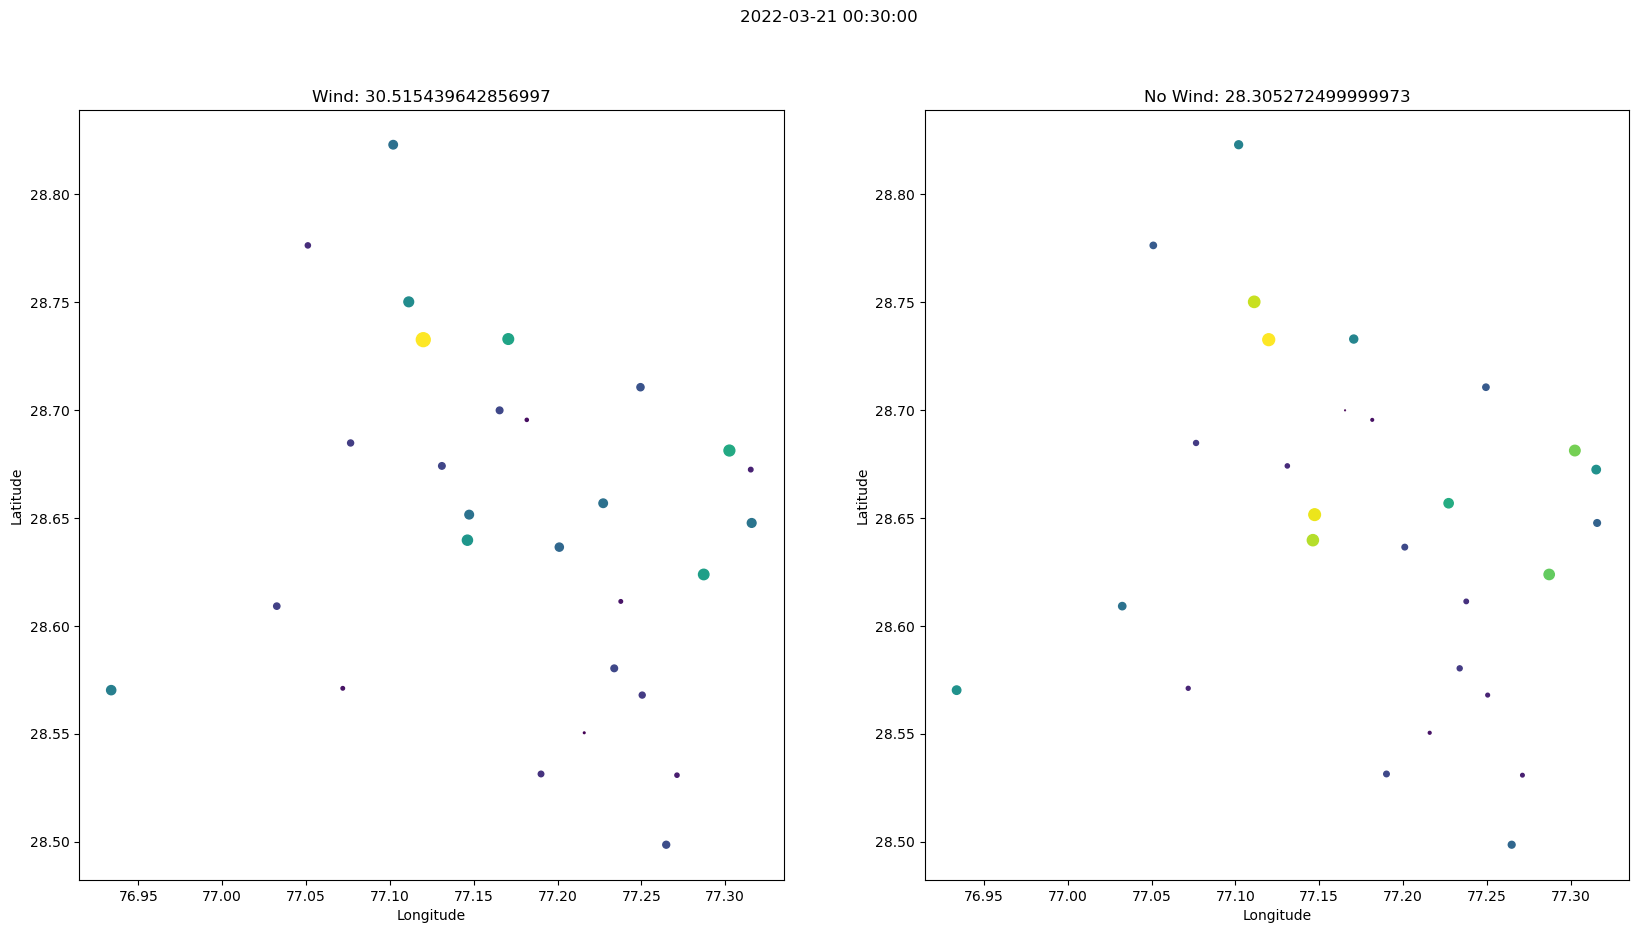

Timestamp: 2022-03-23 00:30:00
No Wind RMSE:  14.651082758620708
Wind RMSE:  13.05877310344831


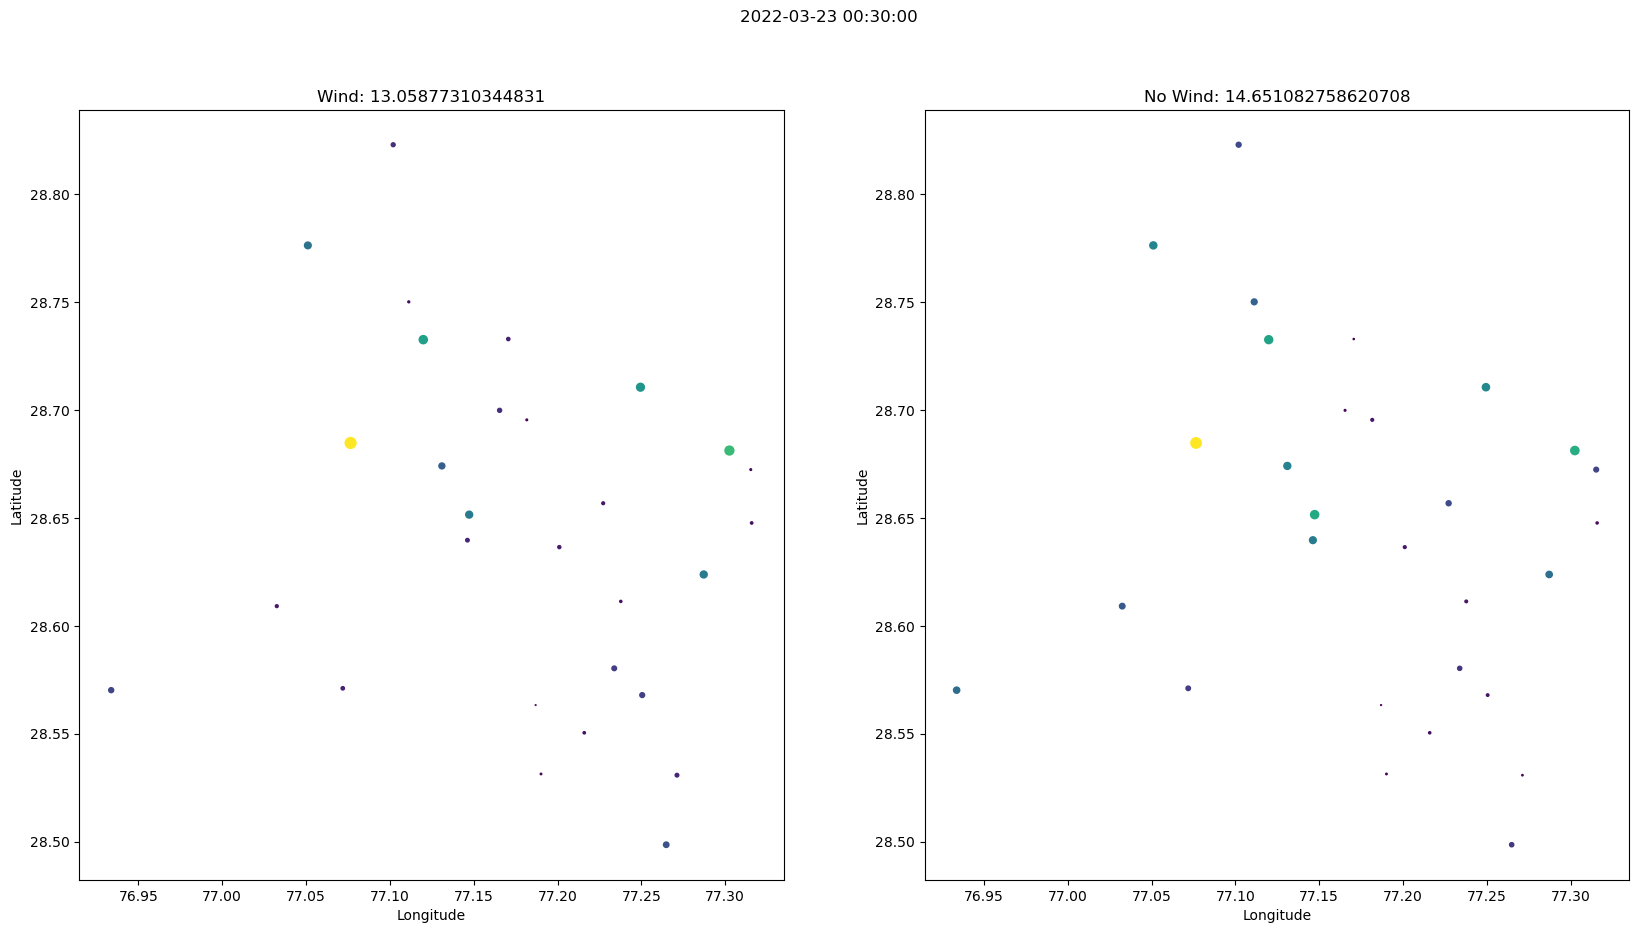

Timestamp: 2022-03-25 00:30:00
No Wind RMSE:  31.418451111111295
Wind RMSE:  32.313981481481605


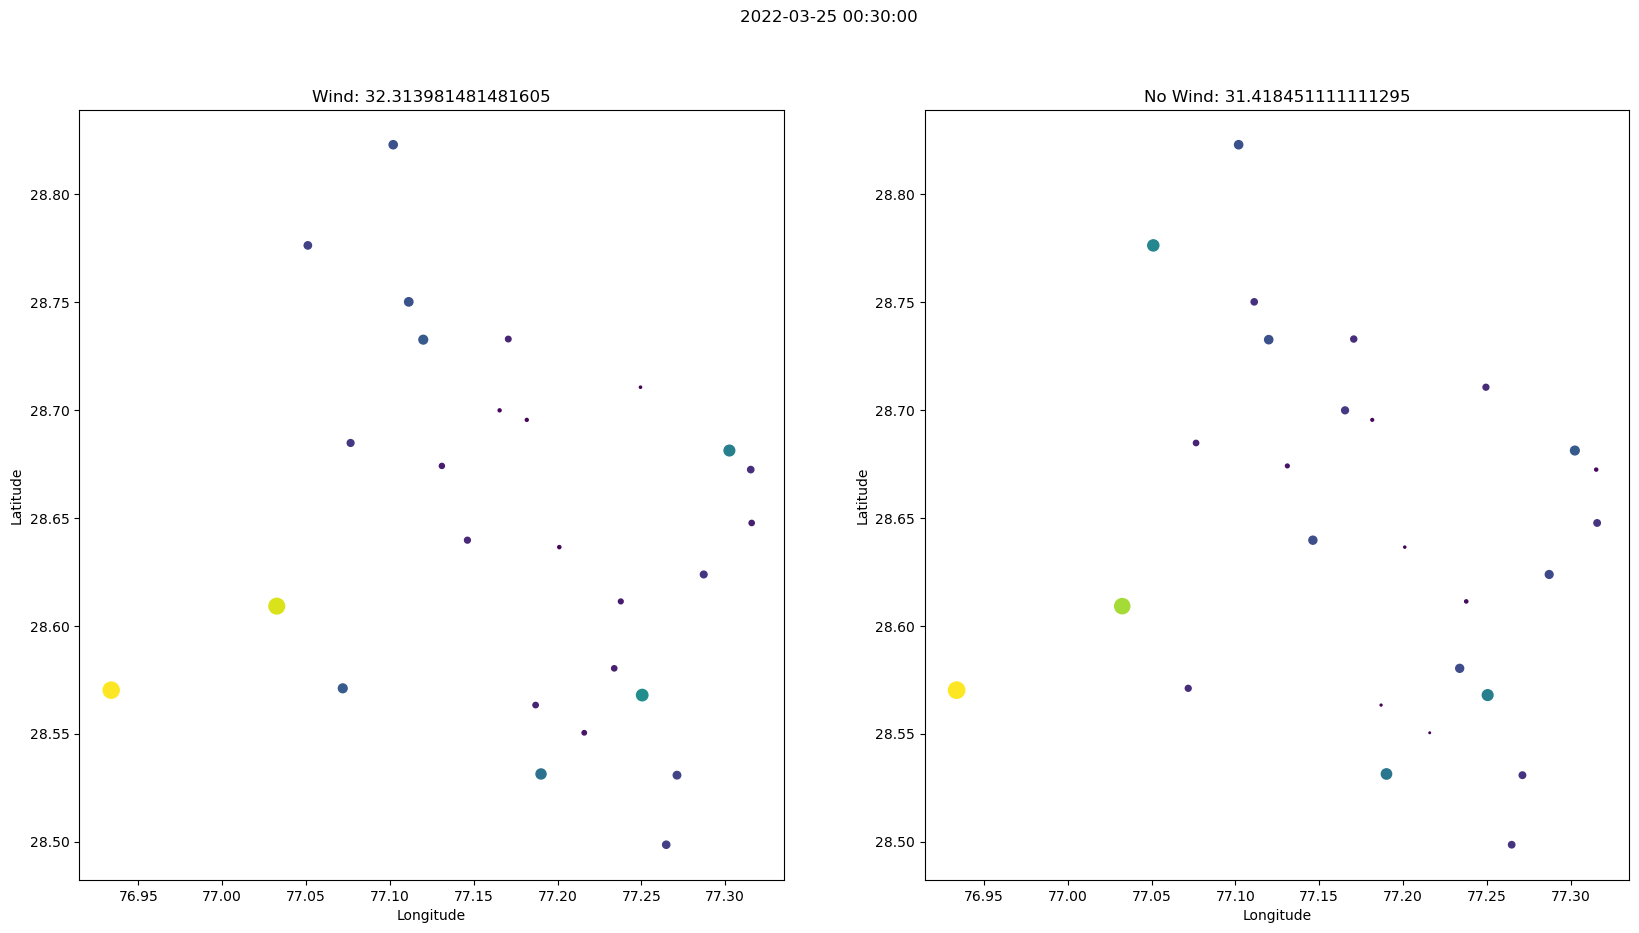

Timestamp: 2022-03-27 00:30:00
No Wind RMSE:  19.32558037037034
Wind RMSE:  20.24557629629633


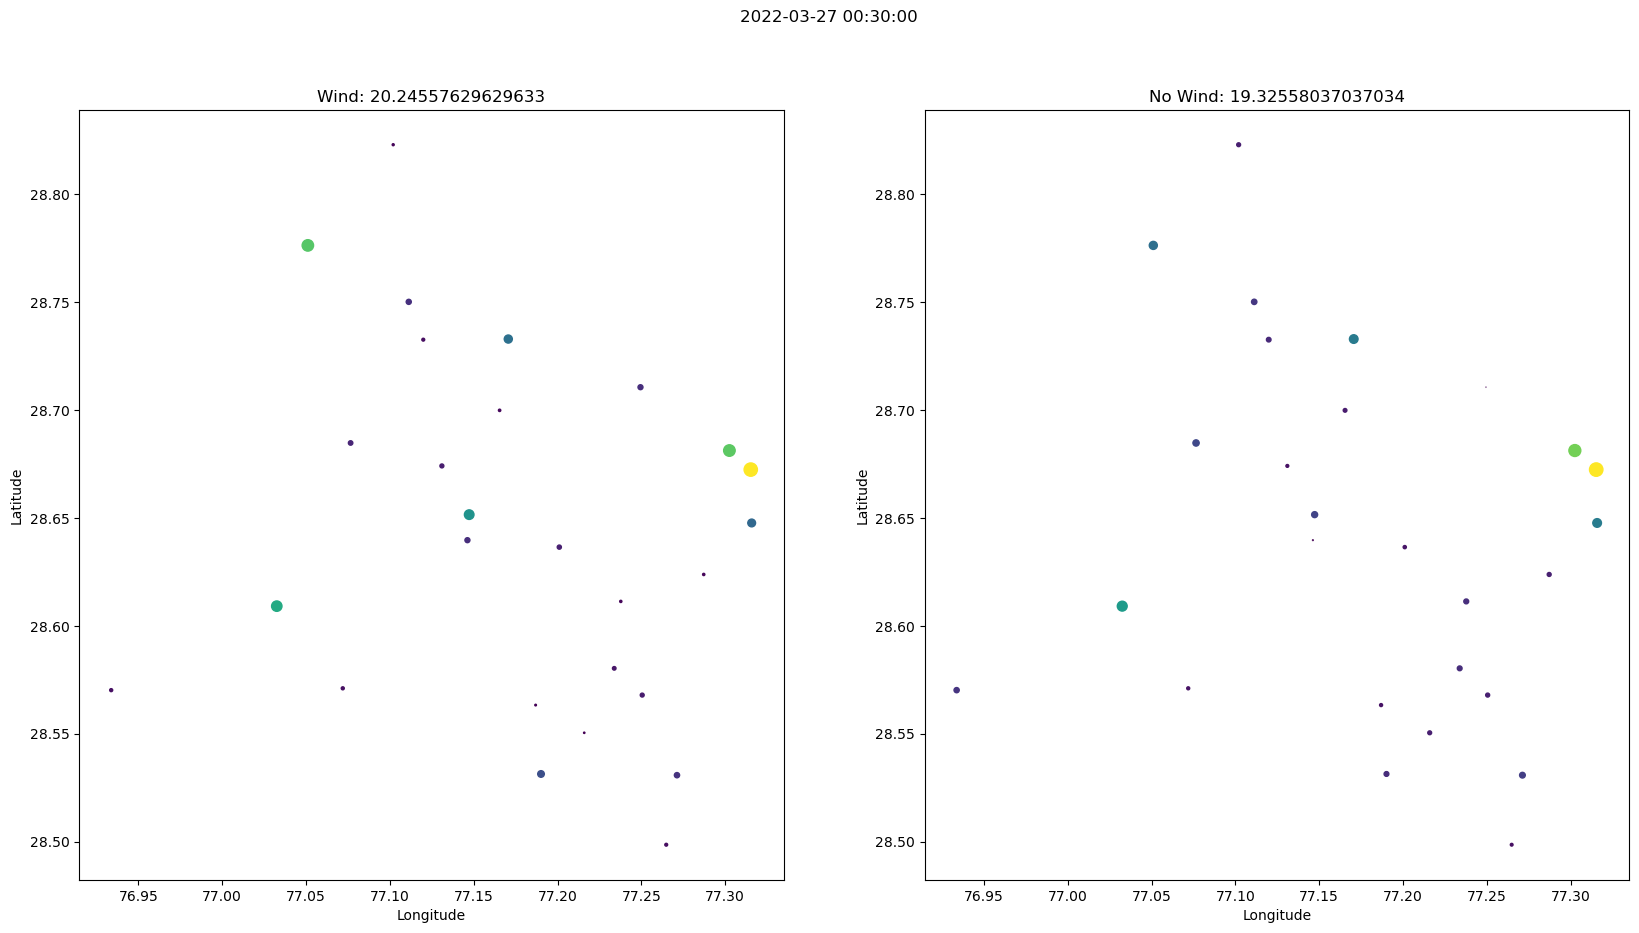

Timestamp: 2022-03-29 00:30:00
No Wind RMSE:  41.16836137931056
Wind RMSE:  46.0298300000002


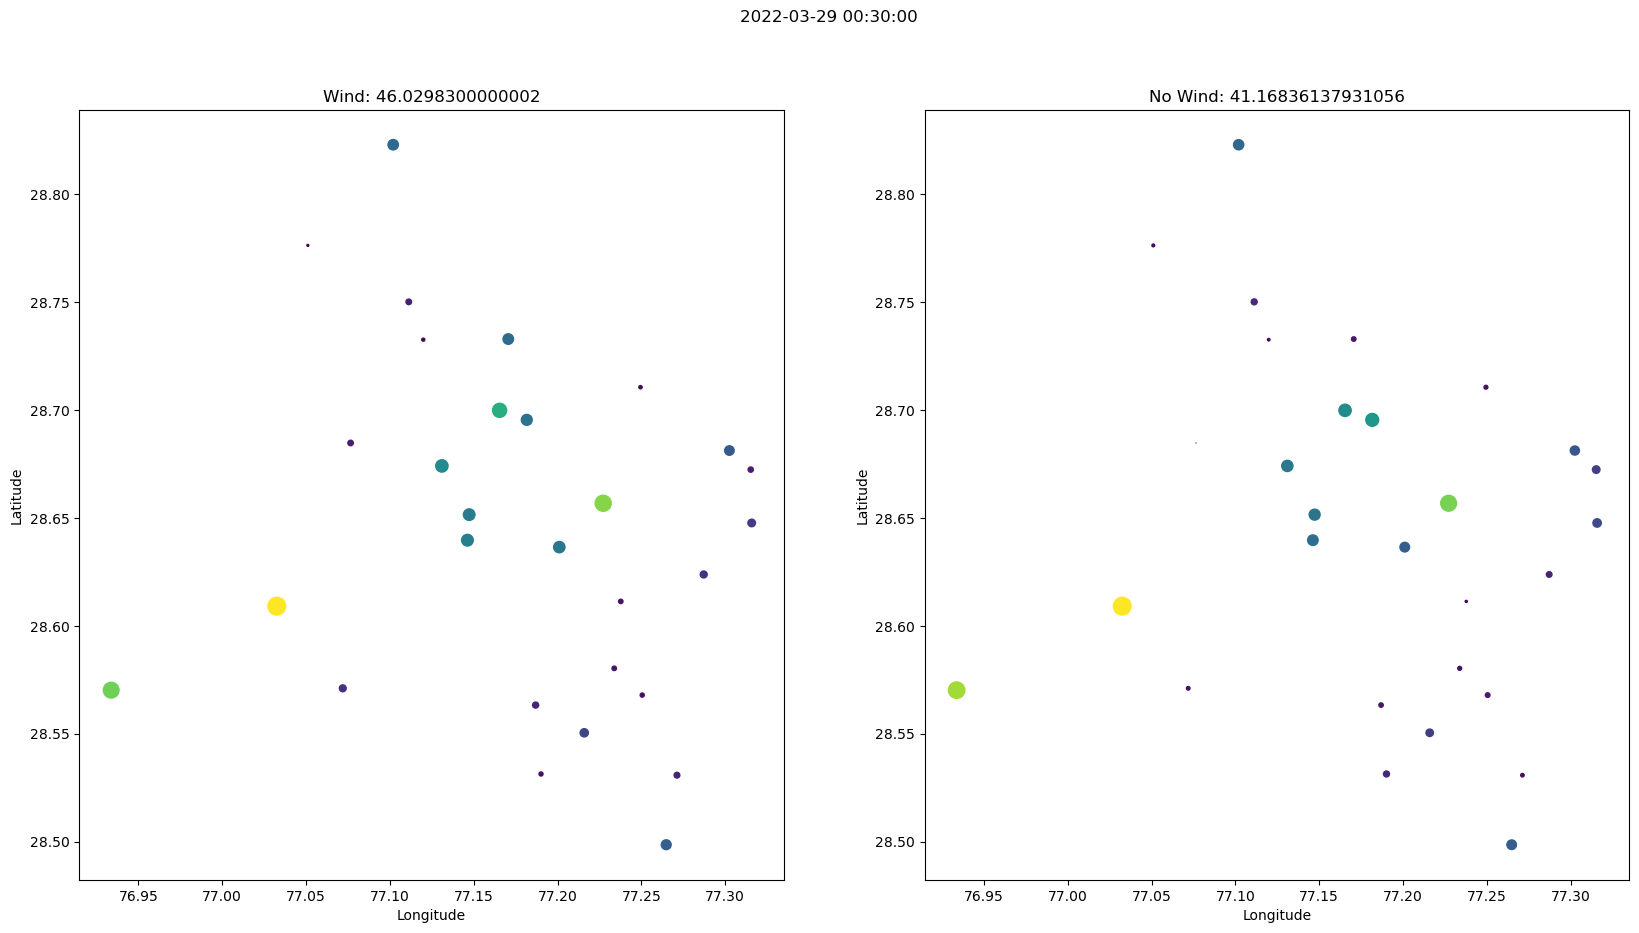

Timestamp: 2022-03-31 00:30:00
No Wind RMSE:  71.9170315384615
Wind RMSE:  79.07187653846157


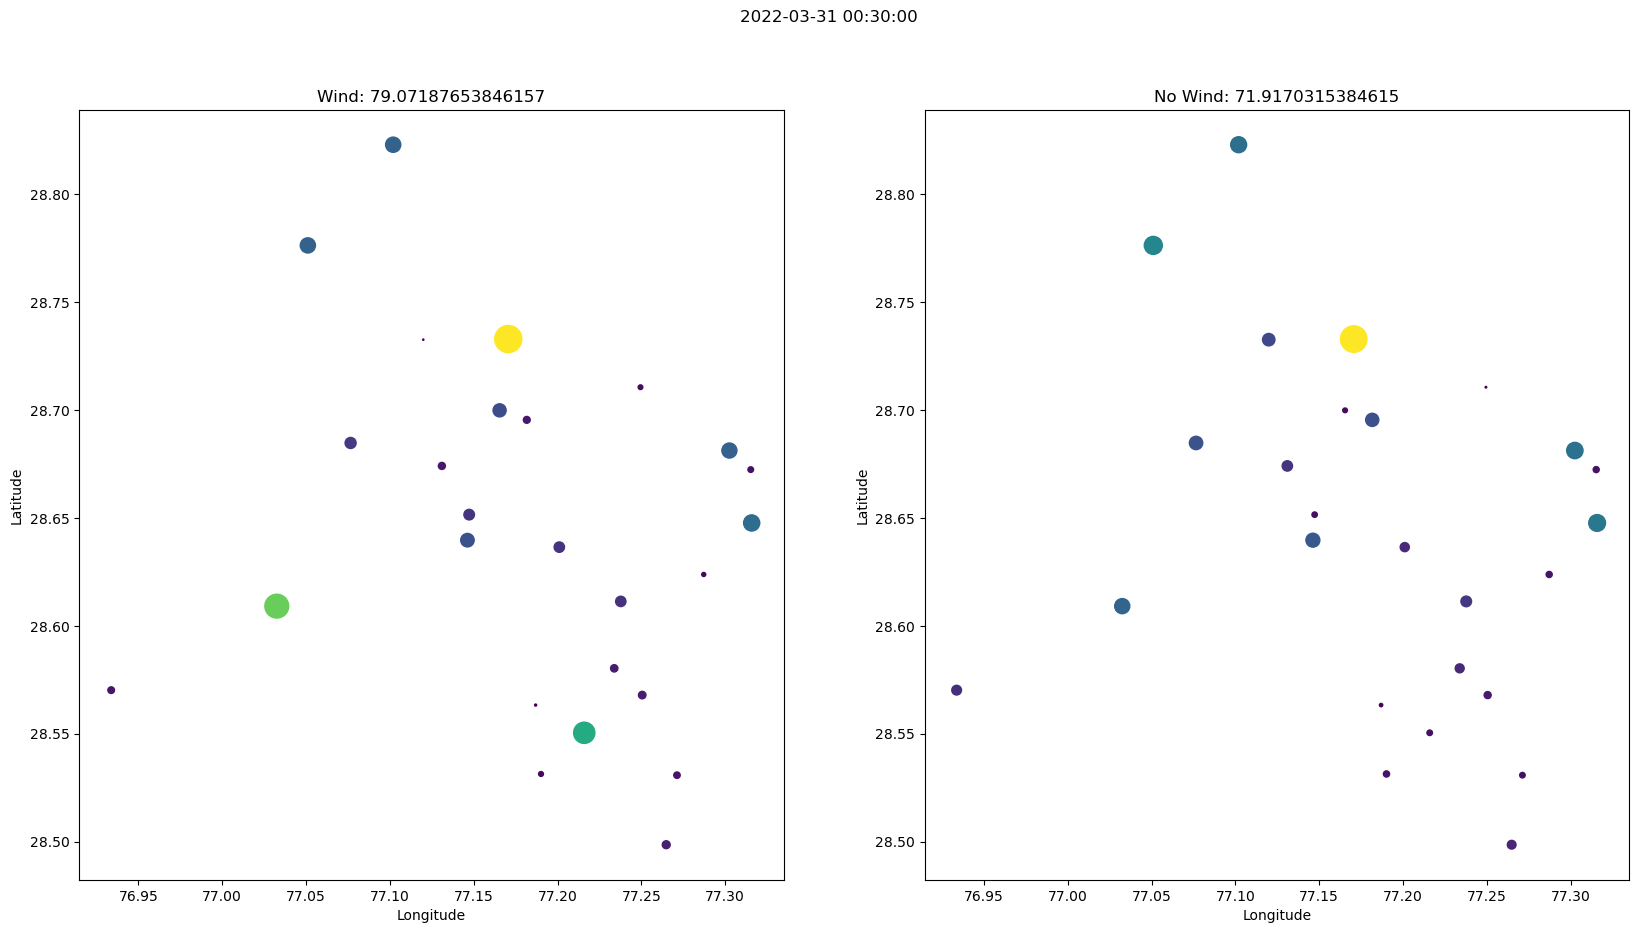

In [8]:
p = pd.date_range(start='2022-03-01 00:30:00', end='2022-04-01 00:30:00', freq = '2D').to_frame(name='dates')

for i in p['dates']:
    d_i = rf_loocv(i)
    d_i = pd.DataFrame(d_i)
    print("Timestamp:", i)
    print('No Wind RMSE: ', np.mean(d_i['no wind rmse']))
    print('Wind RMSE: ', np.mean(d_i['wind rmse']))
    
    plt.figure(figsize = (20,10))
    plt.suptitle(i)
    plt.subplot(1, 2, 1)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['wind rmse'], c = d_i['wind rmse'])
    title = 'Wind: ' + str(np.mean(d_i['wind rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 2, 2)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['no wind rmse'], c = d_i['no wind rmse'])
    title = 'No Wind: ' + str(np.mean(d_i['no wind rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# KNN

In [9]:
from sklearn.neighbors import KNeighborsRegressor

def knn_loocv(timestamp):
    dataframe = []
    d = df[df["time"]==timestamp]
    station = d['station'].unique()
    for i in station:
        test = d[d['station'] == i]
        test = test[['latitude', 'longitude', 'WS', 'WD', 'PM2.5']]
        
        train = d[d['station'] != i]
        train = train[['latitude', 'longitude', 'WS', 'WD', 'PM2.5']]
        
        #No Wind
        X_train = train[['latitude', 'longitude']]
        X_test = test[['latitude', 'longitude']]
        y_train = train['PM2.5']
        y_test = test['PM2.5']
        
        knn_model2 = KNeighborsRegressor(n_neighbors=8)
        knn_model2.fit(X_train, y_train)
        nw_pred = knn_model2.predict(X_test)
        nw_rmse = np.sqrt((nw_pred - y_test)**2).tolist()[0]
        
        #Wind
        X_train = train[['latitude', 'longitude', 'WS', 'WD']]
        X_test = test[['latitude', 'longitude', 'WS', 'WD']]
        y_train = train['PM2.5']
        y_test = test['PM2.5']

        knn_model = KNeighborsRegressor(n_neighbors=8)
        knn_model.fit(X_train, y_train)
        wind_pred = knn_model.predict(X_test)
        wind_rmse = np.sqrt((wind_pred - y_test)**2).tolist()[0]
             
        actual = y_test.tolist()[0]
        
        dataframe.append({
                            "node": i,
                            "lat": test.iloc[0]["latitude"],
                            "lon": test.iloc[0]["longitude"],
                            "WD": test.iloc[0]["WD"],
                            "WS": test.iloc[0]["WS"],
                            "wind rmse": wind_rmse,
                            "no wind rmse": nw_rmse,
                            "actual": actual,
                            "wind pred": wind_pred[0],
                            "no wind pred": nw_pred[0],
                           })
    return dataframe

Timestamp: 2022-03-01 00:30:00
No Wind RMSE:  23.26607142857143
Wind RMSE:  26.41375


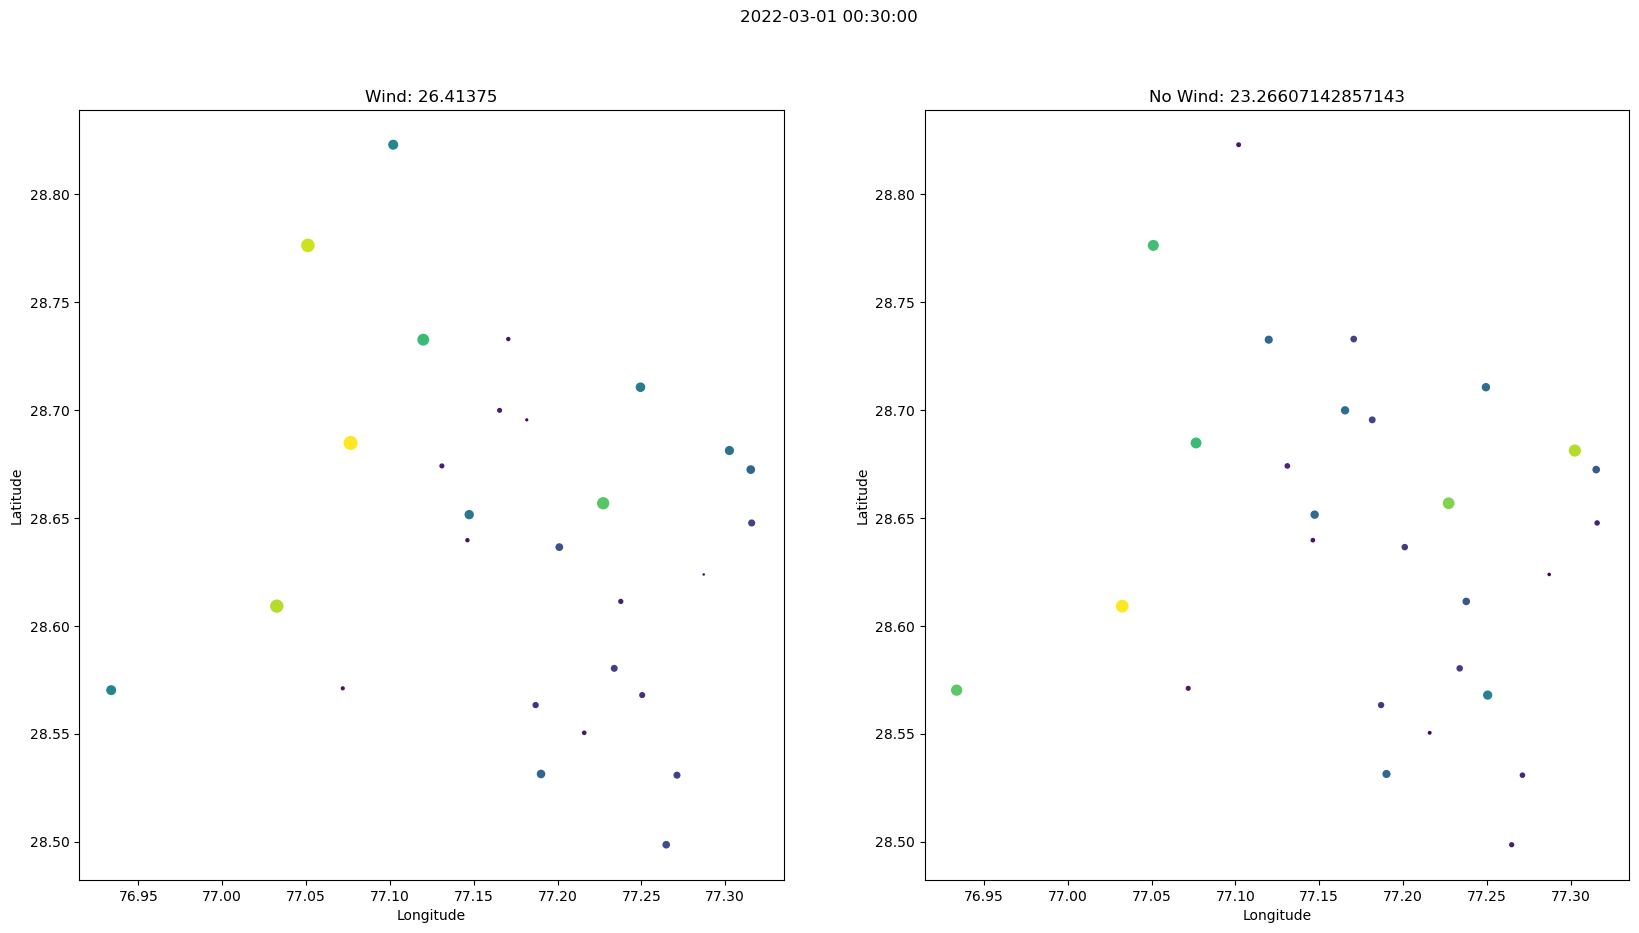

Timestamp: 2022-03-03 00:30:00
No Wind RMSE:  42.86347222222222
Wind RMSE:  41.653333333333336


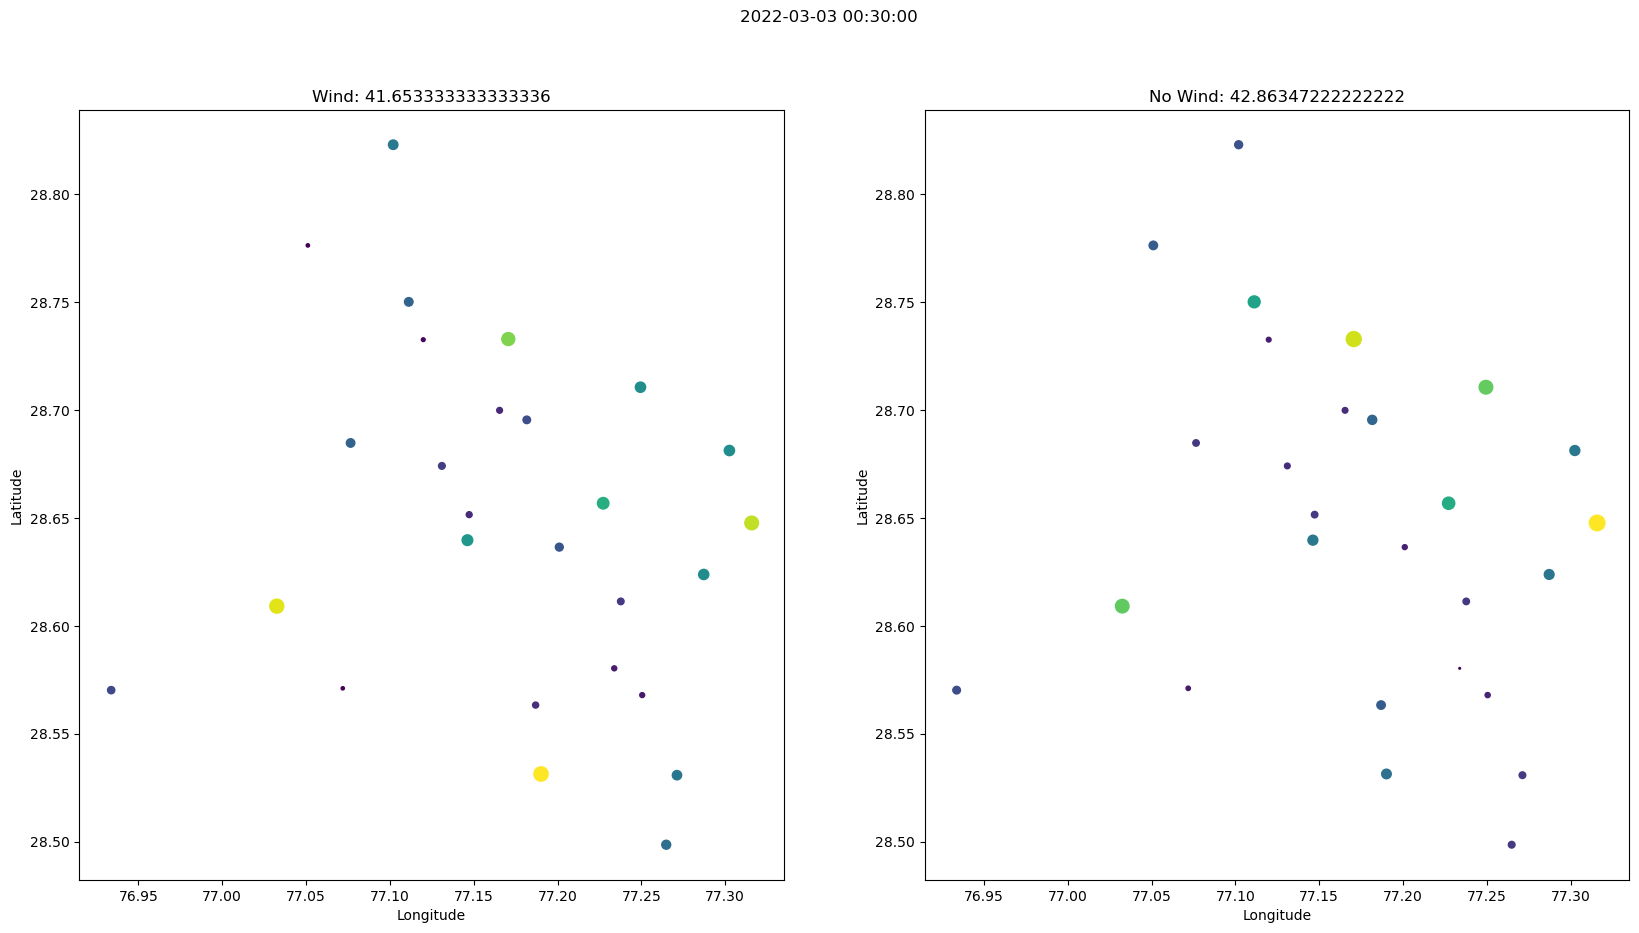

Timestamp: 2022-03-05 00:30:00
No Wind RMSE:  9.356203703703704
Wind RMSE:  11.605000000000002


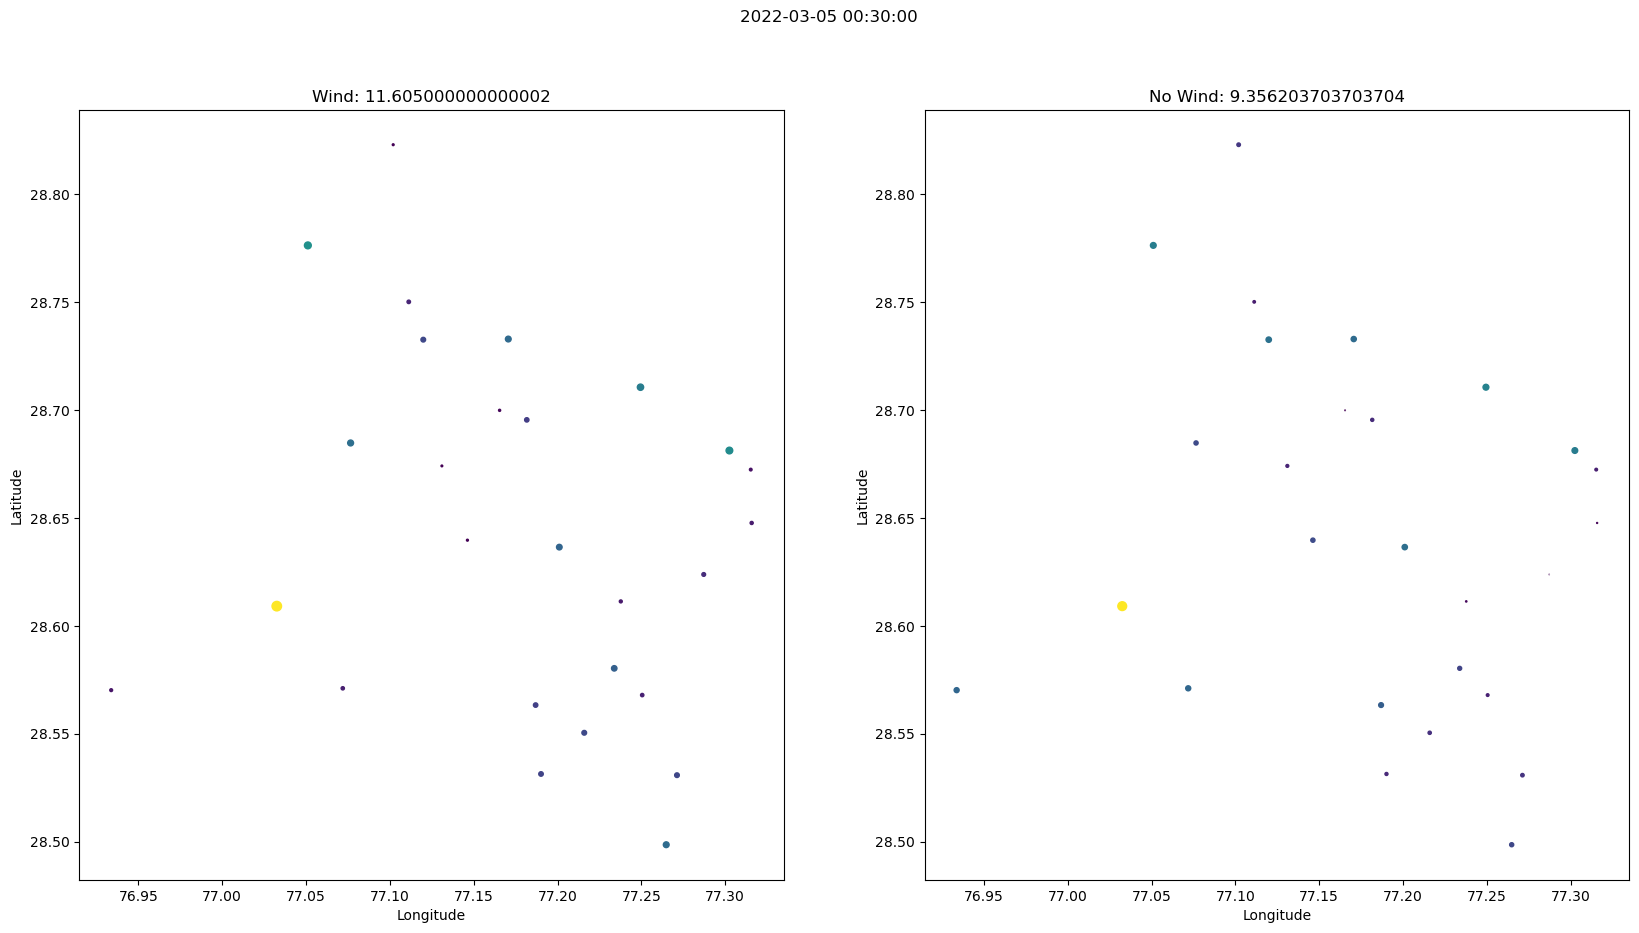

Timestamp: 2022-03-07 00:30:00
No Wind RMSE:  27.24191964285714
Wind RMSE:  32.548750000000005


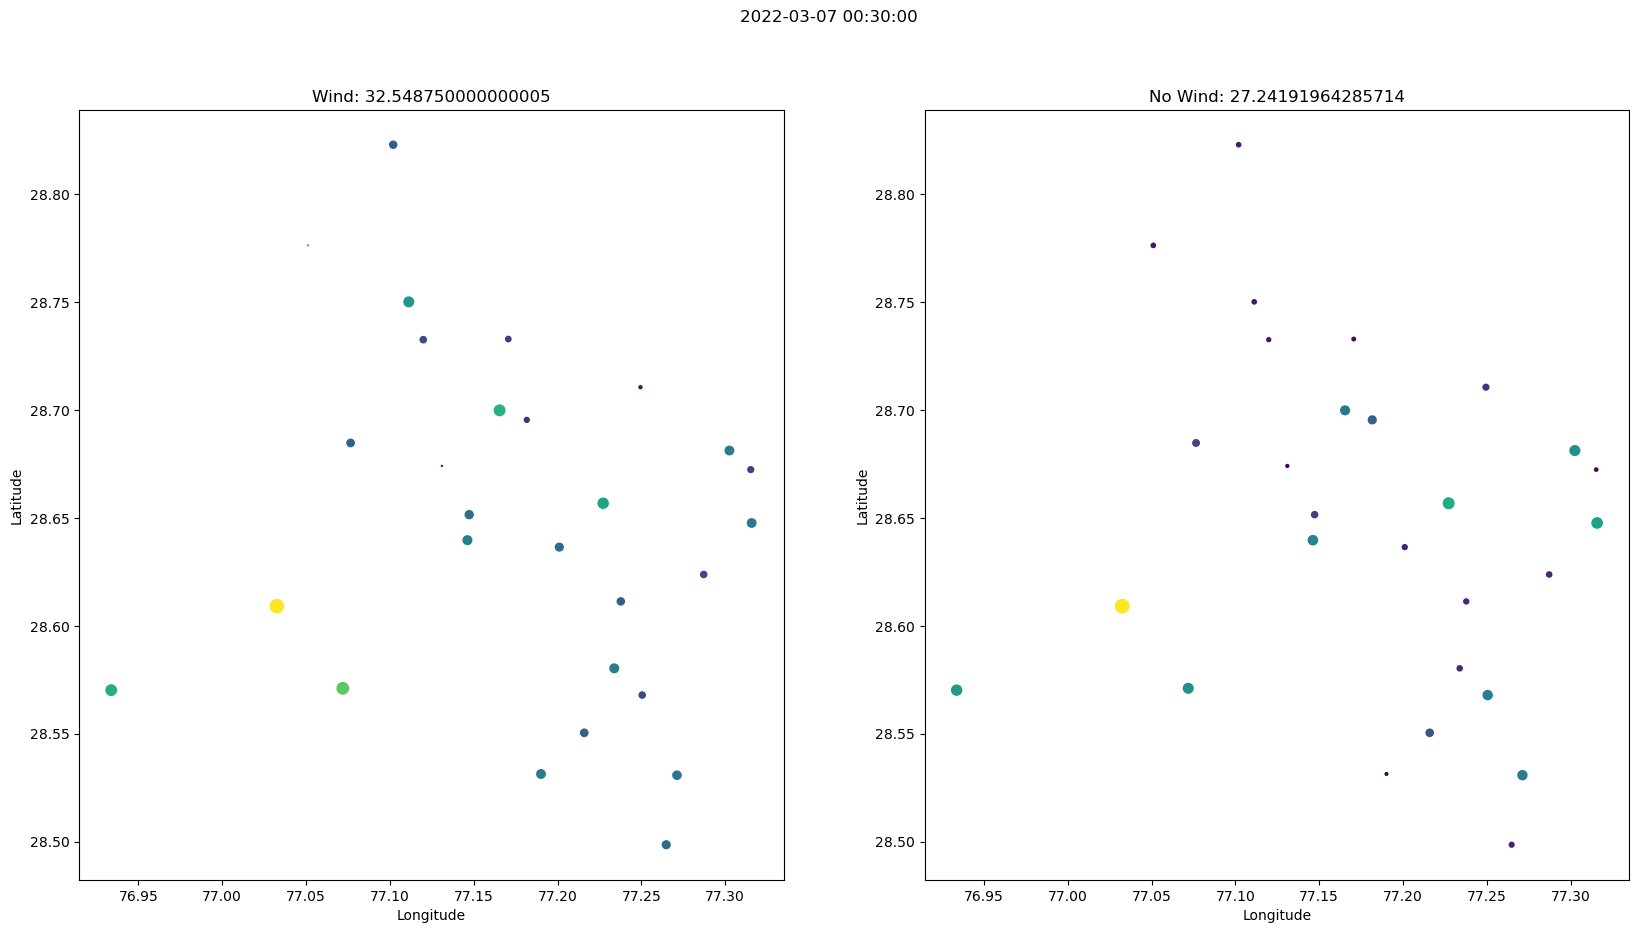

Timestamp: 2022-03-09 00:30:00
No Wind RMSE:  20.054956896551722
Wind RMSE:  25.42926724137931


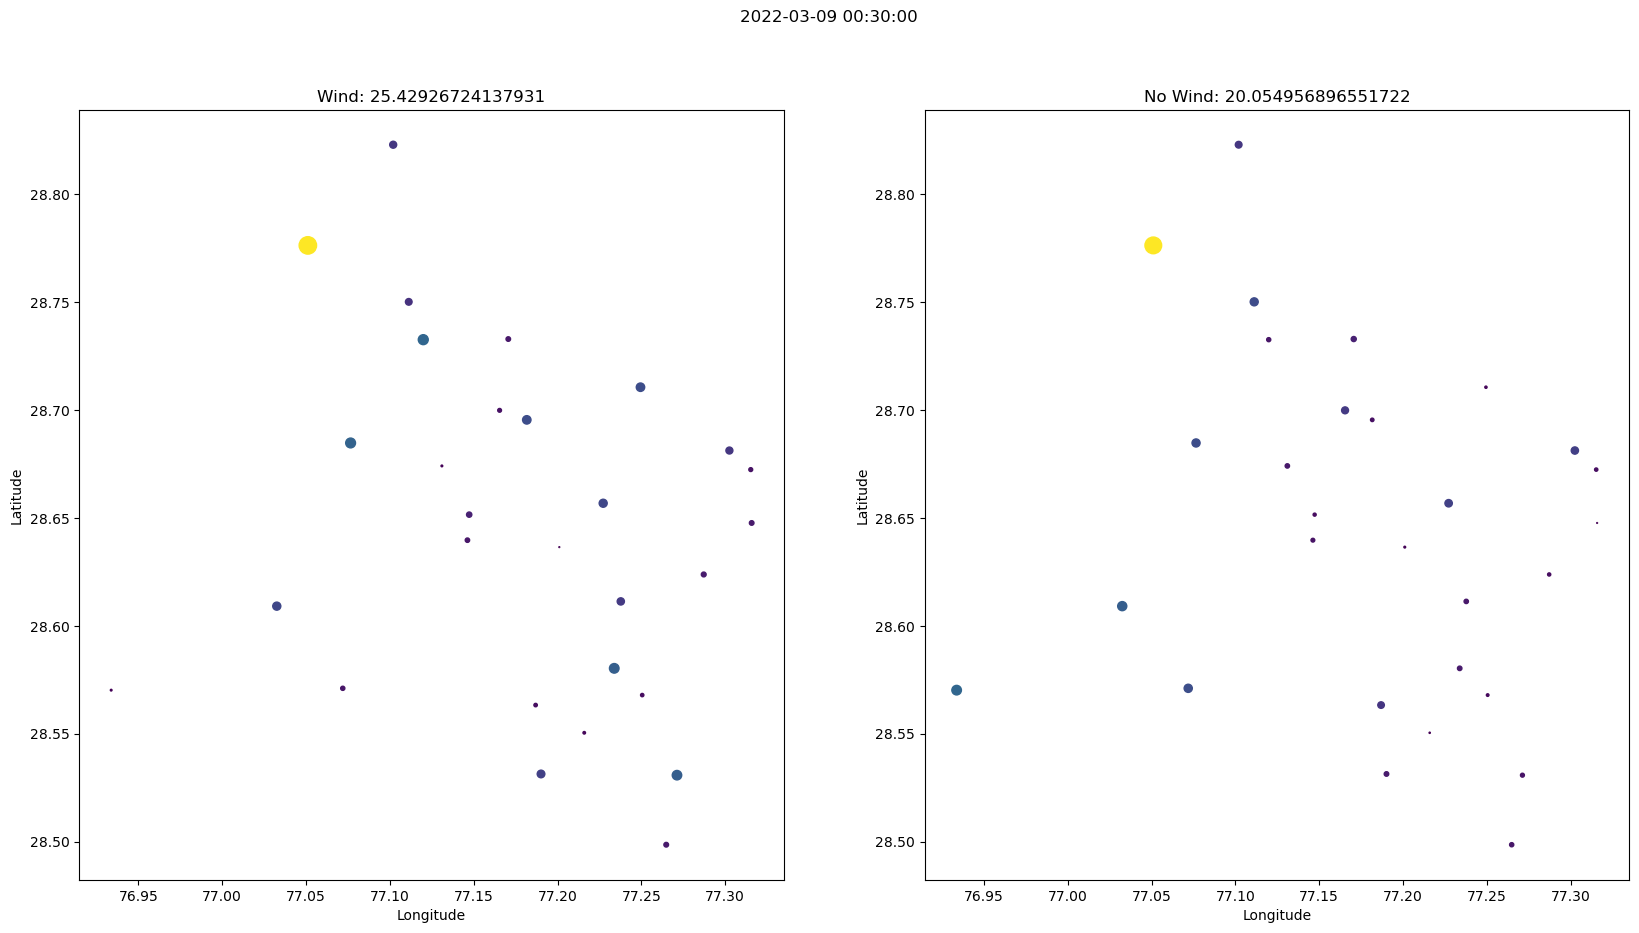

Timestamp: 2022-03-11 00:30:00
No Wind RMSE:  14.514008620689655
Wind RMSE:  19.076077586206896


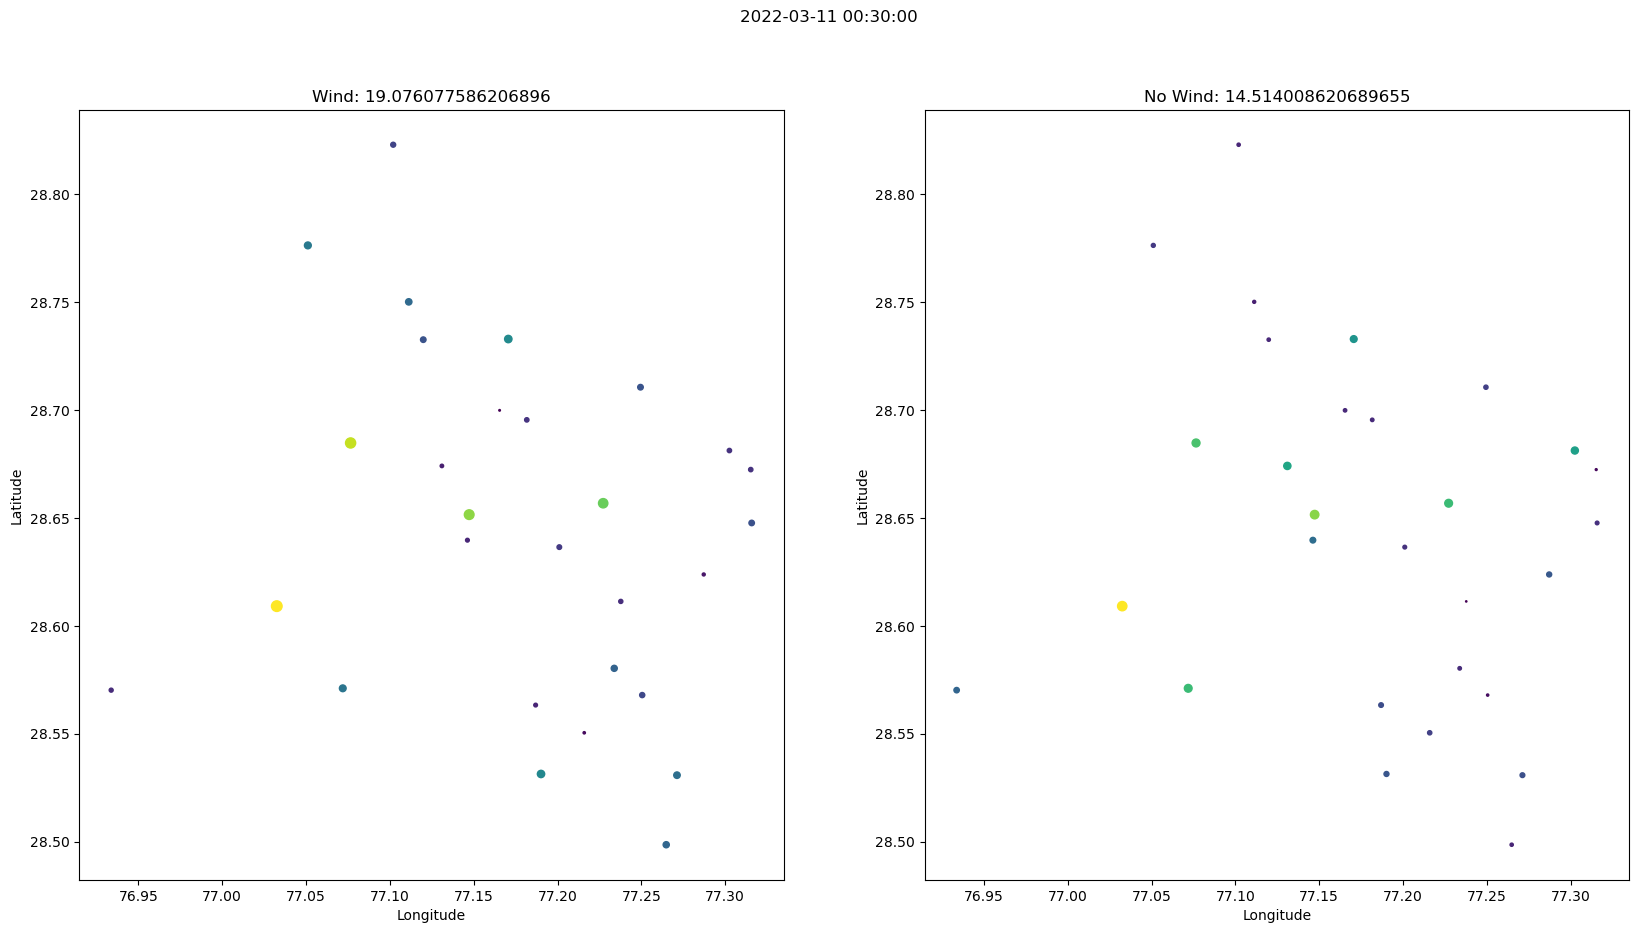

Timestamp: 2022-03-13 00:30:00
No Wind RMSE:  18.69523148148148
Wind RMSE:  24.490694444444443


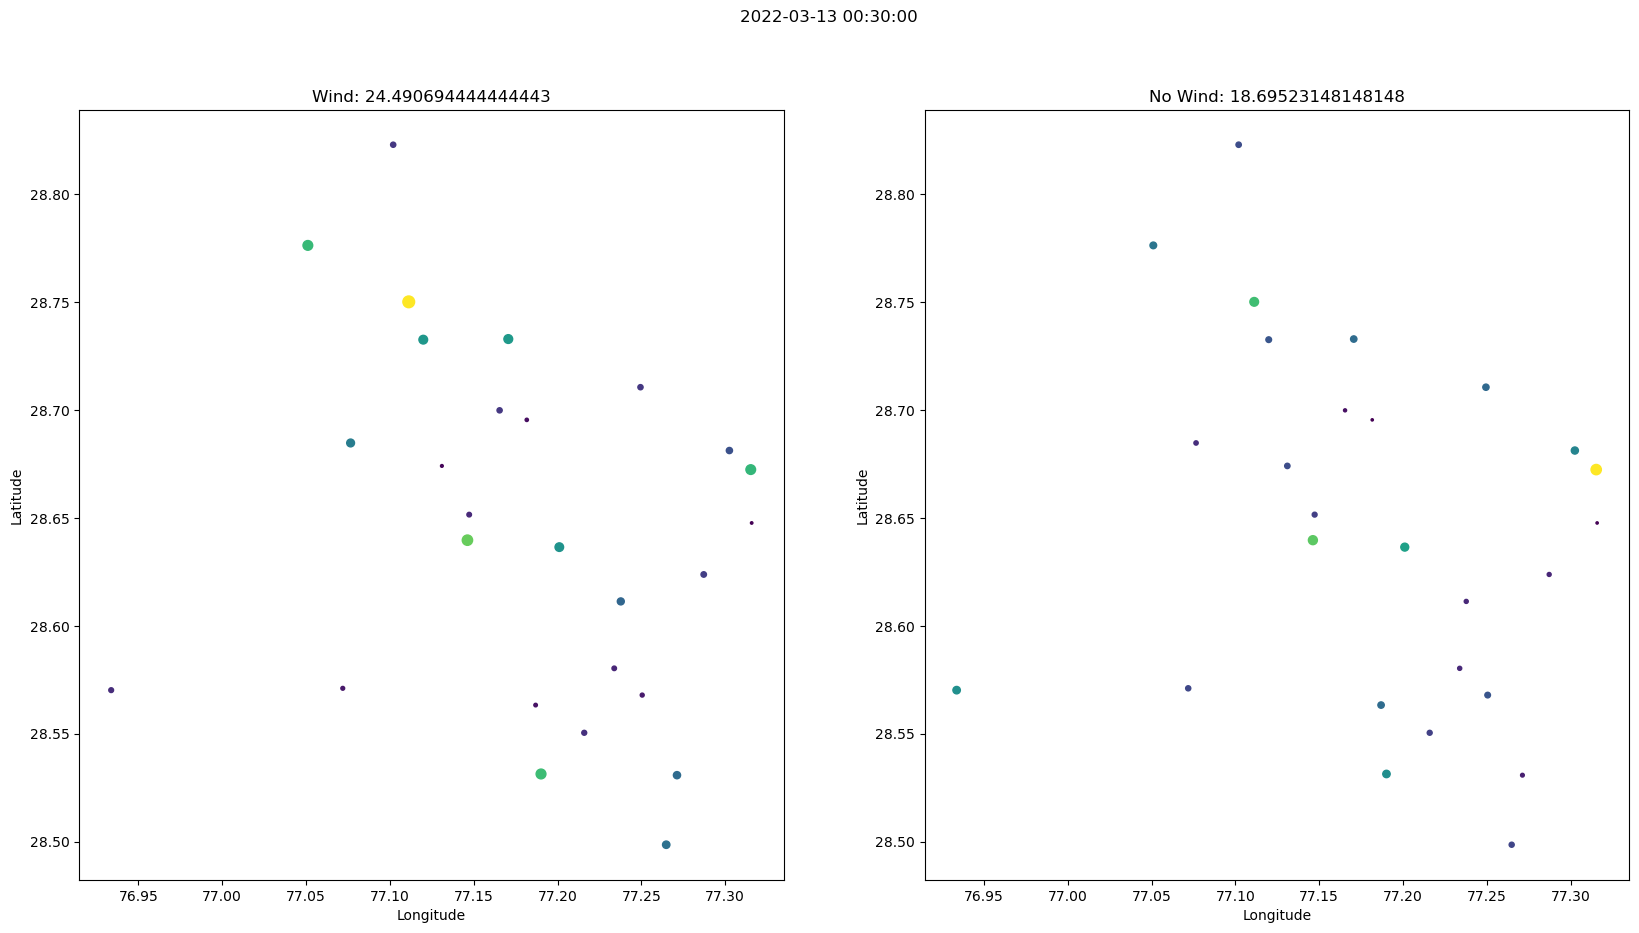

Timestamp: 2022-03-15 00:30:00
No Wind RMSE:  22.667589285714286
Wind RMSE:  23.017008928571425


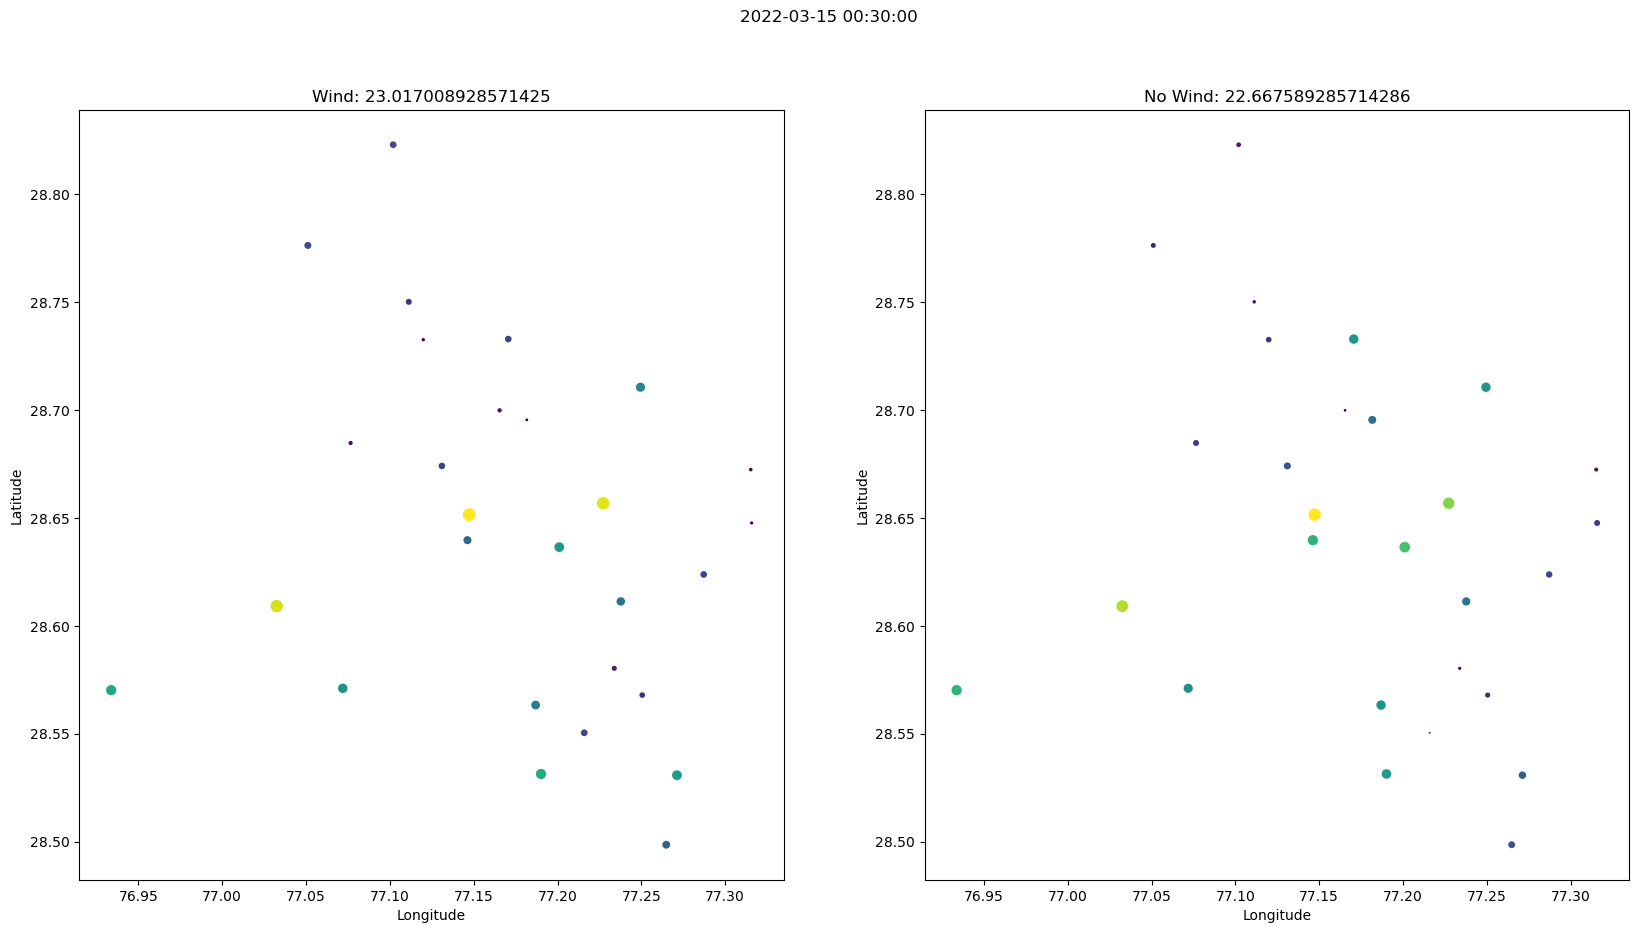

Timestamp: 2022-03-17 00:30:00
No Wind RMSE:  12.670948275862068
Wind RMSE:  23.686379310344826


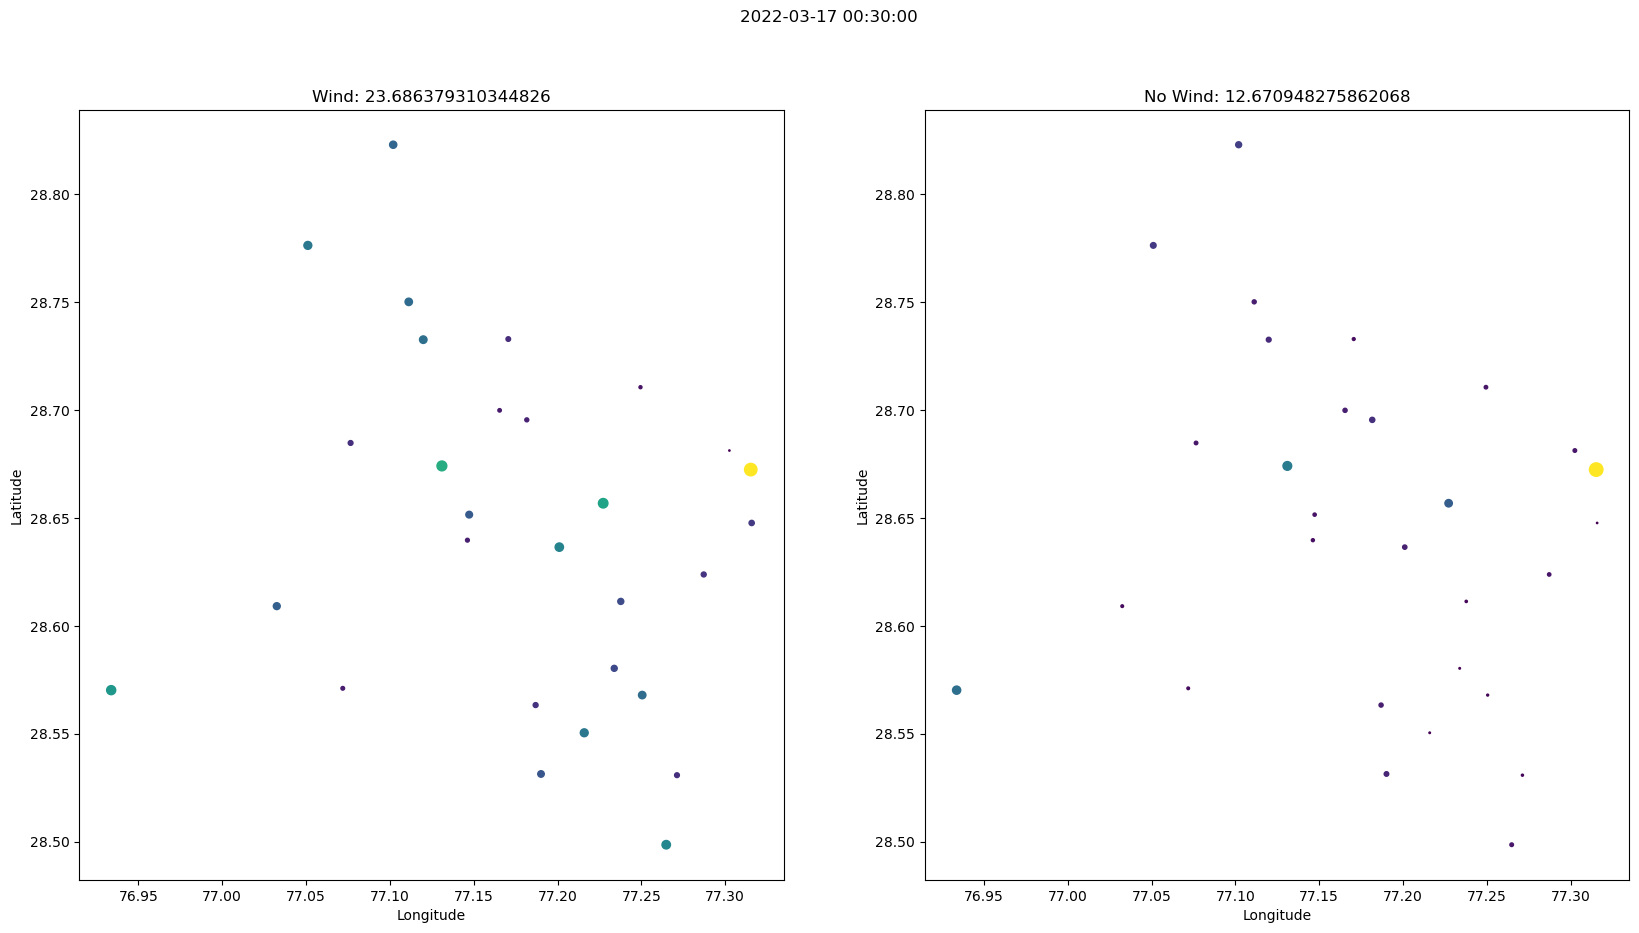

Timestamp: 2022-03-19 00:30:00
No Wind RMSE:  19.234537037037036
Wind RMSE:  23.35888888888889


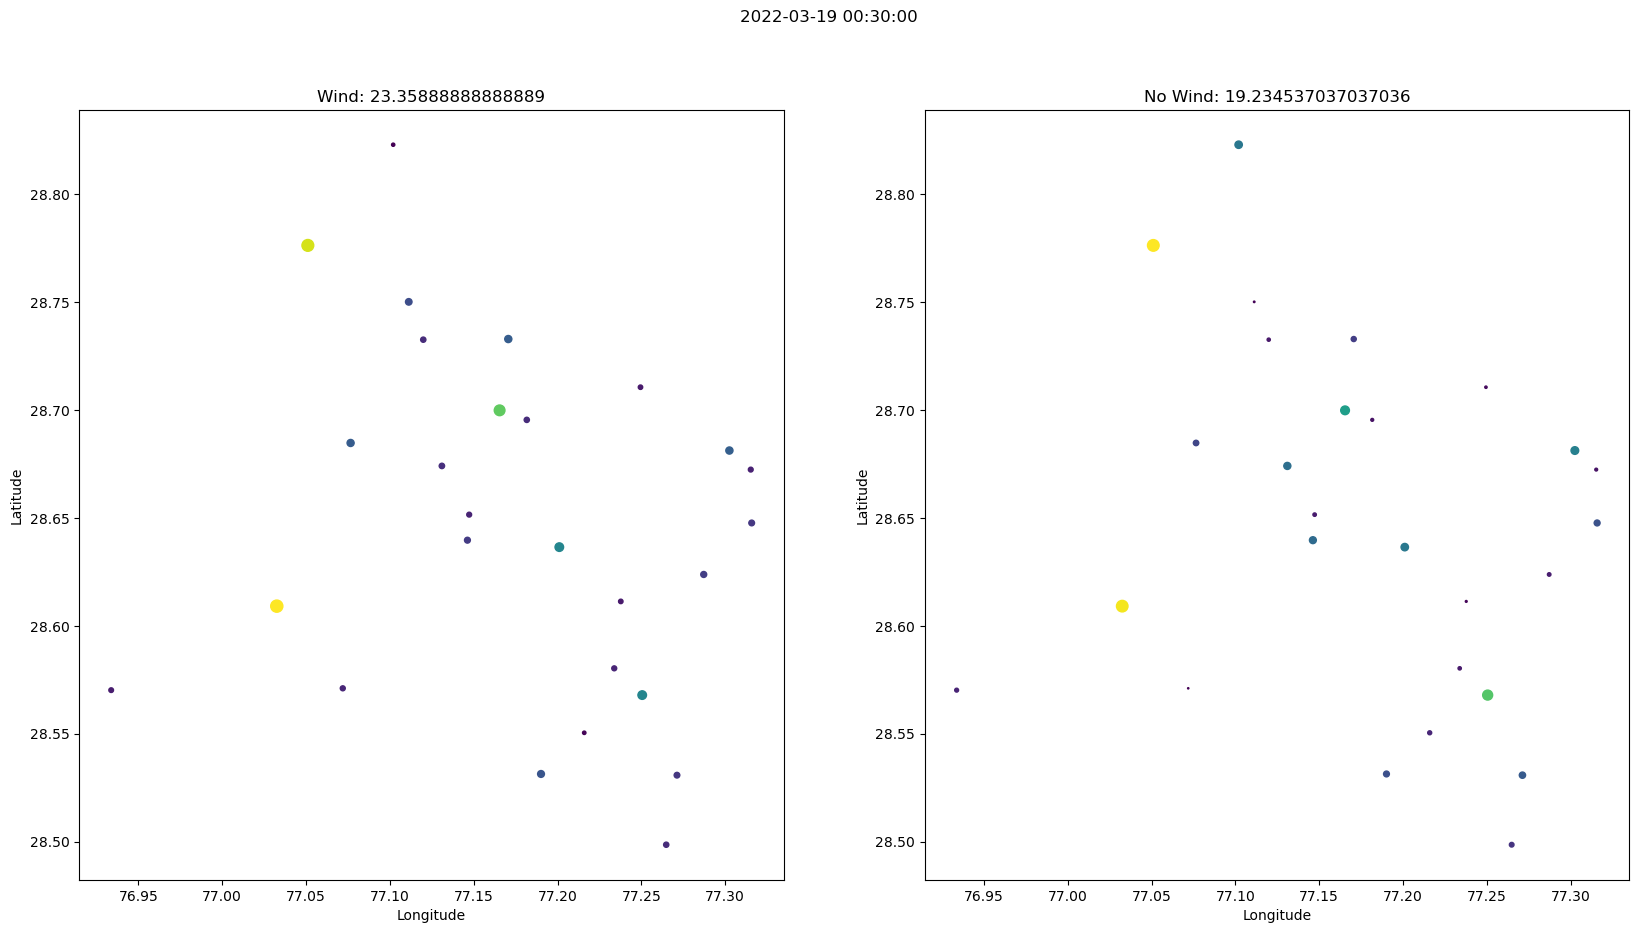

Timestamp: 2022-03-21 00:30:00
No Wind RMSE:  28.38620535714286
Wind RMSE:  31.95517857142857


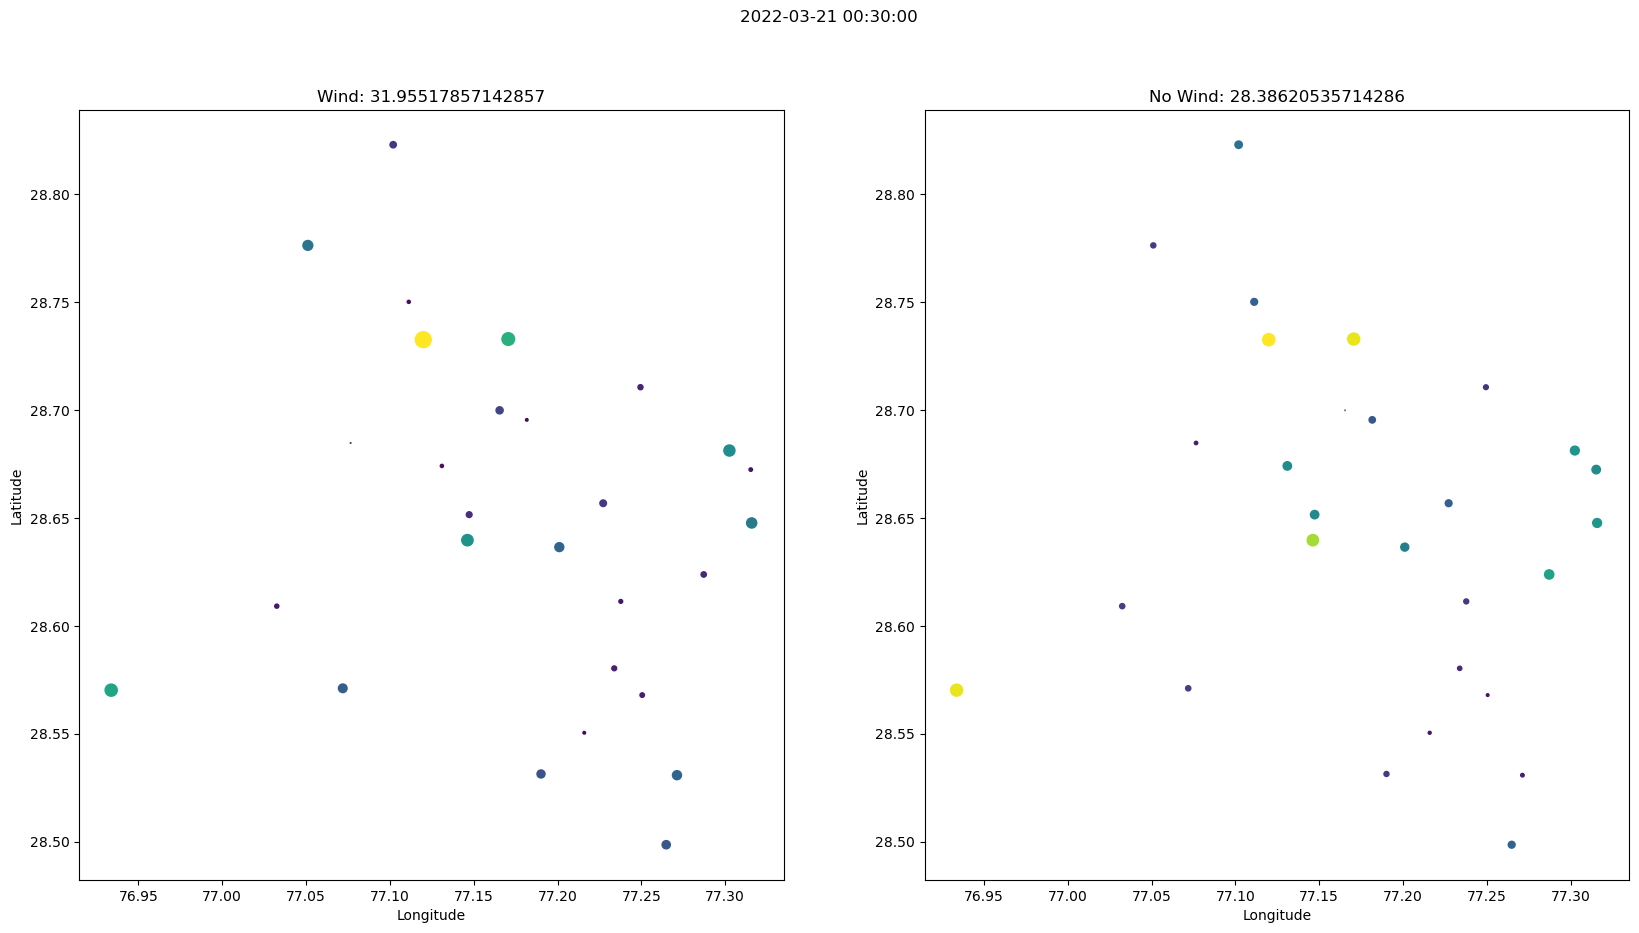

Timestamp: 2022-03-23 00:30:00
No Wind RMSE:  14.038836206896553
Wind RMSE:  23.97306034482759


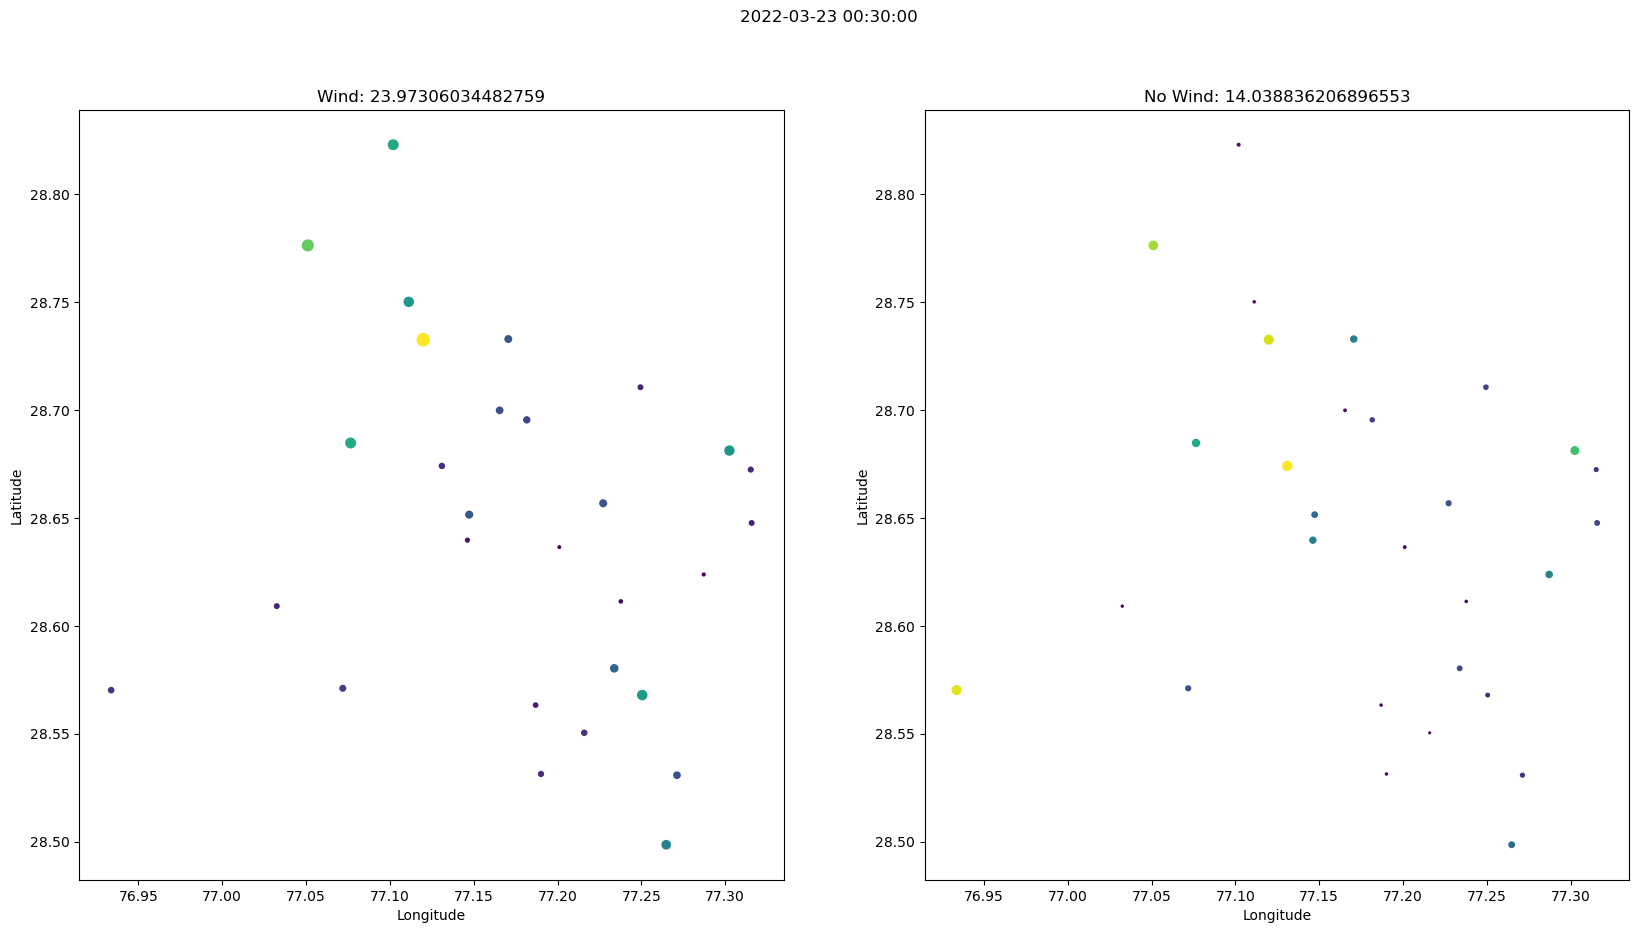

Timestamp: 2022-03-25 00:30:00
No Wind RMSE:  26.175416666666663
Wind RMSE:  29.34305555555556


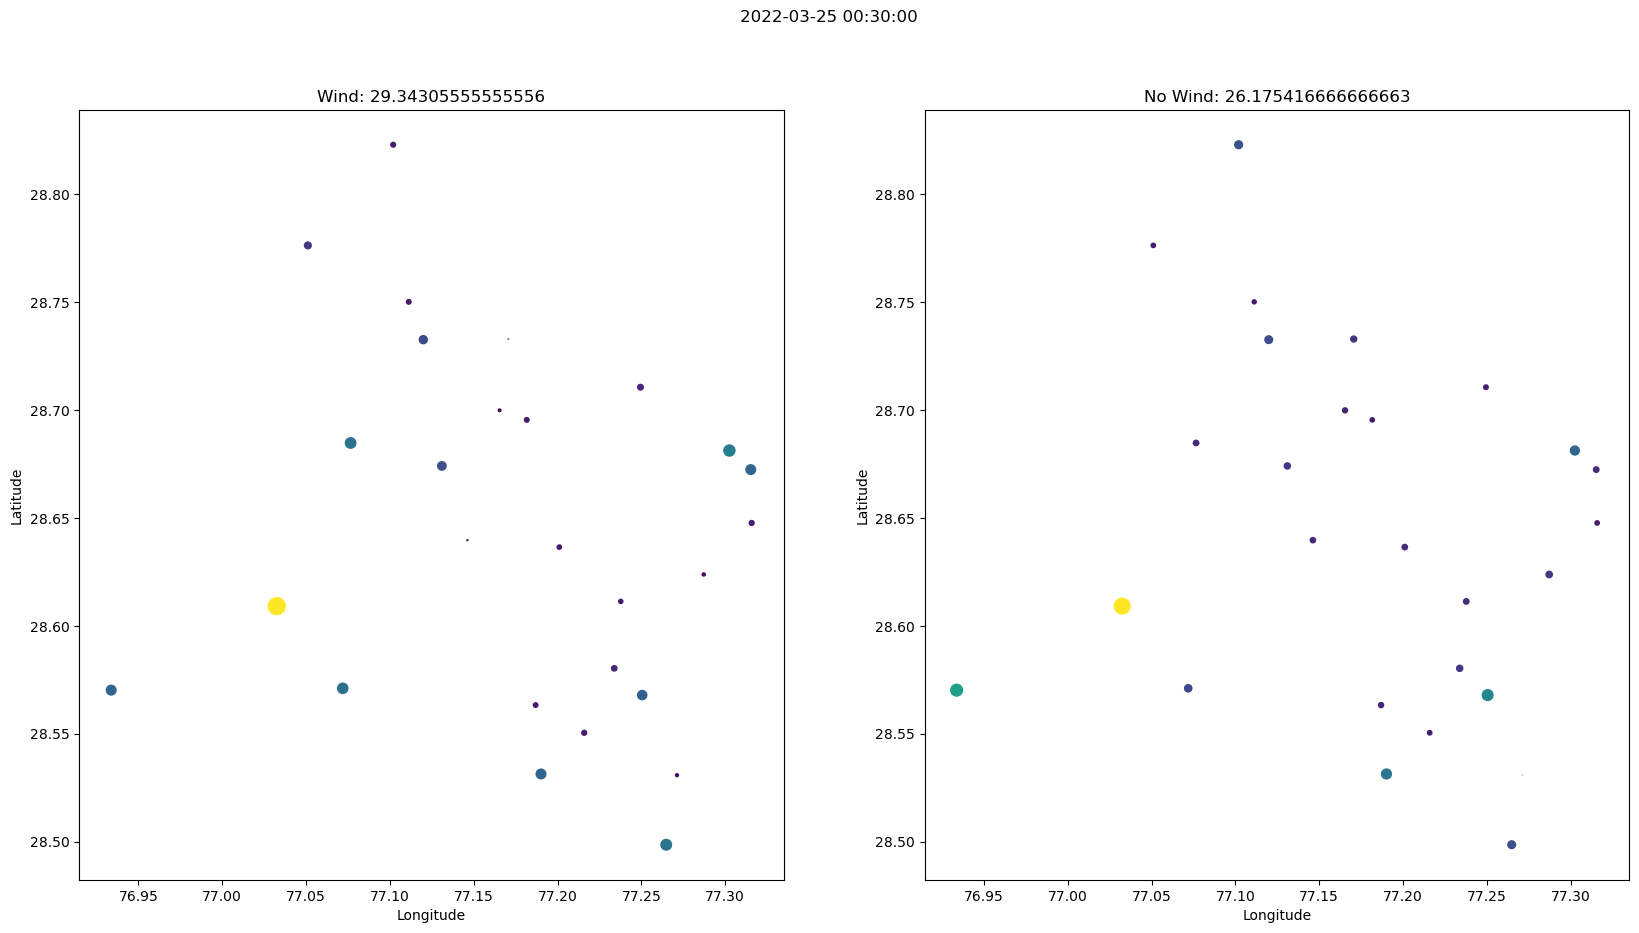

Timestamp: 2022-03-27 00:30:00
No Wind RMSE:  24.997129629629633
Wind RMSE:  33.276666666666664


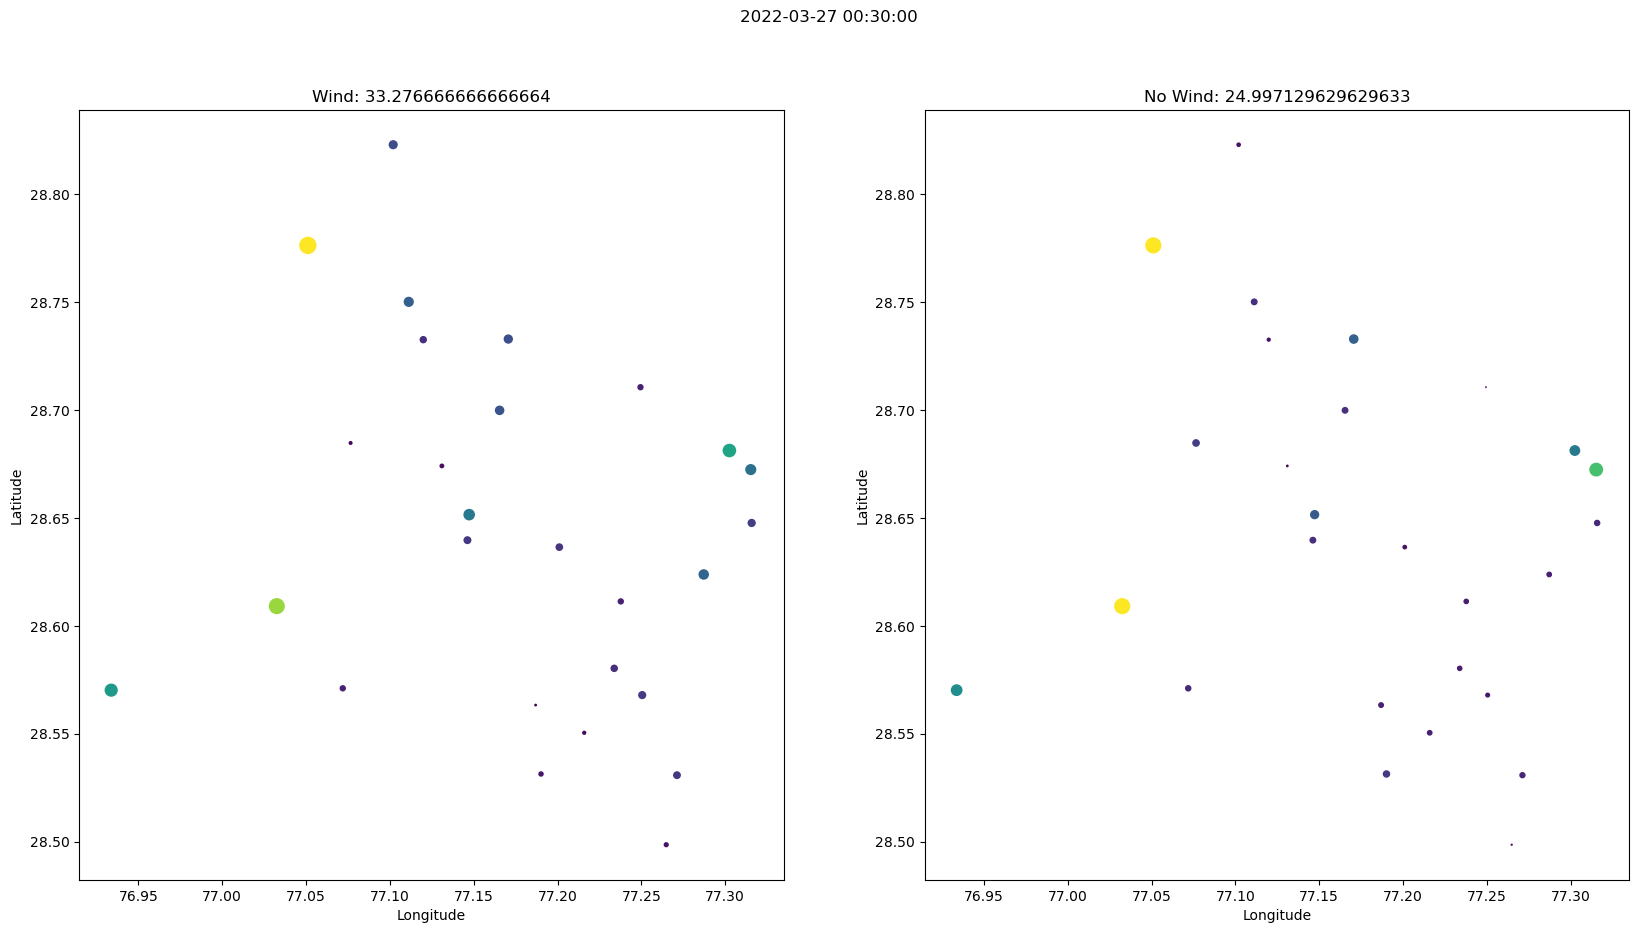

Timestamp: 2022-03-29 00:30:00
No Wind RMSE:  41.63568965517241
Wind RMSE:  49.882931034482766


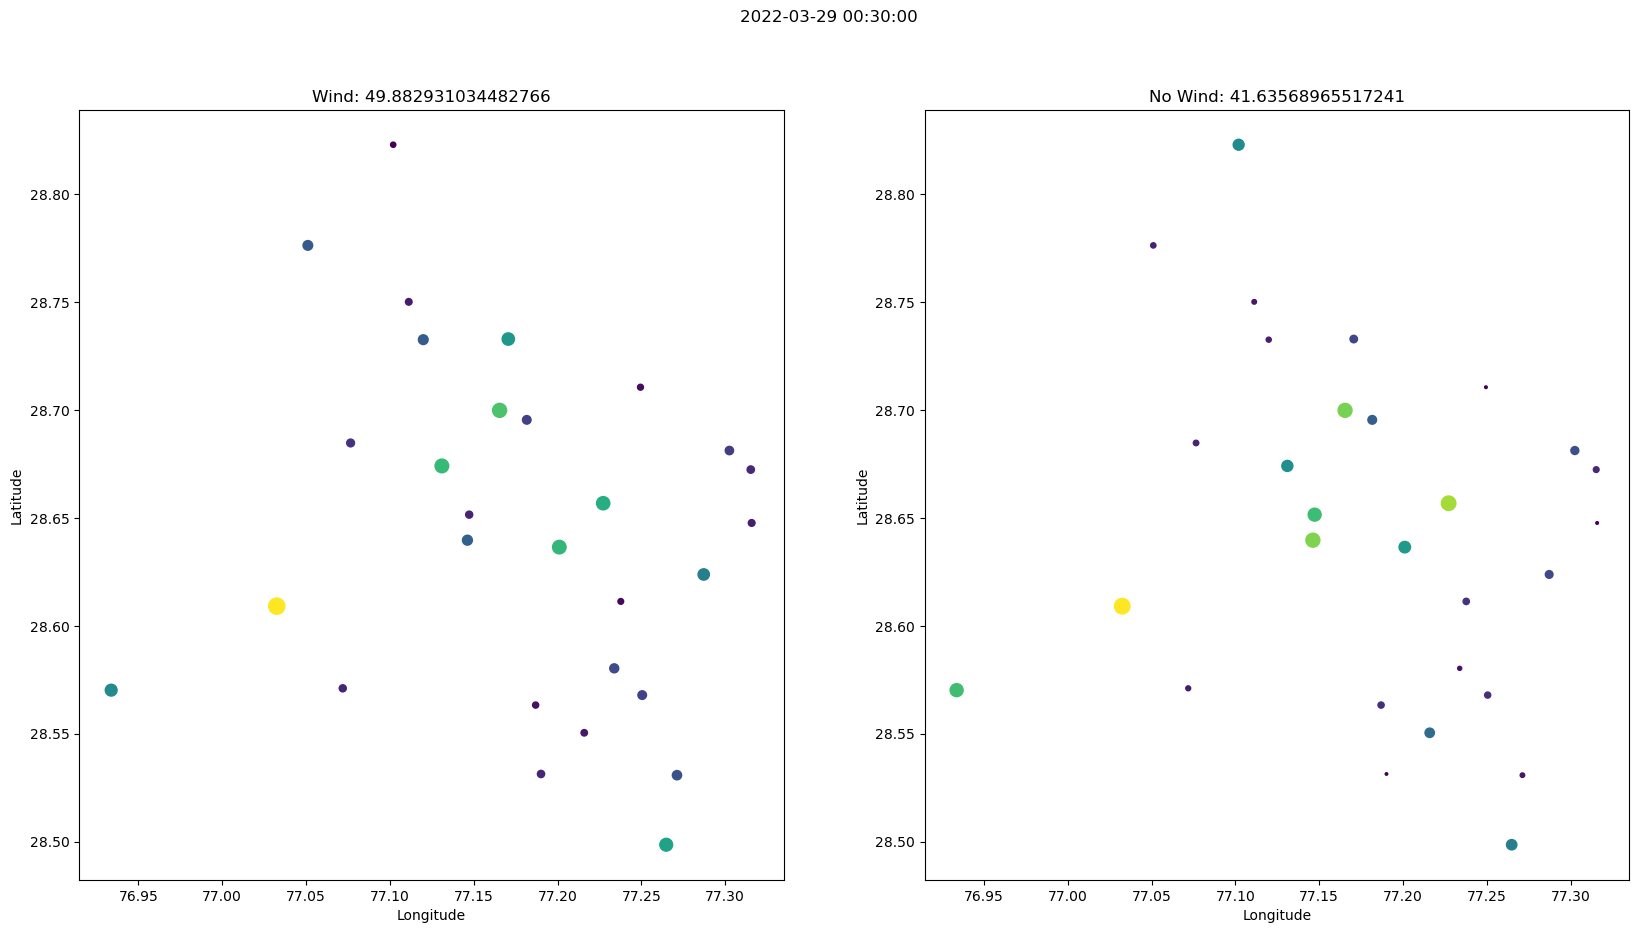

Timestamp: 2022-03-31 00:30:00
No Wind RMSE:  63.83841346153846
Wind RMSE:  75.82596153846154


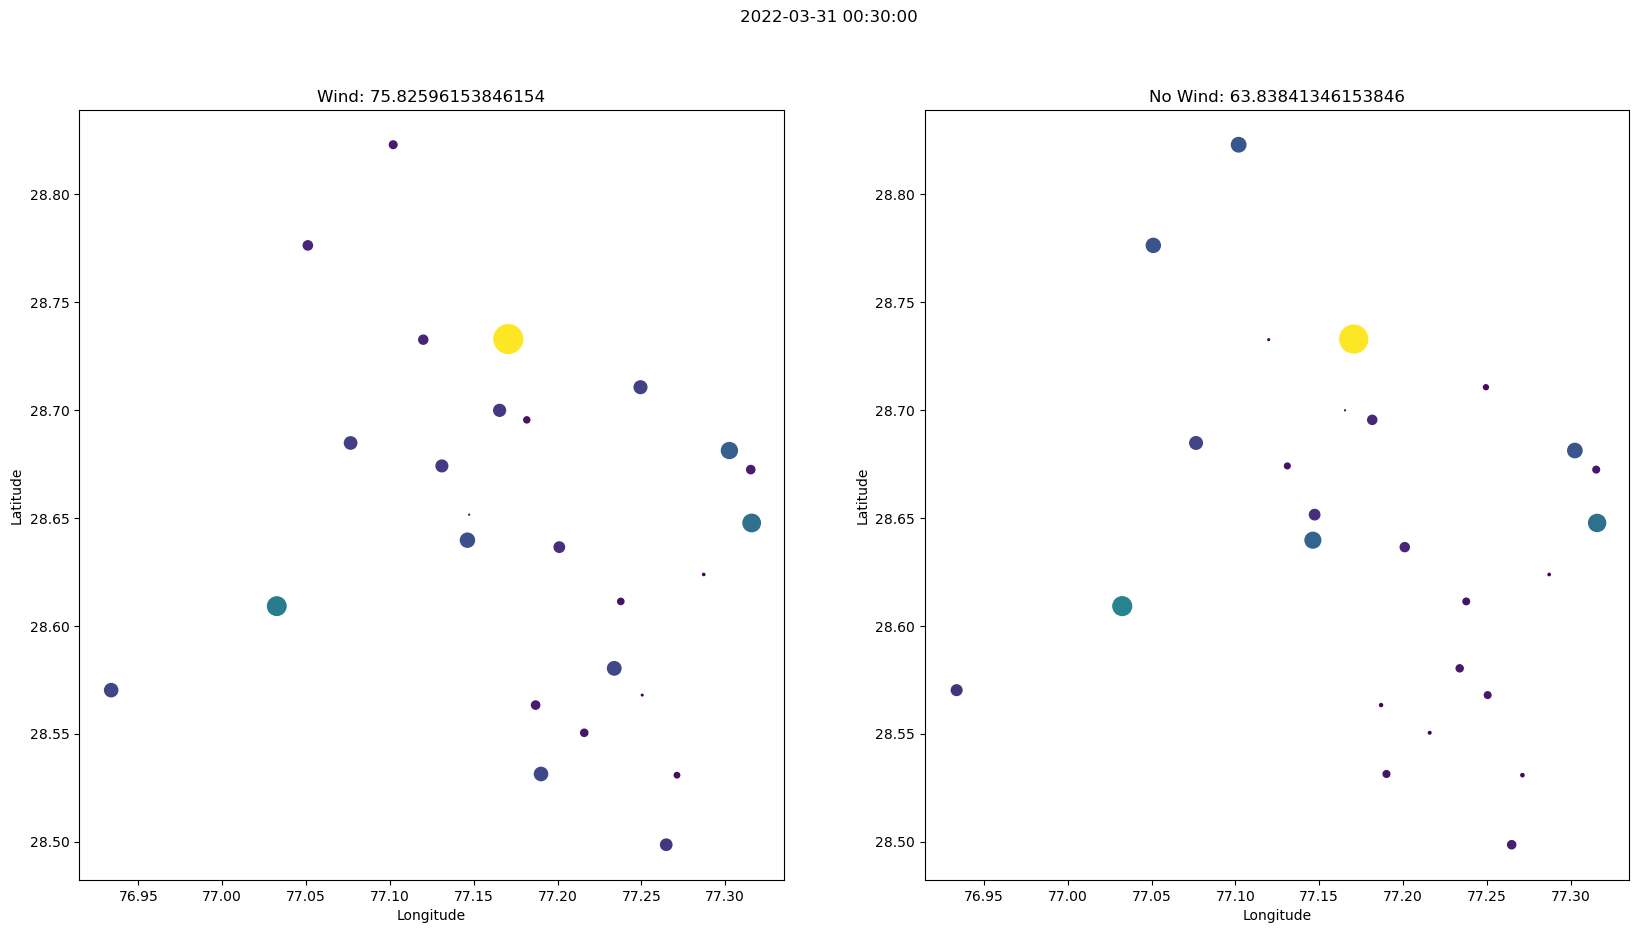

In [11]:
p = pd.date_range(start='2022-03-01 00:30:00', end='2022-04-01 00:30:00', freq = '2D').to_frame(name='dates')

for i in p['dates']:
    d_i = knn_loocv(i)
    d_i = pd.DataFrame(d_i)
    print("Timestamp:", i)
    print('No Wind RMSE: ', np.mean(d_i['no wind rmse']))
    print('Wind RMSE: ', np.mean(d_i['wind rmse']))
    
    plt.figure(figsize = (20,10))
    plt.suptitle(i)
    plt.subplot(1, 2, 1)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['wind rmse'], c = d_i['wind rmse'])
    title = 'Wind: ' + str(np.mean(d_i['wind rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 2, 2)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['no wind rmse'], c = d_i['no wind rmse'])
    title = 'No Wind: ' + str(np.mean(d_i['no wind rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# PM2.5 and Wind Direction Plots

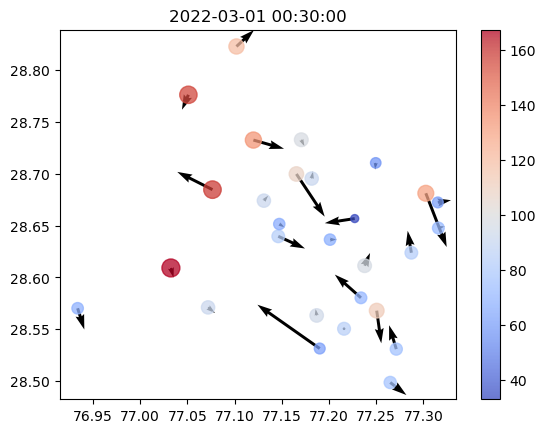

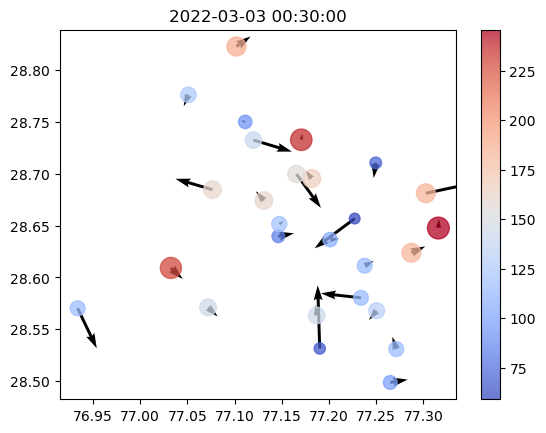

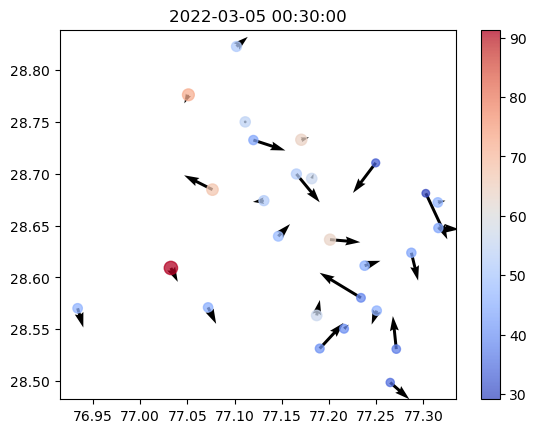

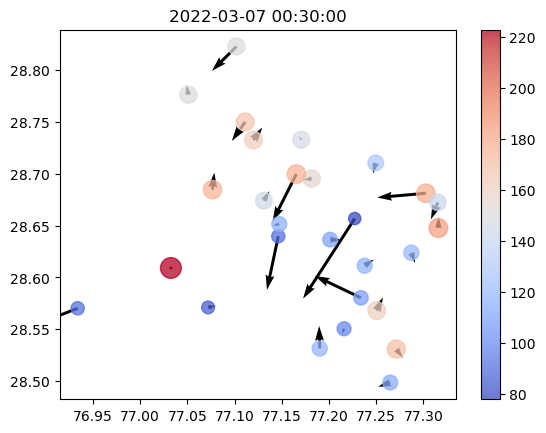

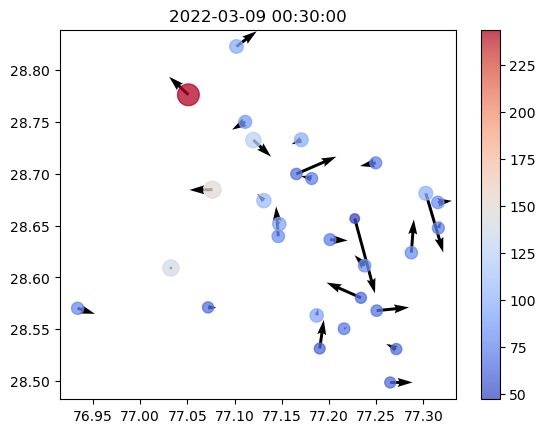

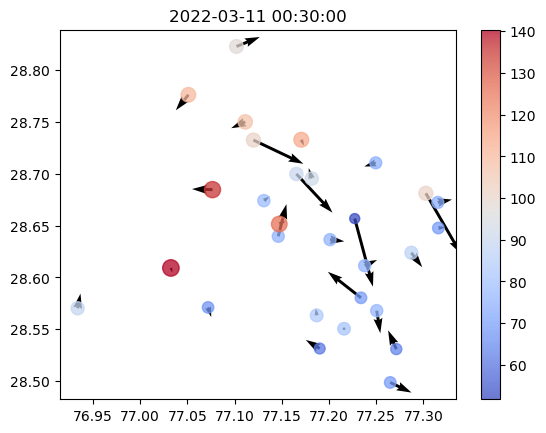

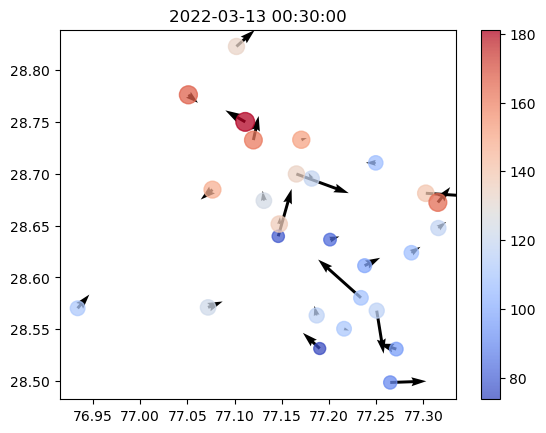

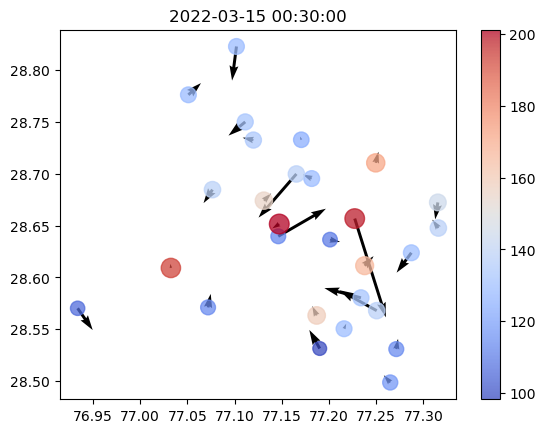

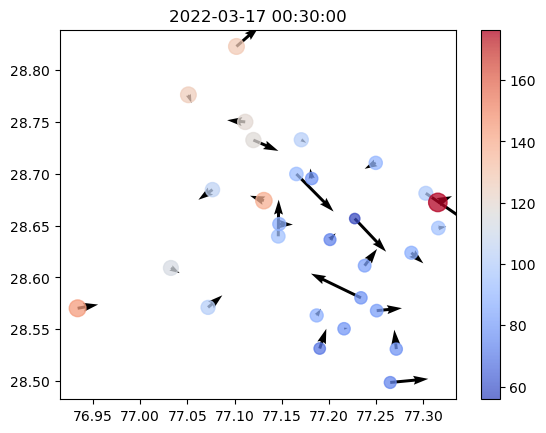

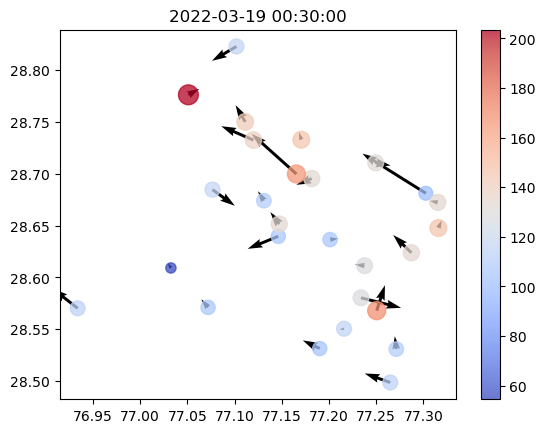

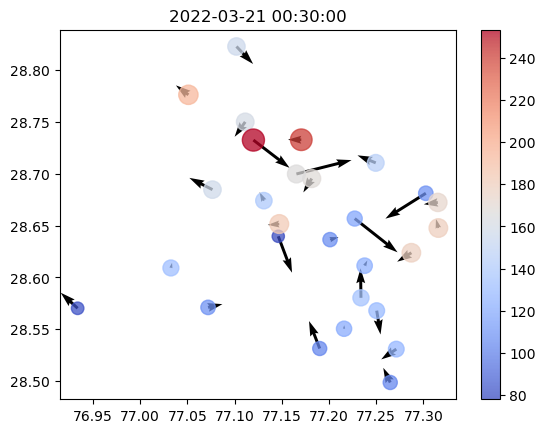

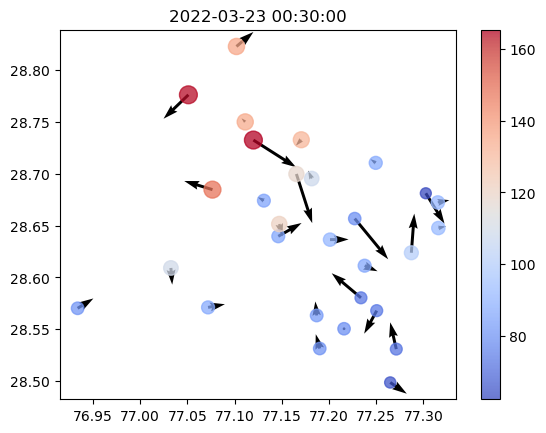

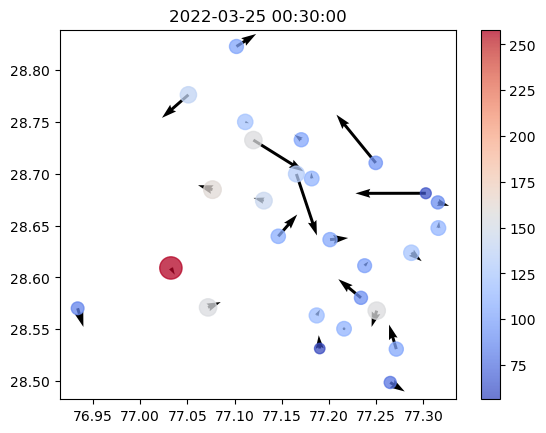

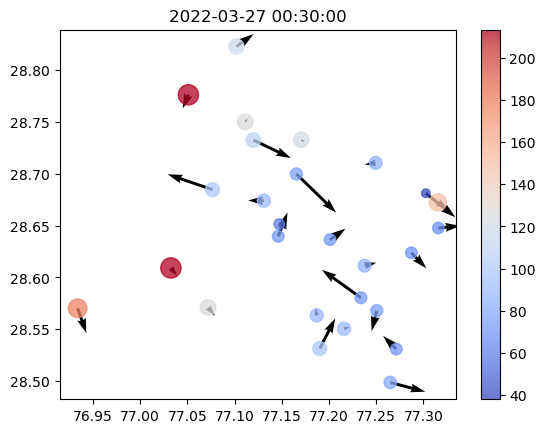

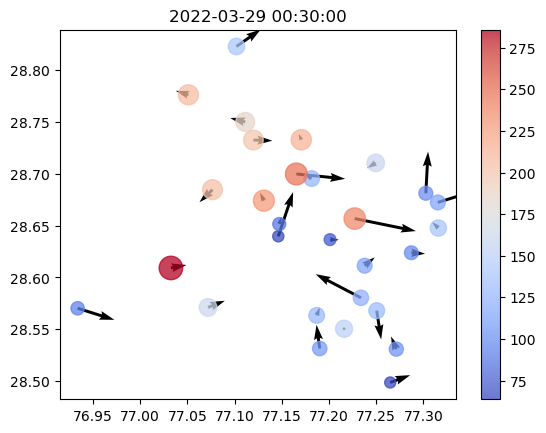

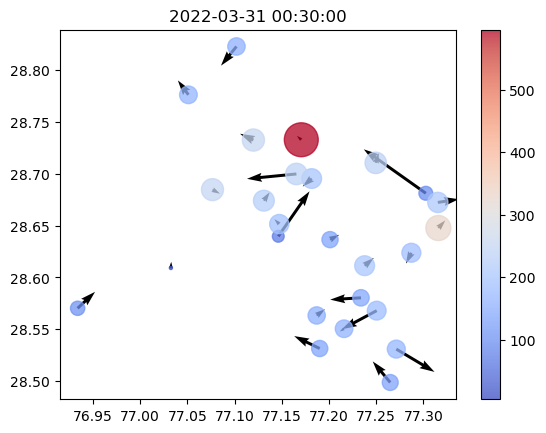

In [12]:
p = pd.date_range(start='2022-03-01 00:30:00', end='2022-04-01 00:30:00', freq = '2D').to_frame(name='dates')

for i in p['dates']:
    d = df[df["time"]==i]
    
    u = d['WS']*np.cos(np.radians(d['WD']))
    v = d['WS']*np.sin(np.radians(d['WD']))
    
    plt.quiver(d['longitude'], d['latitude'], u, v)
    plt.scatter(d['longitude'], d['latitude'], s = d['PM2.5'], c = d['PM2.5'], cmap = 'coolwarm', alpha = 0.75)
    plt.colorbar()
    plt.title(i)
    plt.show()